In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout

In [5]:
BATCH_SIZE = 128

In [6]:
save_model=True

In [7]:
#!mkdir saved_models

In [8]:
save_path=r'saved_models/'

In [9]:
os.environ['KERAS_HOME'] = os.path.join(os.getcwd(),'keras','datasets')

In [10]:
mnist_path = os.path.join(os.getcwd(),'keras','datasets/mnist.npz')
mnist_path

'/home/mluser_2/CNN_Work/keras/datasets/mnist.npz'

In [11]:
n_epochs = 30
num_classes = 10
input_shape=(28,28,1)


In [12]:
data_mean = 0.1307
data_std = 0.3081



## Some useful functions

In [13]:
def preprocess_img(x):
   # x = (x.astype('float32')-data_mean)/data_std #or x.astype('float32')/255.0
    x = x.astype('float32')/255.0
    x= np.reshape(x, (len(x),28,28,1))
    return x

In [14]:
def preprocess_labels(y):
    return tf.one_hot(y.astype(np.int32), depth=num_classes)

In [15]:
def noise(x, noise_fac = 0.4):
    noise_x = x + noise_fac*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noise_x, 0.0,1.0)

In [17]:
# find index of images with different classes true&pred
def find_diff_classes(y_true, y_pred, n=10000):    
    diff_classes_lst = []
    for i in range(n):
        if np.argmax(y_true[i])!= np.argmax(y_pred[i]):
            #print(np.argmax(y_true[i]),np.argmax(y_pred[i]), i)
            diff_classes_lst.append(i)
    return diff_classes_lst

In [557]:
# display images+true labels from one set
def display_true_pred_pair(x, y_pred, y_true, title ='', n=10):
    indices = np.arange(0,10,1)
    imgs_1 = x[indices,:] 
    
    fig=plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        true_title = f'True label: {np.argmax(y_true[i])}'
        pred_title = f'Pred label: {np.argmax(y_pred[i])}'
        plt.title(f'{true_title}\n{pred_title}\n', fontsize=14)
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle(title, y=1.2, fontsize=25)
    #fig.savefig('name')
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 589


In [34]:
# display images+true labels from one set
def display_one_batch_(x, y, title ='', n=10):
    indices = np.arange(0,10,1)
    imgs_1 = x[indices,:] 
    
    fig=plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.title(f'True label: {np.argmax(y[i])}') #for normilized images
        #plt.title(f'True label: {y[i]}')
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle(title, y=1.05, fontsize=20)
    #fig.savefig('name')
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 487


In [149]:
#display pair of images
def display_pair(x1, x2, n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    plt.figure(figsize=(20,4))
    for i, (img1, img2) in enumerate(zip(imgs_1,imgs_2)):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 499


In [484]:
#display pair of images: Original and Autoencoder restored images
def display_pair2(x1, x2, autoenc_name='', n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    
   # plt.text(1.0, 0.5, title, fontsize=30, visible=True)   
    fig = plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle('Original images',y=1.0,fontsize=20)     
    
    fig2 = plt.figure(figsize=(20,4))
    for i,  img2 in enumerate(imgs_2):
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig2.suptitle(f'Restored images with {autoenc_name} autoenc',y=0.6, fontsize=20)
    
    plt.show()

In [485]:
#display one pair of images: original and adversarial with their labels
def display_one_pair(x, x_adv, perturbation, y_true, y_pred):
    
    plt.figure(figsize=(20,2))
    fig, ax =plt.subplots(1, 4, figsize=(10,5))
    
    ax[0].imshow(x)
    ax[0].axis('off')
    ax[0].set_title('Original image', fontsize=15)
    ax[0].text(0.5, -0.13, f'True label: {np.argmax(y_true)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[1].imshow(perturbation)
    ax[1].axis('off')
    ax[1].set_title('Perturbation', fontsize=15)
    
    
    ax[2].imshow(x_adv)
    ax[2].axis('off')
    ax[2].set_title('Adversarial image', fontsize=15)
    ax[2].text(2.9, -0.13, f'Pred label: {np.argmax(y_pred)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[3].axis('off')
    plt.show()

## Preprocess the mnist dataset

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(mnist_path) 

In [86]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), TensorShape([60000, 10]))

In [25]:
#x_train[0]

In [26]:
x_train.mean(), x_train.std(), x_train.mean()/255.0 , x_train.std()/255.0

(33.318421449829934,
 78.56748998339798,
 0.1306604762738429,
 0.30810780385646264)

In [27]:
x_train = preprocess_img(x_train)
x_test = preprocess_img(x_test)
x_train.shape

(60000, 28, 28, 1)

In [535]:
type(x_train[0]),type(x_test[8])

(numpy.ndarray, numpy.ndarray)

In [29]:
y_train = preprocess_labels(y_train)
y_test = preprocess_labels(y_test)


In [536]:
y_train.shape, y_test.shape

(TensorShape([60000, 10]), TensorShape([10000, 10]))

In [31]:
y_test[0]

<tf.Tensor: id=13, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

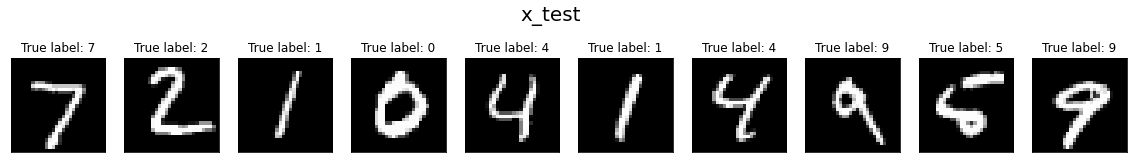

In [35]:
display_one_batch_(x_test, y_test, 'x_test')

#### Add noise to dataset

In [271]:
#add noise to images
x_train_noisy = noise(x_train, 0.1)
x_test_noisy = noise(x_test, 0.3)
x_train_noisy.shape

(60000, 28, 28, 1)

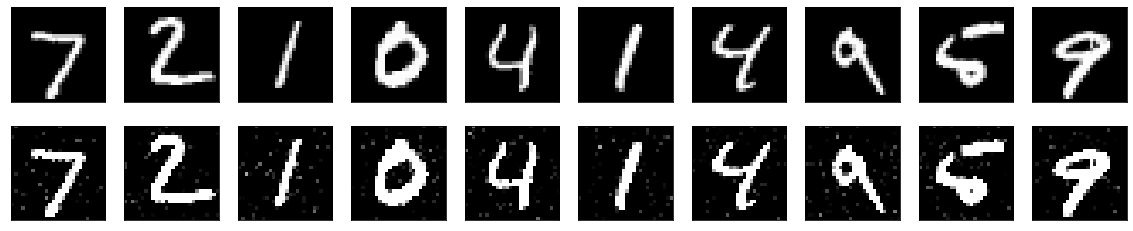

In [272]:
display_pair(x_test, x_test_noisy)

### DEFAULT MODEL

In [273]:
learning_rate = 1.0

In [27]:
input_imgs = Input(input_shape)
x=Conv2D(32,(3,3), activation='relu')(input_imgs)
x=MaxPooling2D()(x)
x=Dropout(0.4)(x)
x=Conv2D(64, (3,3), activation='relu')(x)
x=MaxPooling2D()(x)
x=Dropout(0.4)(x)
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.4)(x)

outputs=Dense(10, activation='softmax')(x)

In [28]:
model = Model(inputs=input_imgs, outputs=outputs, name='mnist_default_model')

In [29]:
# scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     learning_rate,
#     decay_steps=len(x_train),
#     decay_rate=gamma
# )
#optimizer = tf.keras.optimizers.Adadelta()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae','acc'])

In [589]:
model.summary()

Model: "mnist_default_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)  

In [31]:
model.fit(x_train, y_train,
         batch_size=BATCH_SIZE,
         epochs= n_epochs,
         validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 44s 739us/sample - loss: 0.3761 - mae: 0.0364 - acc: 0.8803 - val_loss: 0.0809 - val_mae: 0.0089 - val_acc: 0.9746
Epoch 2/30
60000/60000 [==============================] - 42s 707us/sample - loss: 0.1293 - mae: 0.0130 - acc: 0.9600 - val_loss: 0.0541 - val_mae: 0.0062 - val_acc: 0.9821
Epoch 3/30
60000/60000 [==============================] - 44s 729us/sample - loss: 0.0983 - mae: 0.0098 - acc: 0.9702 - val_loss: 0.0385 - val_mae: 0.0045 - val_acc: 0.9866
Epoch 4/30
60000/60000 [==============================] - 43s 710us/sample - loss: 0.0826 - mae: 0.0082 - acc: 0.9751 - val_loss: 0.0337 - val_mae: 0.0039 - val_acc: 0.9886
Epoch 5/30
60000/60000 [==============================] - 42s 700us/sample - loss: 0.0713 - mae: 0.0071 - acc: 0.9781 - val_loss: 0.0304 - val_mae: 0.0034 - val_acc: 0.9890
Epoch 6/30
60000/60000 [==============================] - 43s 715us/sample - loss: 0.

In [ ]:
loss: 1.2452 - mae: 0.1215 - acc: 0.5951 - val_loss: 0.9460 - val_mae: 0.1115 - val_acc: 0.8309

In [32]:
if save_model==True:
    model.save(os.path.join(save_path, 'mnist_default_model'))
    model.save_weights(os.path.join('weights',"mnist_cnn_tf.ckpt"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/mnist_default_model/assets


In [33]:
model.save(os.path.join(save_path, 'mnist_default_model.h5'))

In [558]:
#test loading the model
loaded_model_mnist = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model.h5'))
loaded_model_mnist.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.02046797925942046, 0.0016699061, 0.9933]

In [559]:
loaded_model_mnist.summary()

Model: "mnist_default_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)  

In [301]:
default_score = model.evaluate(x_test,y_test)
default_score
#loss: 0.0151 - mae: 0.0025 - acc: 0.9908

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.030199156938371698, 0.0024556904, 0.9908]

In [ ]:
print(f'loss: {default_score[0]} mae: {default_score[1]} accuracy: {default_score[2]}')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-557-1201788887f1>", line 1, in <module>
    print(f'loss: {default_score[0]} mae: {default_score[1]} accuracy: {default_score[2]}')
NameError: name 'default_score' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_

In [560]:
preds_default = loaded_model_mnist.predict(x_test)
preds_default

array([[1.7096016e-11, 7.1281465e-09, 8.2536472e-10, ..., 9.9999976e-01,
        1.6566489e-11, 2.3262984e-07],
       [3.9517296e-09, 8.3128243e-06, 9.9999142e-01, ..., 5.8404466e-12,
        8.2133716e-11, 1.0747098e-16],
       [1.1458608e-11, 1.0000000e+00, 1.1155212e-11, ..., 6.3511973e-09,
        9.7288122e-10, 1.0006928e-11],
       ...,
       [1.1334463e-16, 3.2016748e-10, 2.3063697e-14, ..., 4.2360807e-10,
        3.0786772e-08, 5.6821121e-09],
       [3.2053443e-11, 2.4361228e-14, 7.9092612e-16, ..., 3.6557983e-14,
        3.8252429e-06, 1.7420740e-11],
       [1.7283478e-09, 7.0652387e-11, 1.1503642e-09, ..., 4.2609511e-13,
        1.8921495e-09, 6.4704436e-11]], dtype=float32)

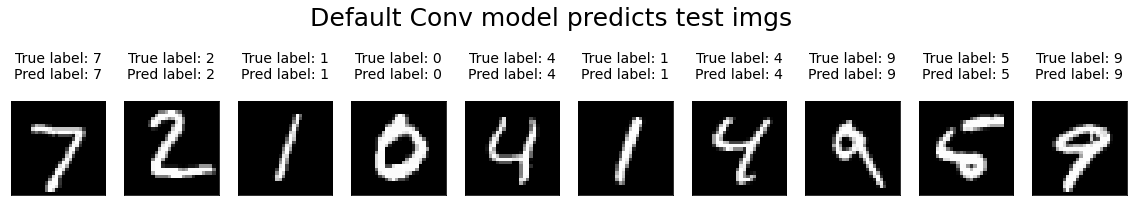

In [561]:
display_true_pred_pair(x_test, y_test, preds_default, 'Default Conv model predicts test imgs')

## ATTACKS

### FGSM

In [ ]:
# add here math description of fgsm attack

#### Attack several imgs

In [42]:
# prepare image for showing
def prepare_img(x):
    return np.reshape(x,(28,28))


In [43]:
def prepare_label(y):
    return np.argmax(y)

In [47]:
def create_perturbation_fgsm(model_fn, input_img, true_label):
    
    loss_func = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE или SparseCategoricalCrossentropy
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        loss = loss_func(true_label, prediction)
        
    #Get the gradients for the loss
    gradient = gt.gradient(loss, input_img)
    # Get the sign of the gradients to create the perturbation
    perturbation = tf.sign(gradient)
    
    return perturbation

In [152]:
# Func for fgsm attack on the whole dataset. Return perturbations and adversarial images of input dataset len
def FGSM(model_fn, dataset_name, epsilon=0.3):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]
        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
       
        perturbations[i] = create_perturbation_fgsm(model_fn, image, label)
        
        adv_imgs[i] = image + perturbations[i]*epsilon
    #return perturbations
    return perturbations, adv_imgs

In [153]:
#model = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model.h5'))

In [154]:
name = 'test'

In [332]:
x_test_fgsm_perts, x_test_fgsm_imgs = FGSM(model, name, epsilon = 0.09)


In [333]:
test_fgsm_preds = model.predict(x_test_fgsm_imgs)

In [334]:
x_test_fgsm_imgs.shape, y_test.shape

((10000, 28, 28, 1), TensorShape([10000, 10]))

In [335]:
fgsm_eval_defaut_model = model.evaluate(x_test_fgsm_imgs, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [336]:
print(f'Default model on fgsm_adv_images:\n loss: {fgsm_eval_defaut_model[0]} mae: {fgsm_eval_defaut_model[1]} accuracy: {fgsm_eval_defaut_model[2]}') 

Default model on fgsm_adv_images:
 loss: 0.34424072987586257 mae: 0.02434440702199936 accuracy: 0.9017000198364258


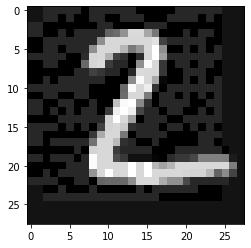

In [337]:
plt.imshow(x_test_fgsm_imgs[1].reshape(28,28))
plt.gray()

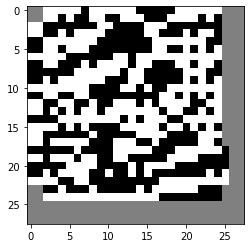

In [338]:
plt.imshow(x_test_fgsm_perts[1].reshape(28,28))
plt.gray()

[4, 8]


<Figure size 1440x144 with 0 Axes>

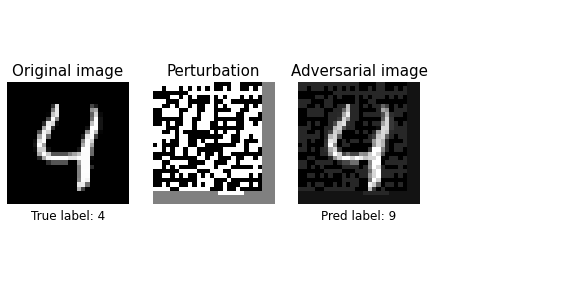

<Figure size 1440x144 with 0 Axes>

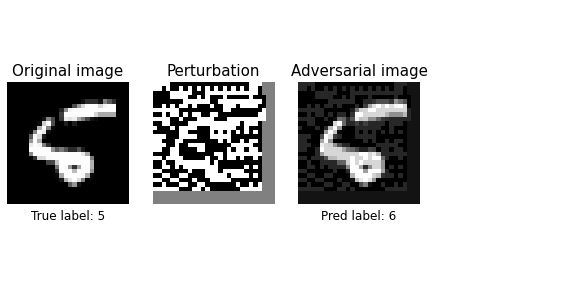

In [339]:
#eps = 0.09
x_x_adv_imgs = find_diff_classes(y_test, test_fgsm_preds, n=10)
print(x_x_adv_imgs )
for idx in x_x_adv_imgs:
    display_one_pair(x_test[idx], x_test_fgsm_imgs[idx], x_test_fgsm_perts[idx], y_test[idx], test_fgsm_preds[idx])

In [115]:
x_x_adv_imgs = find_diff_classes(y_test, test_fgsm_preds, n=10)
x_x_adv_imgs 

[4, 8]

<Figure size 1440x144 with 0 Axes>

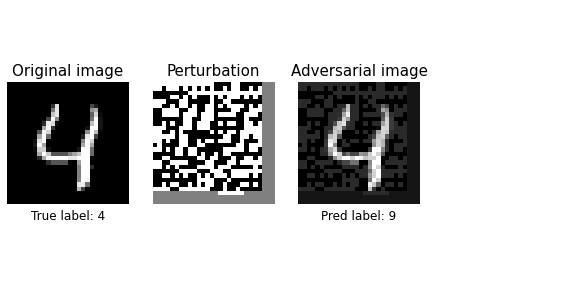

In [117]:
display_one_pair(x_test[4], x_test_fgsm_imgs[4], x_test_fgsm_perts[4], y_test[4], test_fgsm_preds[4])

<Figure size 1440x144 with 0 Axes>

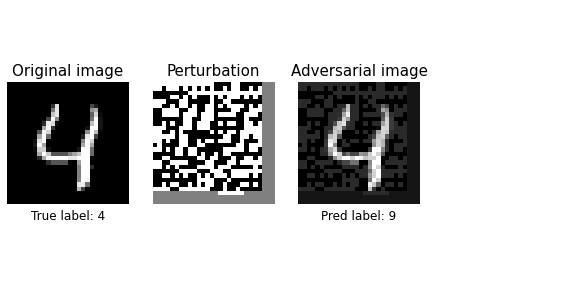

<Figure size 1440x144 with 0 Axes>

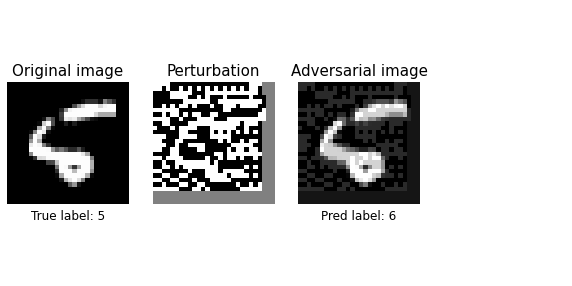

In [118]:
for idx in x_x_adv_imgs:
    display_one_pair(x_test[idx], x_test_fgsm_imgs[idx], x_test_fgsm_perts[idx], y_test[idx], test_fgsm_preds[idx])

In [150]:
#display pair of images: Original and Perturbed
def display_pair3(x1, x2, n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    fig = plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle('Original images',fontsize=20)     
    
    fig2 = plt.figure(figsize=(20,4))
    for i,  img2 in enumerate(imgs_2):
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig2.suptitle('Perturbed images',y=0.05, fontsize=20)
    
    plt.show()

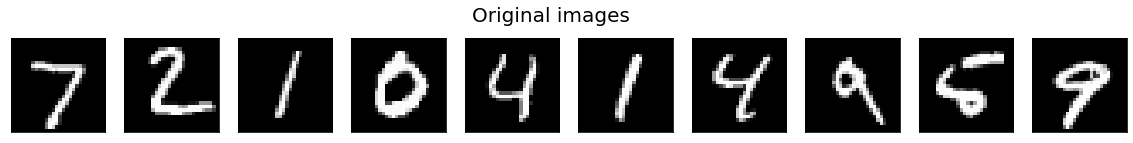

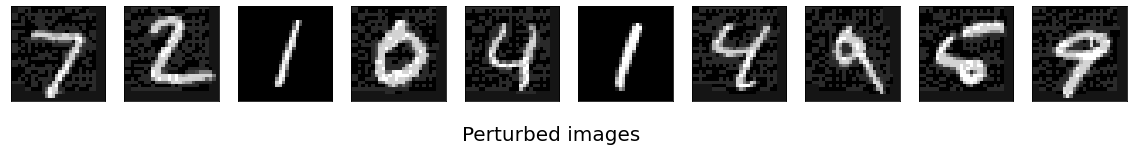

In [151]:
# не убирать! eps = 0.1
display_pair3(x_test, x_test_fgsm_imgs)

### Basic Iterative Method

In [503]:
#right bim
def create_perturbation_bim(model_fn, input_img, true_label, epsilon):
    
    loss_func = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE или SparseCategoricalCrossentropy
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        loss = loss_func(true_label, prediction)
        
    #Get the gradients for the loss
    gradient = gt.gradient(loss, input_img)
    # Get the sign of the gradients to create the perturbation
    perturbation = epsilon*tf.sign(gradient)
    
    return perturbation, loss

In [506]:
# Func for fgsm attack on the whole dataset. Return perturbations and adversarial images of input dataset len
def BIM(model_fn, dataset_name, epsilon):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    loss = np.empty([len(dataset)])
    
    alpha=epsilon/10
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
        
        itr=0
        while True:
            perturbations[i], loss[i] = create_perturbation_bim(model_fn, image, label, alpha)            
            adv_imgs[i] = image - perturbations[i]
            itr+=1
            if itr>10 or loss[i]<2:
                break
    #return perturbations
    return perturbations, adv_imgs

In [507]:
name = 'test'

In [524]:
x_test_bim_perts, x_test_bim_imgs  = BIM(model, name, epsilon=1.0)

In [525]:
test_bim_preds = model.predict(x_test_bim_imgs)

In [526]:
#x_test_bim_imgs[1]

In [527]:
x_test_bim_imgs.shape, y_test.shape

((10000, 28, 28, 1), TensorShape([10000, 10]))

In [528]:
bim_eval_defaut_model = model.evaluate(x_test_bim_imgs, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [529]:
print(f'Default model on bim_adv_images:\n loss: {bim_eval_defaut_model[0]} mae: {bim_eval_defaut_model[1]} accuracy: {bim_eval_defaut_model[2]}') 

Default model on bim_adv_images:
 loss: 0.00075673311850041 mae: 0.00012553000124171376 accuracy: 0.9997000098228455


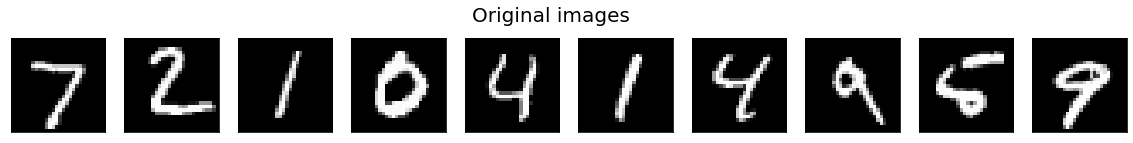

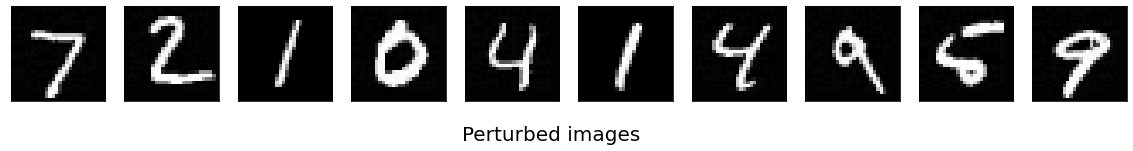

In [515]:
display_pair3(x_test[:10], x_test_bim_imgs)

In [516]:
x_x_adv_imgs = find_diff_classes(y_test, test_bim_preds)
x_x_adv_imgs

[]

<Figure size 1440x144 with 0 Axes>

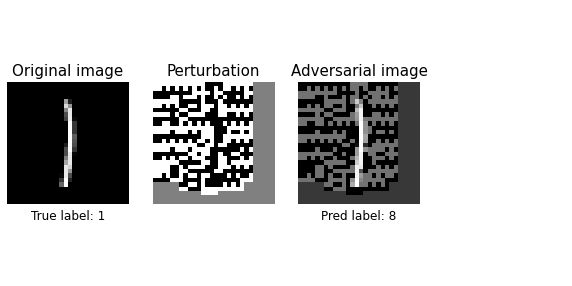

<Figure size 1440x144 with 0 Axes>

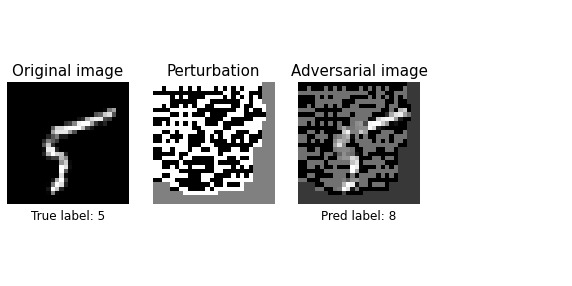

<Figure size 1440x144 with 0 Axes>

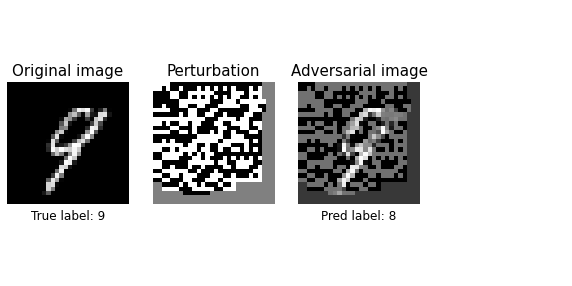

<Figure size 1440x144 with 0 Axes>

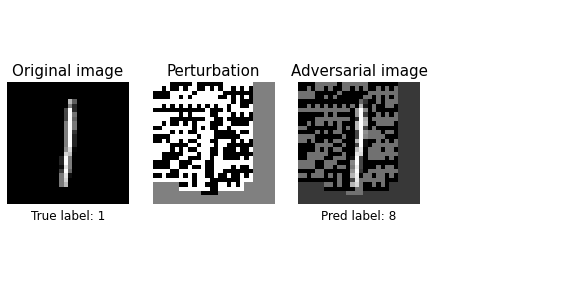

<Figure size 1440x144 with 0 Axes>

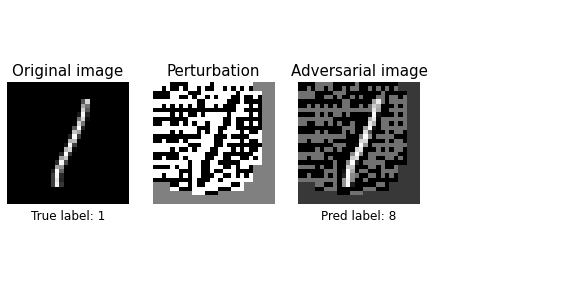

<Figure size 1440x144 with 0 Axes>

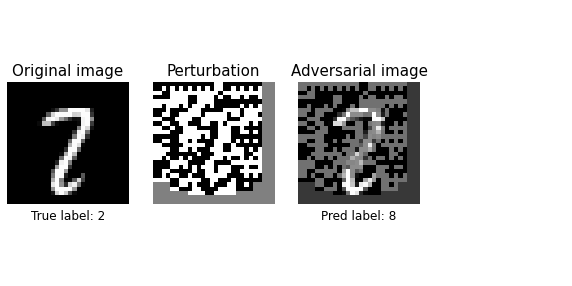

<Figure size 1440x144 with 0 Axes>

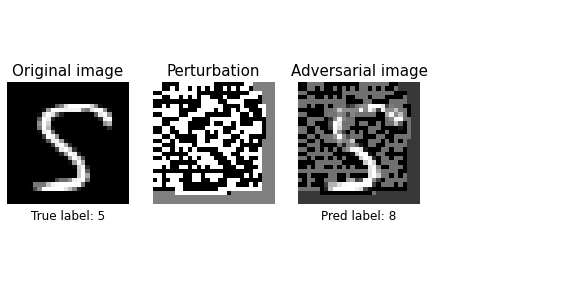

<Figure size 1440x144 with 0 Axes>

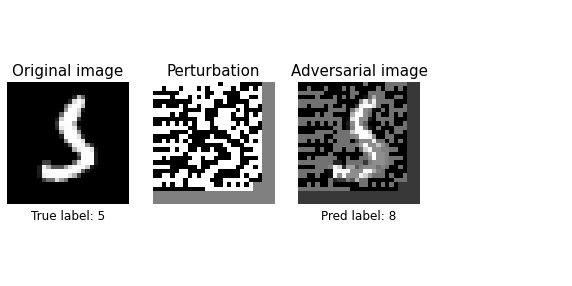

<Figure size 1440x144 with 0 Axes>

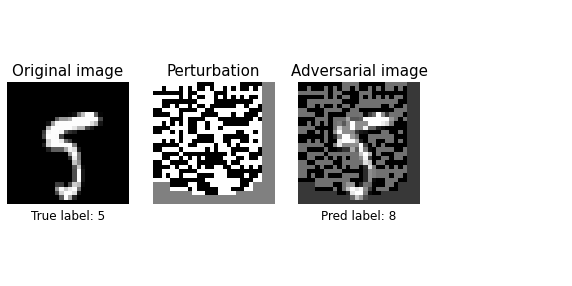

<Figure size 1440x144 with 0 Axes>

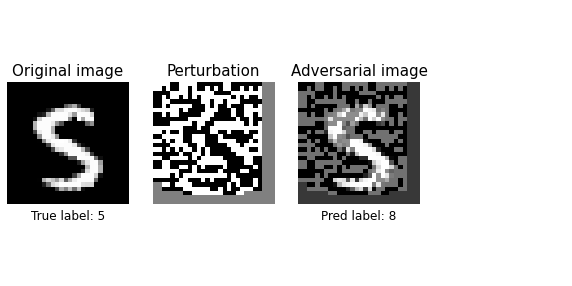

<Figure size 1440x144 with 0 Axes>

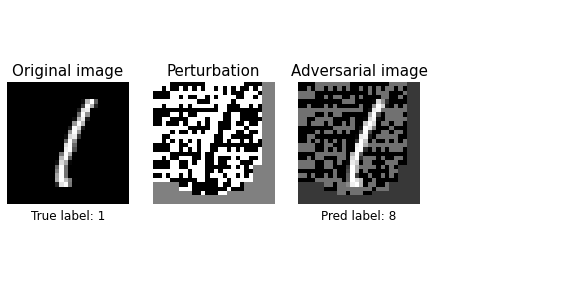

<Figure size 1440x144 with 0 Axes>

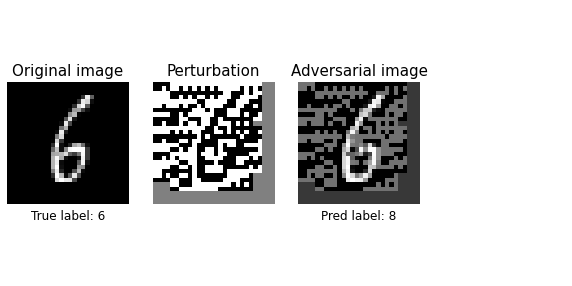

<Figure size 1440x144 with 0 Axes>

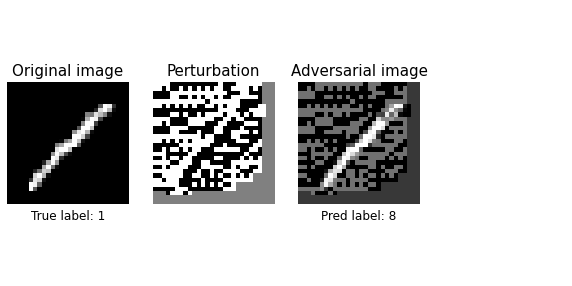

<Figure size 1440x144 with 0 Axes>

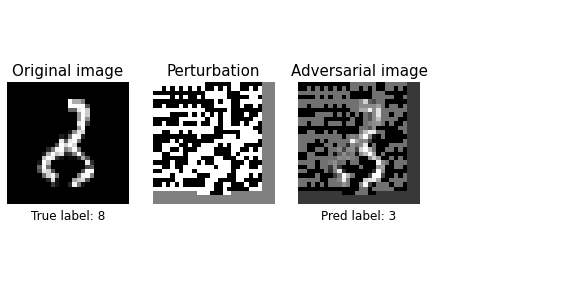

<Figure size 1440x144 with 0 Axes>

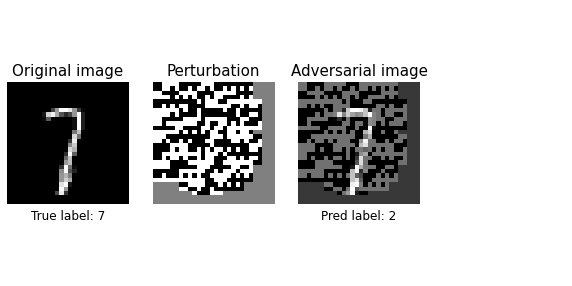

<Figure size 1440x144 with 0 Axes>

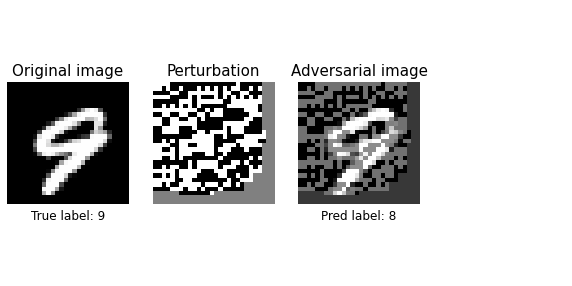

<Figure size 1440x144 with 0 Axes>

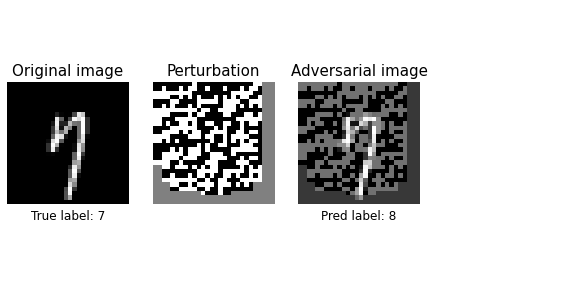

<Figure size 1440x144 with 0 Axes>

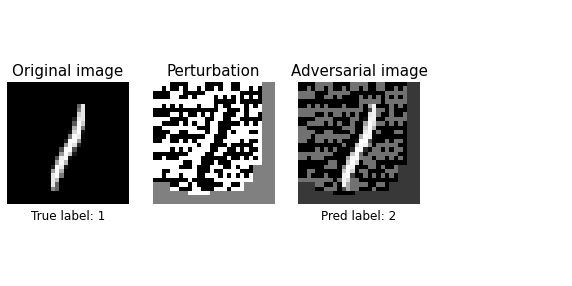

<Figure size 1440x144 with 0 Axes>

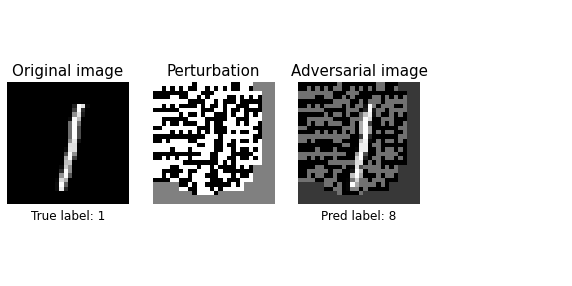

<Figure size 1440x144 with 0 Axes>

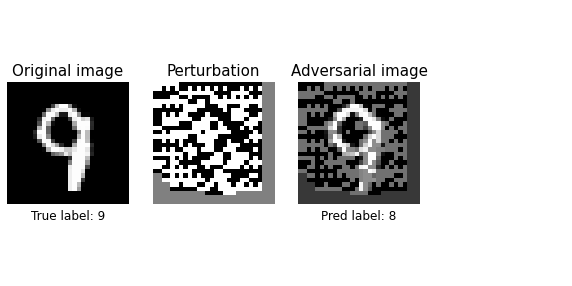

<Figure size 1440x144 with 0 Axes>

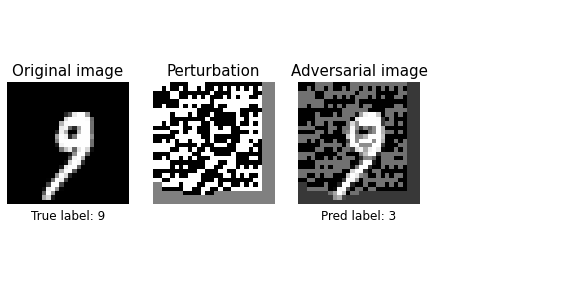

<Figure size 1440x144 with 0 Axes>

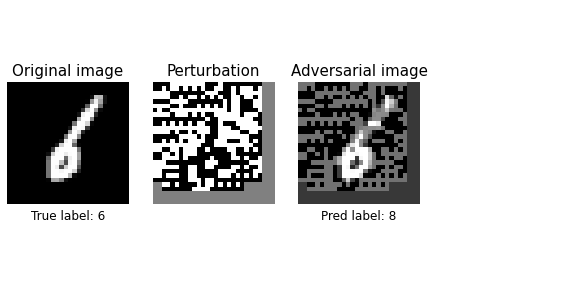

<Figure size 1440x144 with 0 Axes>

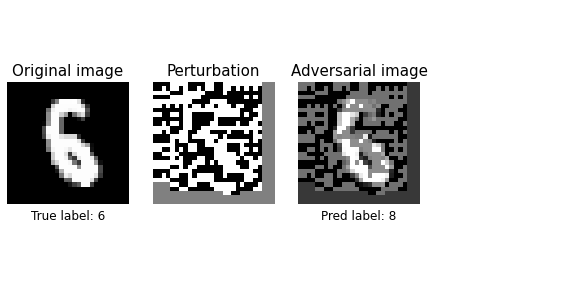

<Figure size 1440x144 with 0 Axes>

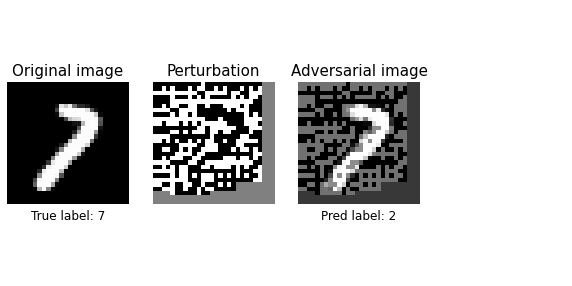

<Figure size 1440x144 with 0 Axes>

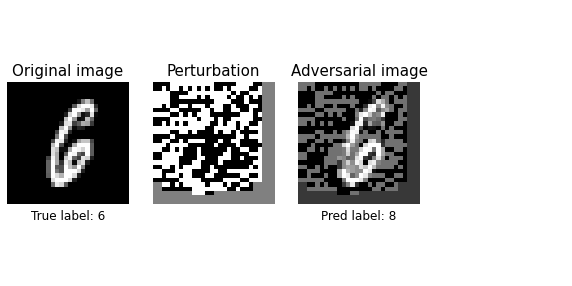

<Figure size 1440x144 with 0 Axes>

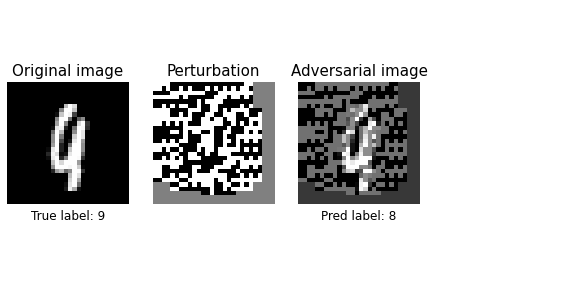

<Figure size 1440x144 with 0 Axes>

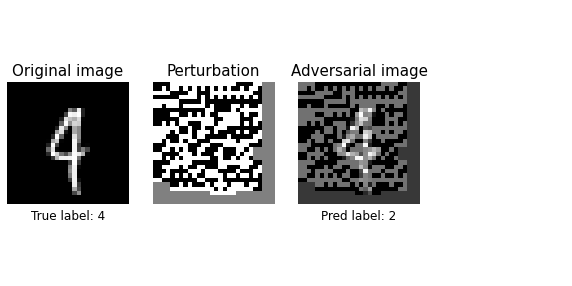

<Figure size 1440x144 with 0 Axes>

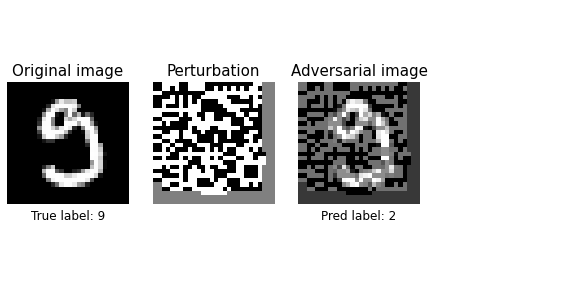

<Figure size 1440x144 with 0 Axes>

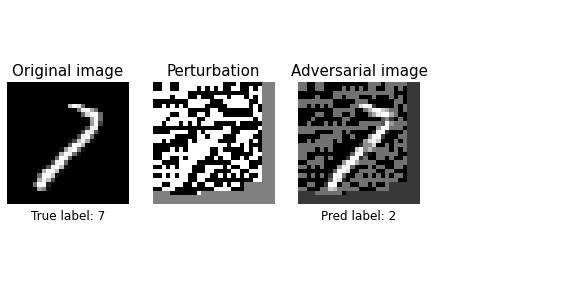

<Figure size 1440x144 with 0 Axes>

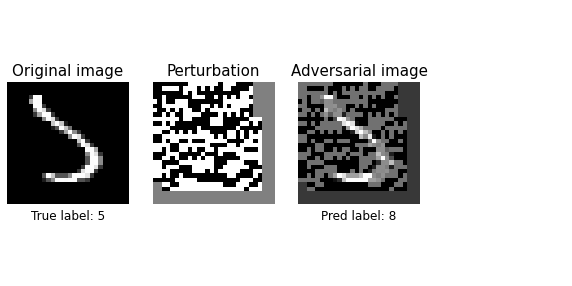

<Figure size 1440x144 with 0 Axes>

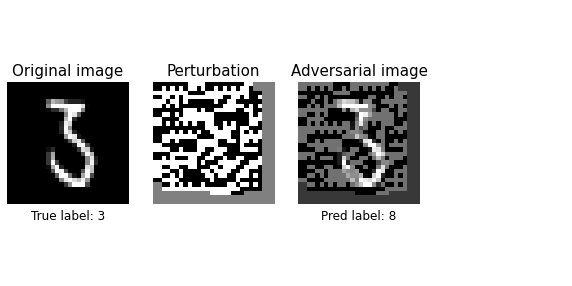

<Figure size 1440x144 with 0 Axes>

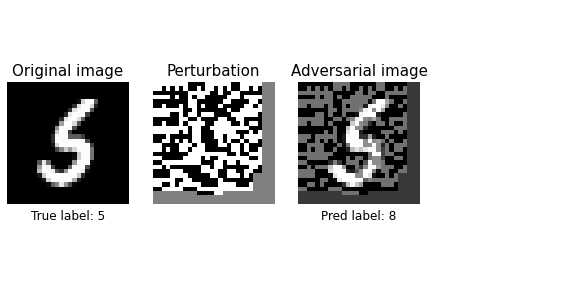

<Figure size 1440x144 with 0 Axes>

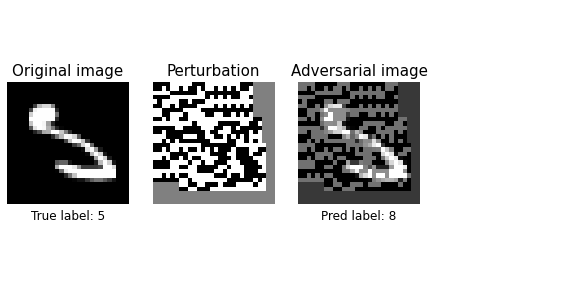

<Figure size 1440x144 with 0 Axes>

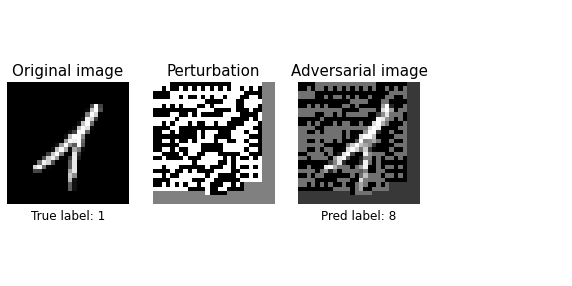

<Figure size 1440x144 with 0 Axes>

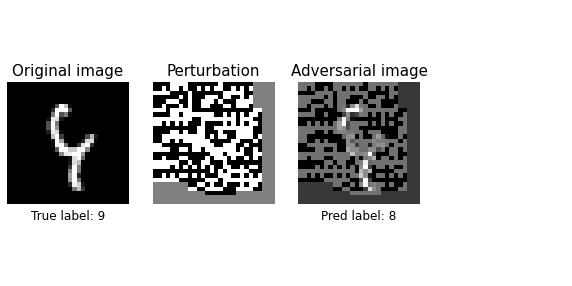

<Figure size 1440x144 with 0 Axes>

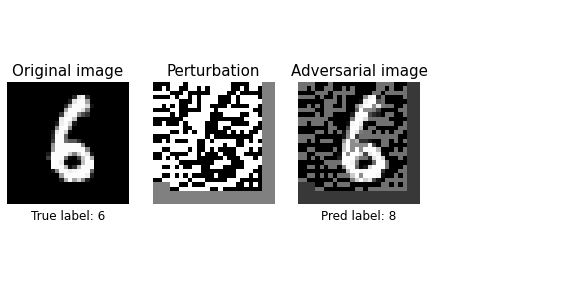

<Figure size 1440x144 with 0 Axes>

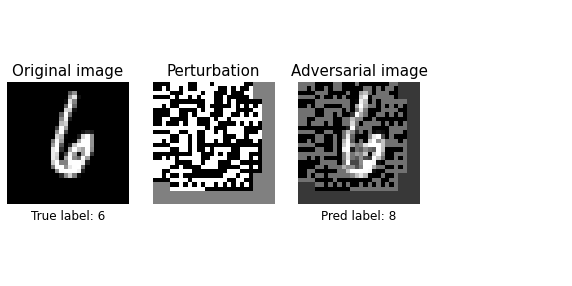

<Figure size 1440x144 with 0 Axes>

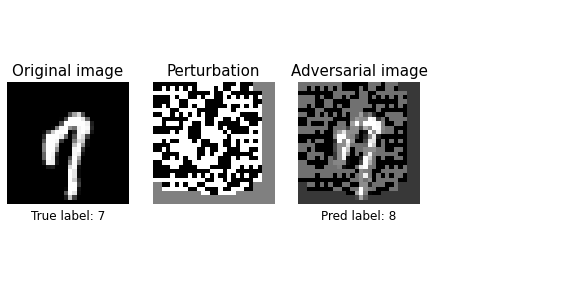

<Figure size 1440x144 with 0 Axes>

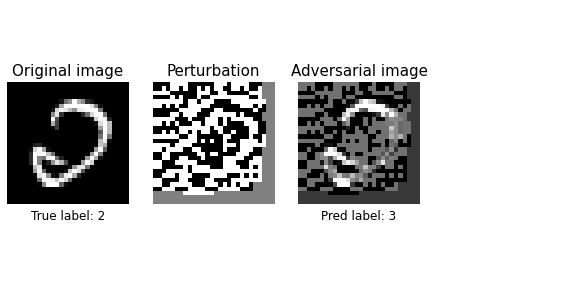

<Figure size 1440x144 with 0 Axes>

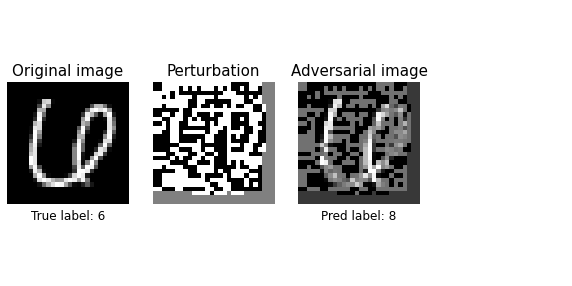

<Figure size 1440x144 with 0 Axes>

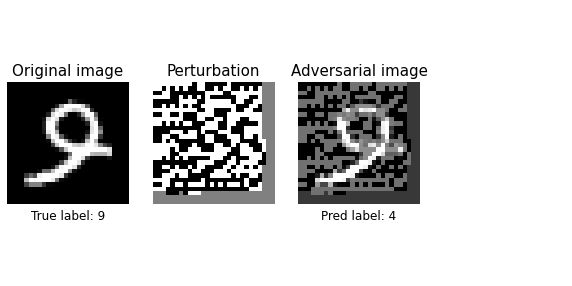

<Figure size 1440x144 with 0 Axes>

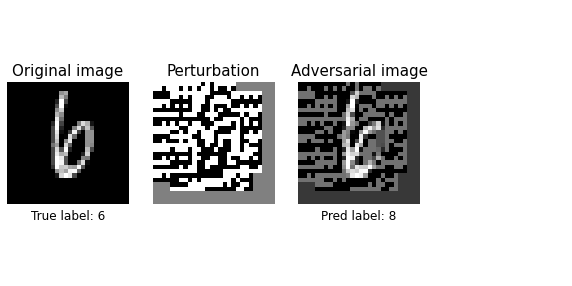

<Figure size 1440x144 with 0 Axes>

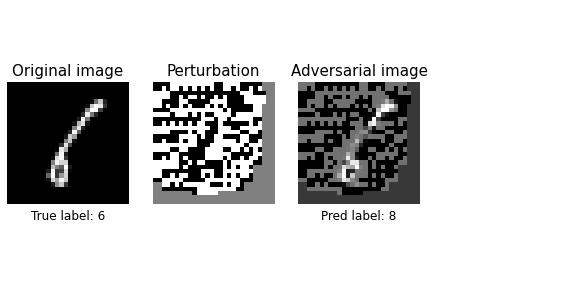

<Figure size 1440x144 with 0 Axes>

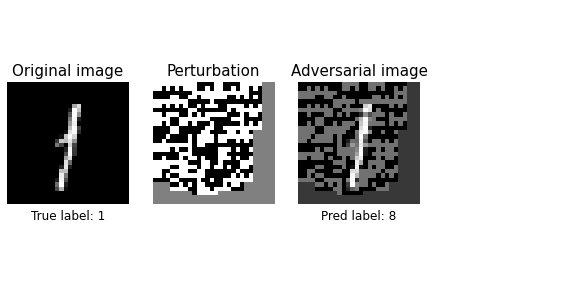

<Figure size 1440x144 with 0 Axes>

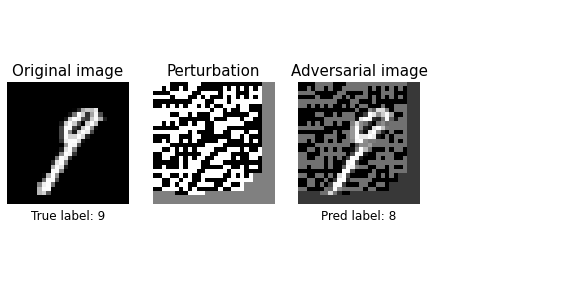

<Figure size 1440x144 with 0 Axes>

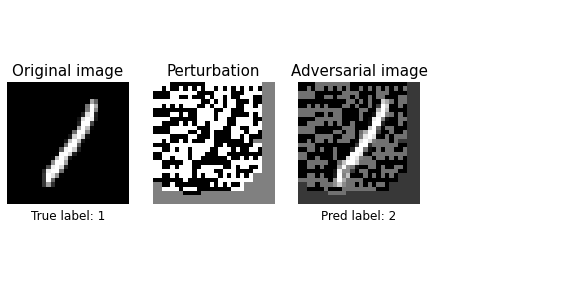

<Figure size 1440x144 with 0 Axes>

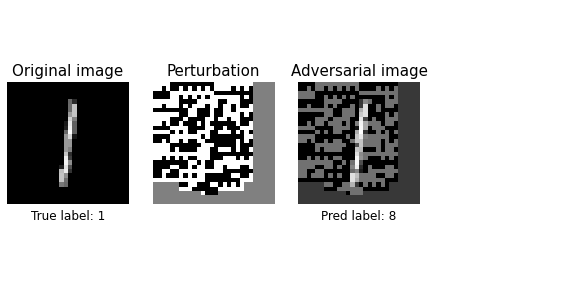

<Figure size 1440x144 with 0 Axes>

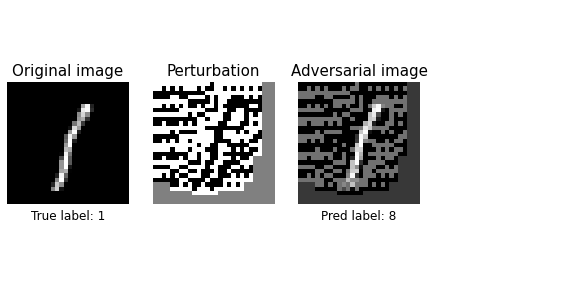

<Figure size 1440x144 with 0 Axes>

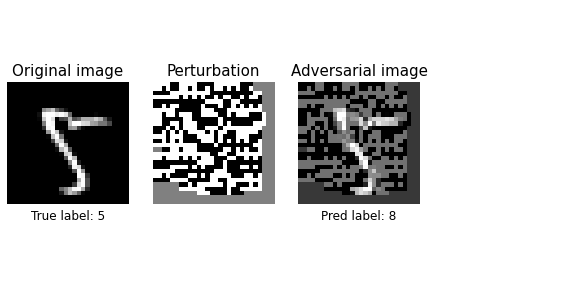

<Figure size 1440x144 with 0 Axes>

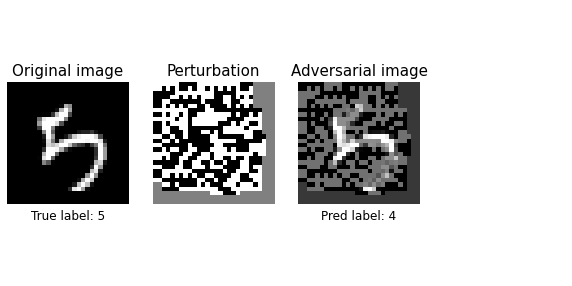

<Figure size 1440x144 with 0 Axes>

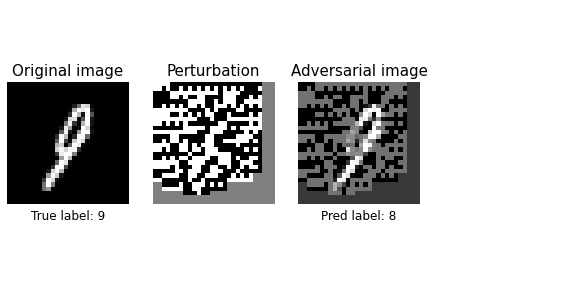

<Figure size 1440x144 with 0 Axes>

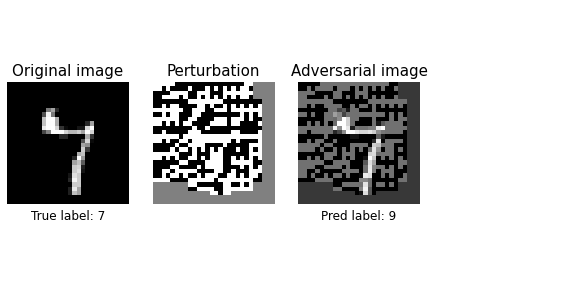

<Figure size 1440x144 with 0 Axes>

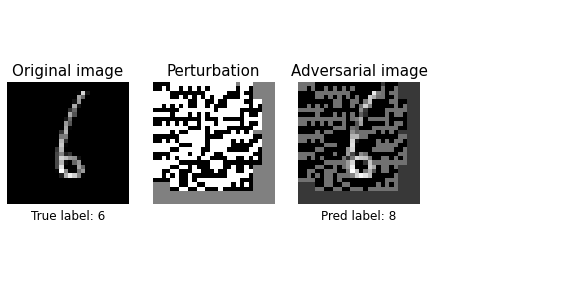

<Figure size 1440x144 with 0 Axes>

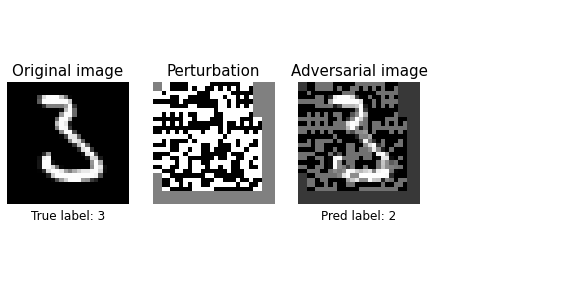

<Figure size 1440x144 with 0 Axes>

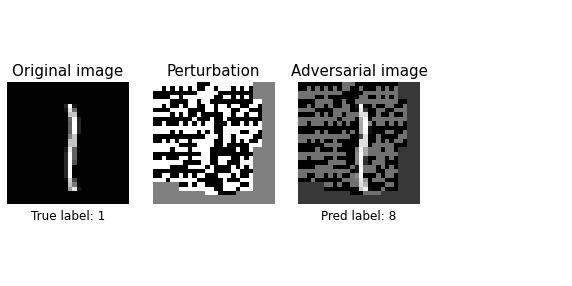

<Figure size 1440x144 with 0 Axes>

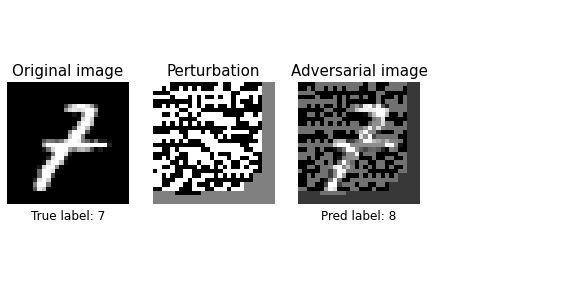

<Figure size 1440x144 with 0 Axes>

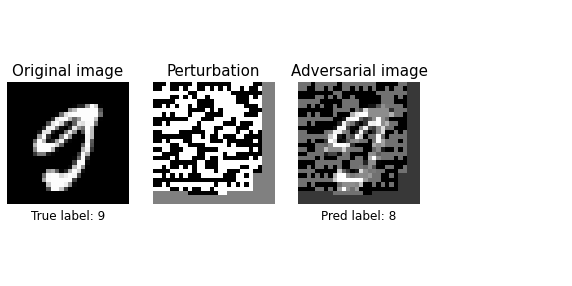

<Figure size 1440x144 with 0 Axes>

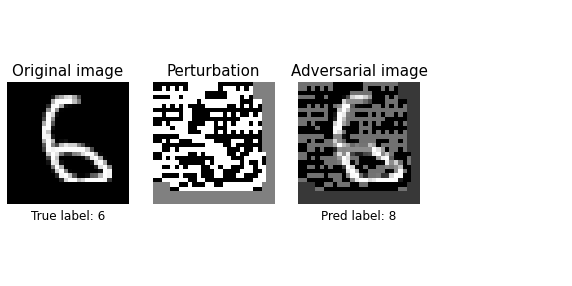

<Figure size 1440x144 with 0 Axes>

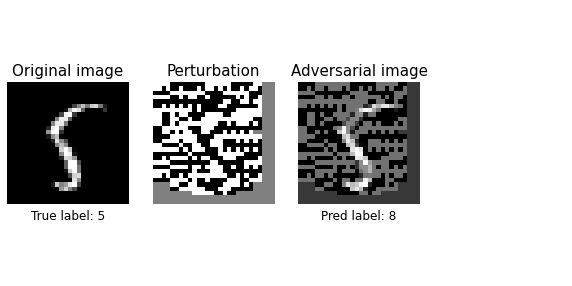

<Figure size 1440x144 with 0 Axes>

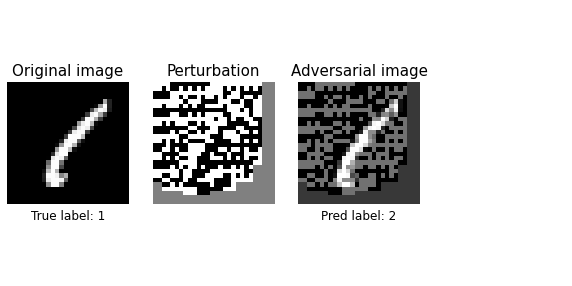

<Figure size 1440x144 with 0 Axes>

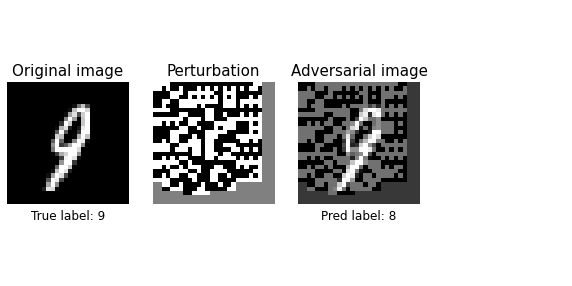

<Figure size 1440x144 with 0 Axes>

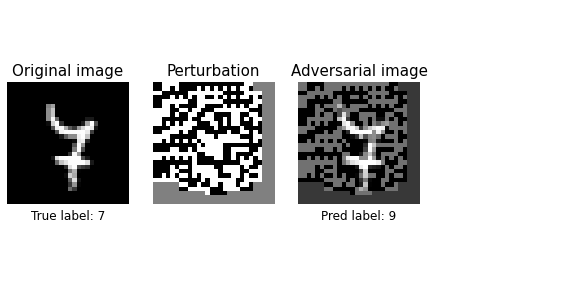

<Figure size 1440x144 with 0 Axes>

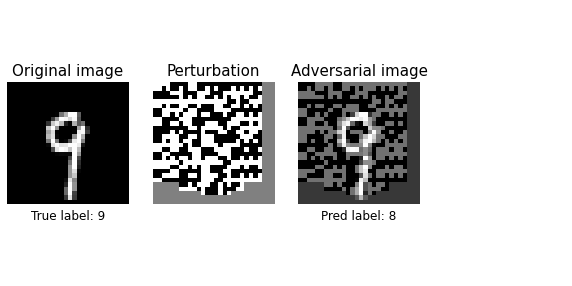

<Figure size 1440x144 with 0 Axes>

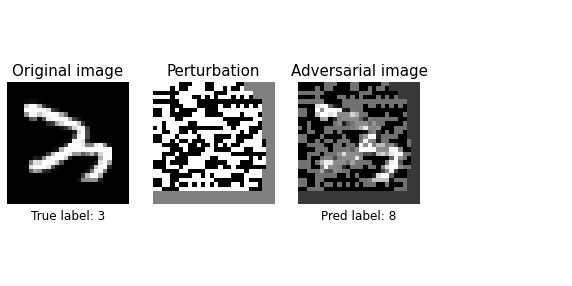

<Figure size 1440x144 with 0 Axes>

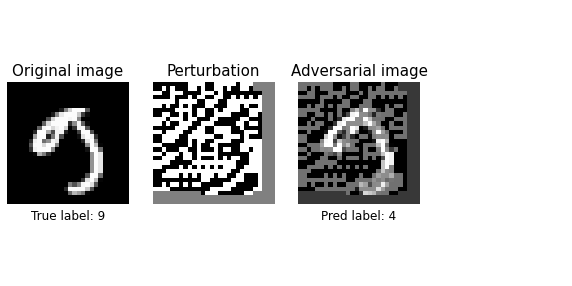

<Figure size 1440x144 with 0 Axes>

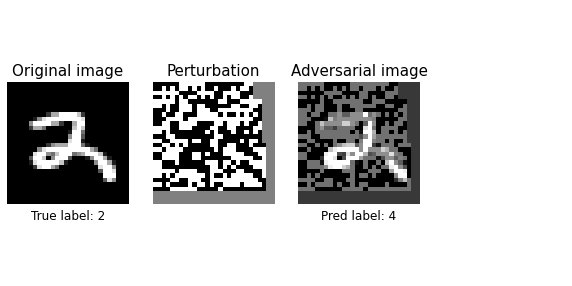

<Figure size 1440x144 with 0 Axes>

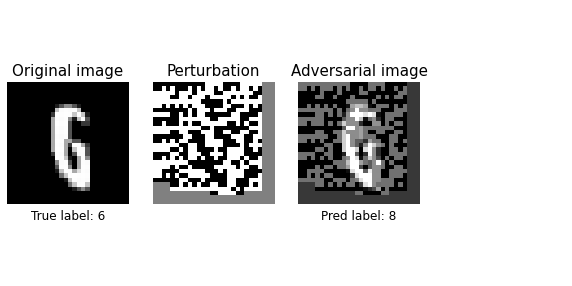

<Figure size 1440x144 with 0 Axes>

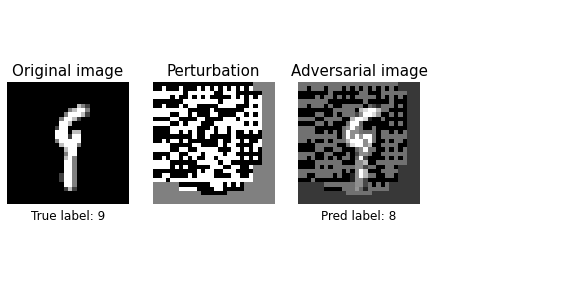

<Figure size 1440x144 with 0 Axes>

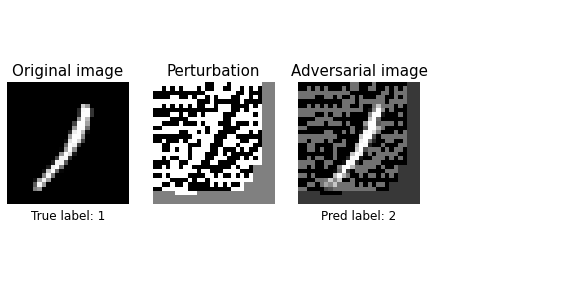

<Figure size 1440x144 with 0 Axes>

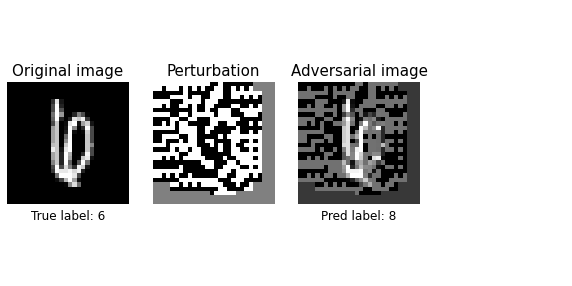

<Figure size 1440x144 with 0 Axes>

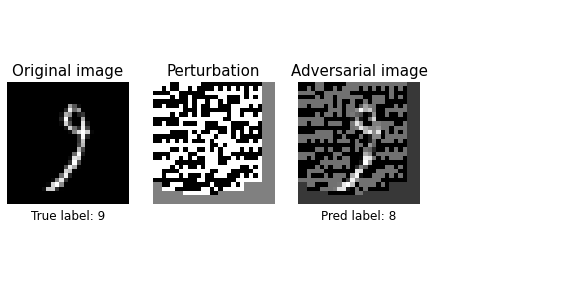

<Figure size 1440x144 with 0 Axes>

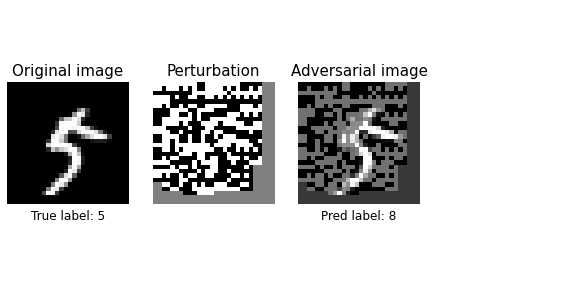

<Figure size 1440x144 with 0 Axes>

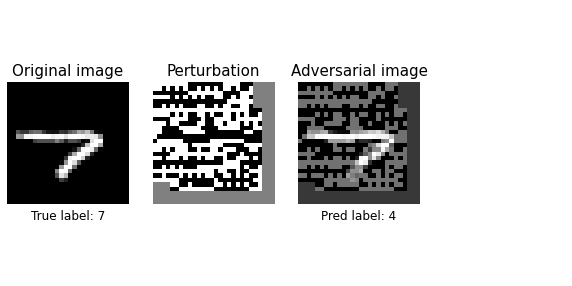

<Figure size 1440x144 with 0 Axes>

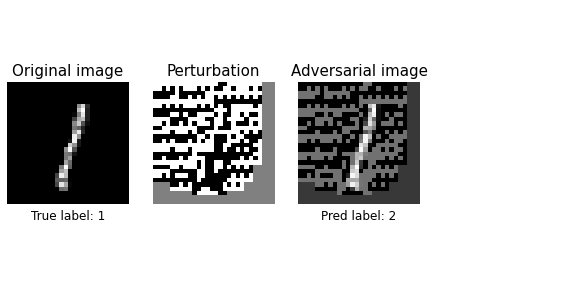

<Figure size 1440x144 with 0 Axes>

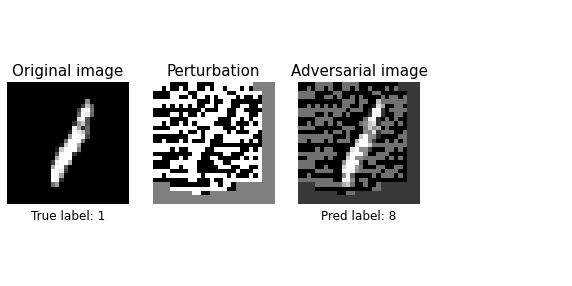

<Figure size 1440x144 with 0 Axes>

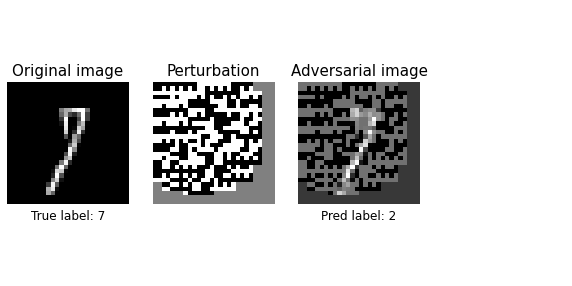

<Figure size 1440x144 with 0 Axes>

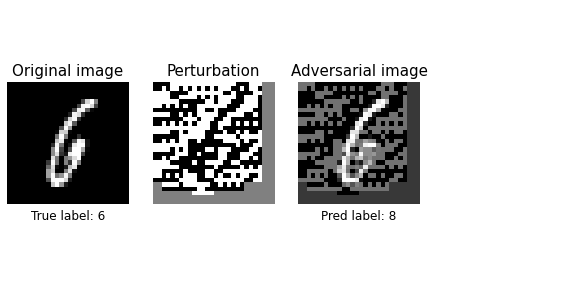

<Figure size 1440x144 with 0 Axes>

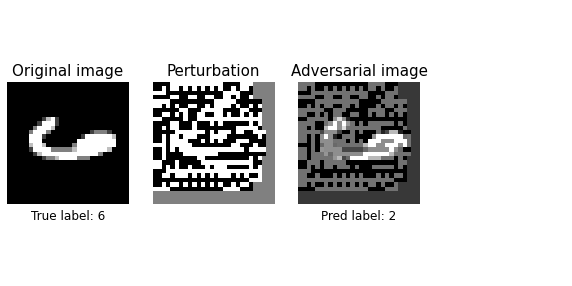

<Figure size 1440x144 with 0 Axes>

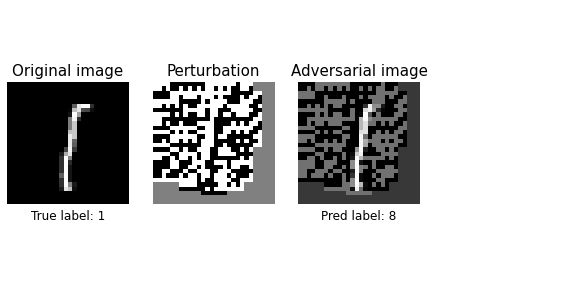

<Figure size 1440x144 with 0 Axes>

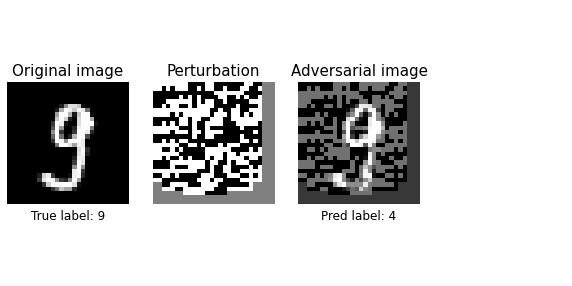

<Figure size 1440x144 with 0 Axes>

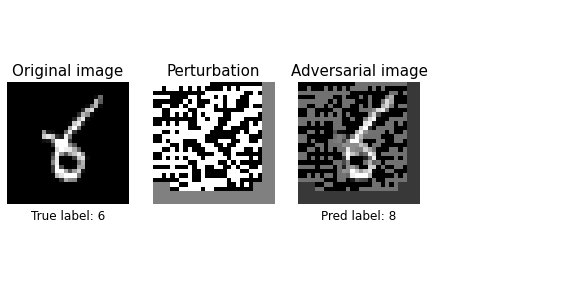

<Figure size 1440x144 with 0 Axes>

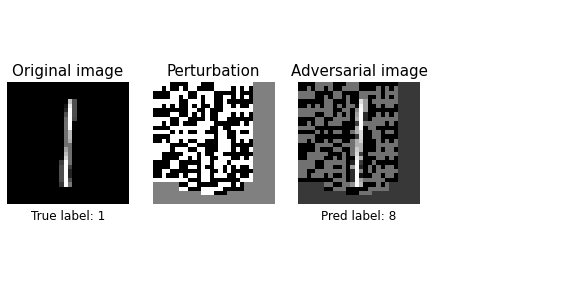

<Figure size 1440x144 with 0 Axes>

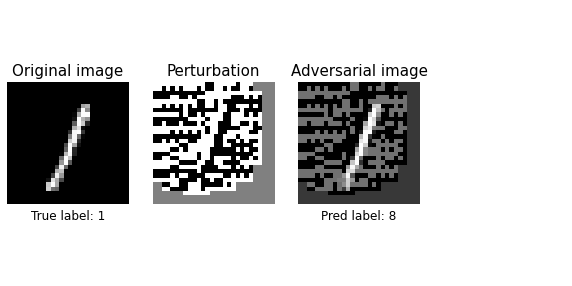

<Figure size 1440x144 with 0 Axes>

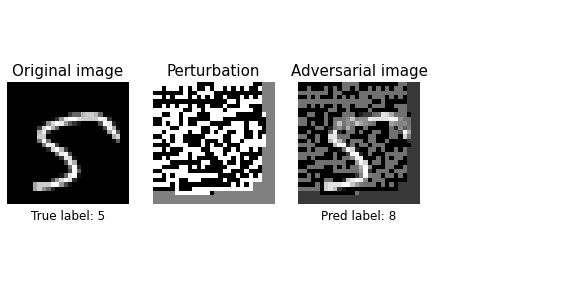

<Figure size 1440x144 with 0 Axes>

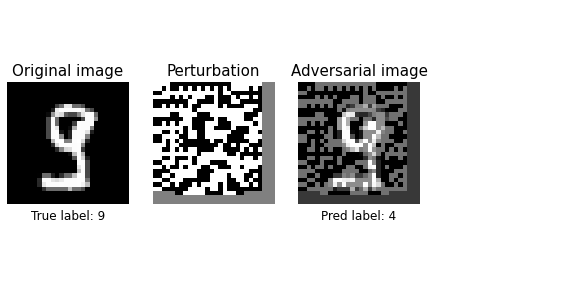

<Figure size 1440x144 with 0 Axes>

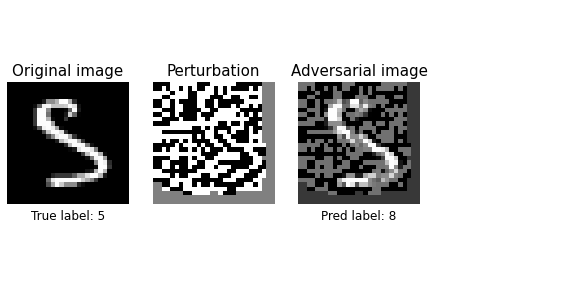

<Figure size 1440x144 with 0 Axes>

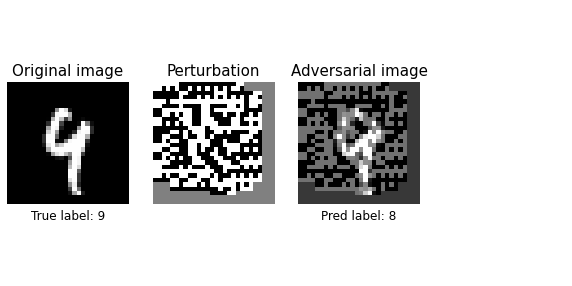

<Figure size 1440x144 with 0 Axes>

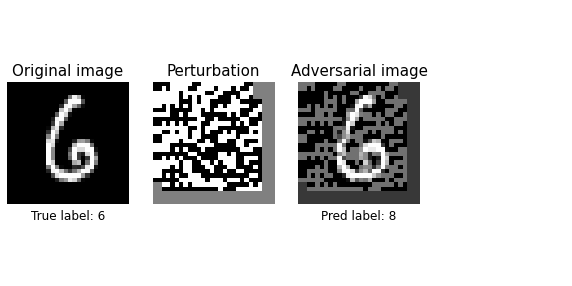

<Figure size 1440x144 with 0 Axes>

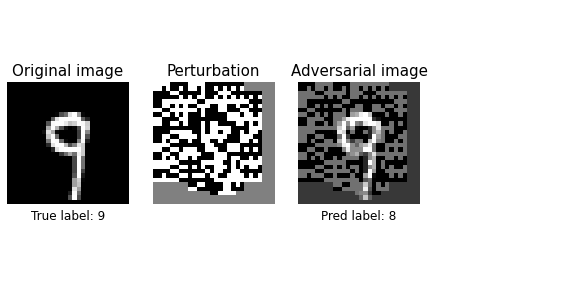

<Figure size 1440x144 with 0 Axes>

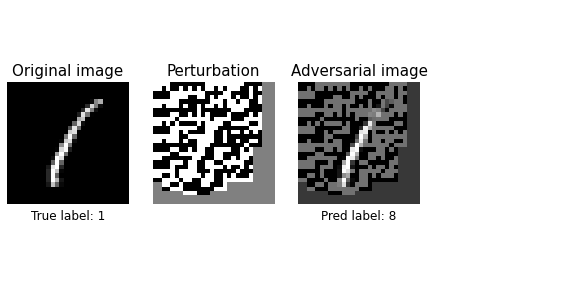

<Figure size 1440x144 with 0 Axes>

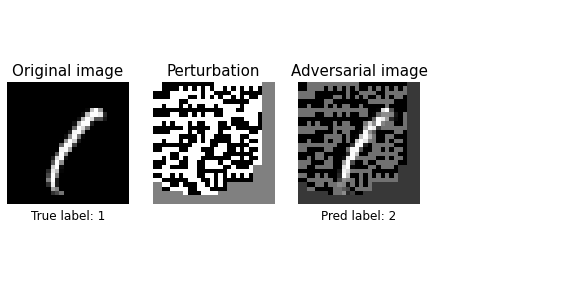

<Figure size 1440x144 with 0 Axes>

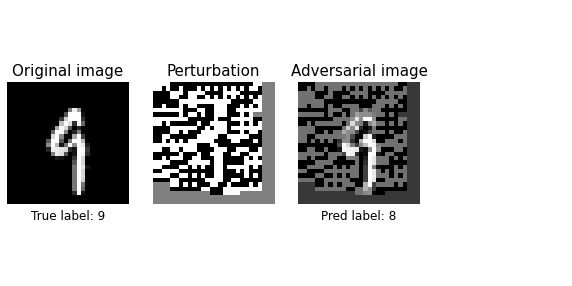

<Figure size 1440x144 with 0 Axes>

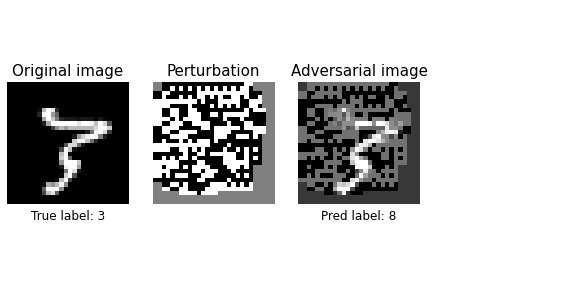

<Figure size 1440x144 with 0 Axes>

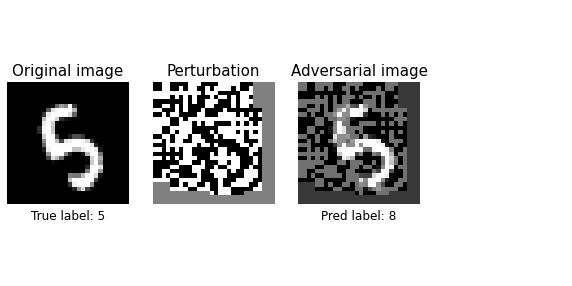

<Figure size 1440x144 with 0 Axes>

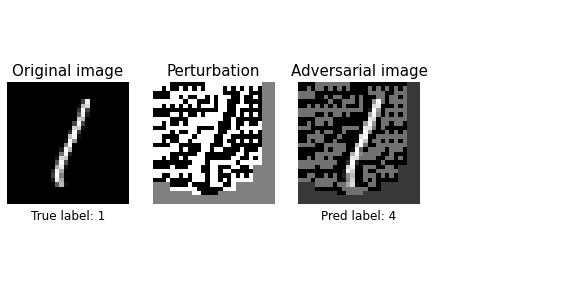

<Figure size 1440x144 with 0 Axes>

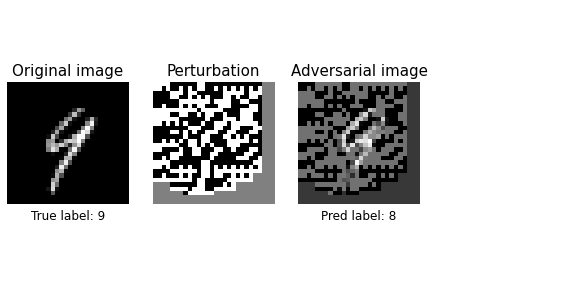

<Figure size 1440x144 with 0 Axes>

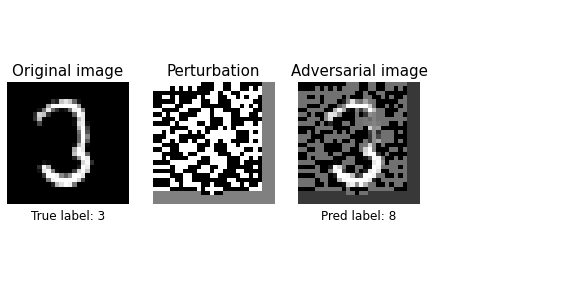

<Figure size 1440x144 with 0 Axes>

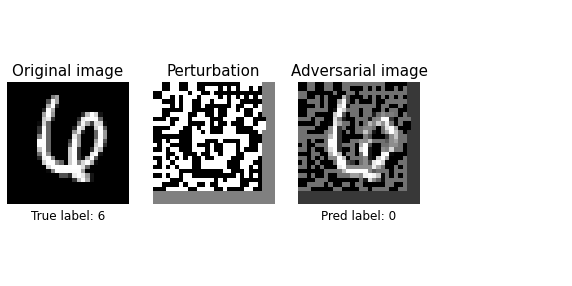

<Figure size 1440x144 with 0 Axes>

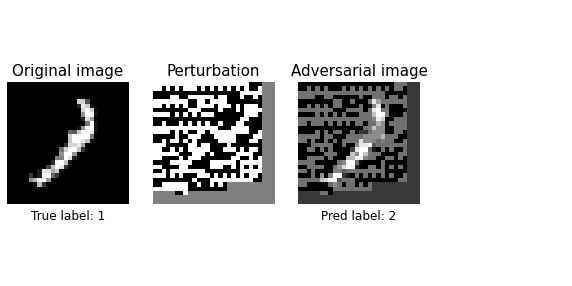

<Figure size 1440x144 with 0 Axes>

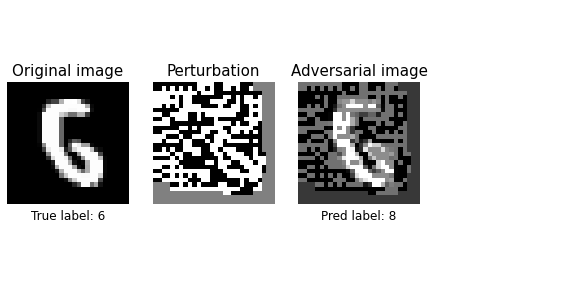

<Figure size 1440x144 with 0 Axes>

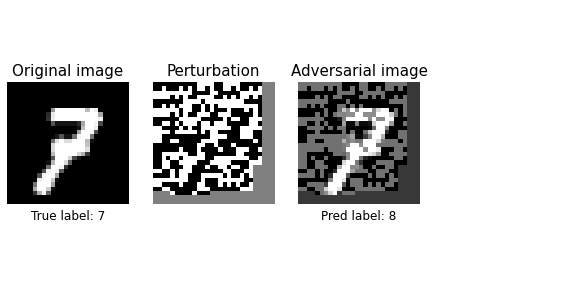

<Figure size 1440x144 with 0 Axes>

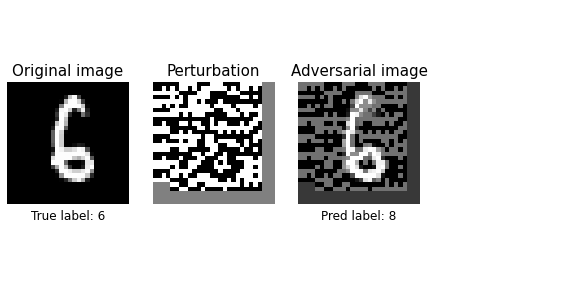

<Figure size 1440x144 with 0 Axes>

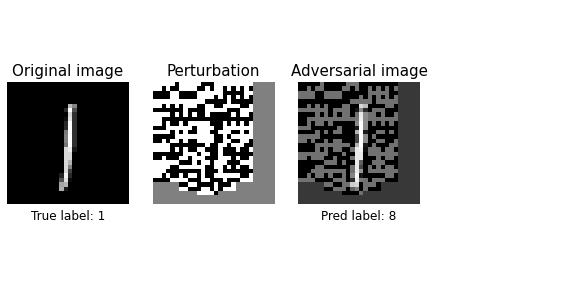

<Figure size 1440x144 with 0 Axes>

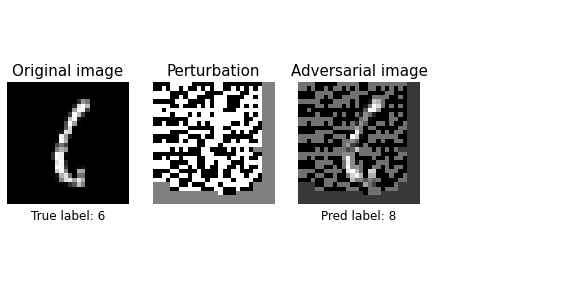

<Figure size 1440x144 with 0 Axes>

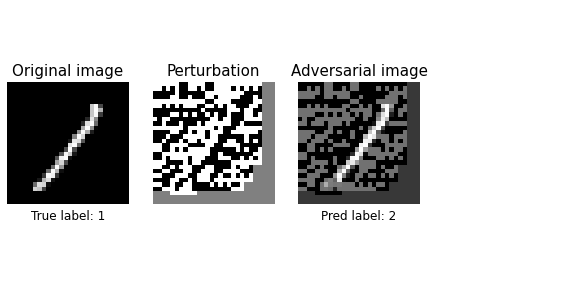

<Figure size 1440x144 with 0 Axes>

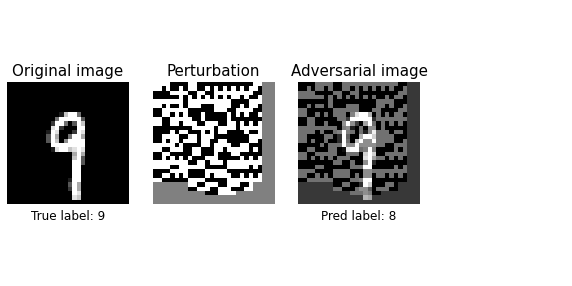

<Figure size 1440x144 with 0 Axes>

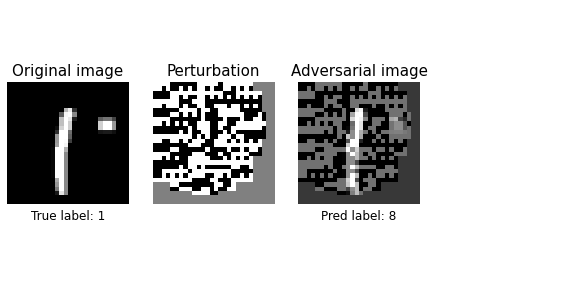

<Figure size 1440x144 with 0 Axes>

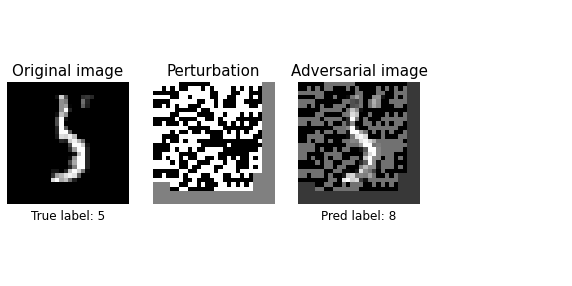

<Figure size 1440x144 with 0 Axes>

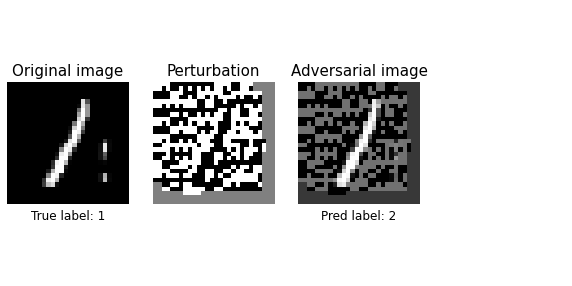

<Figure size 1440x144 with 0 Axes>

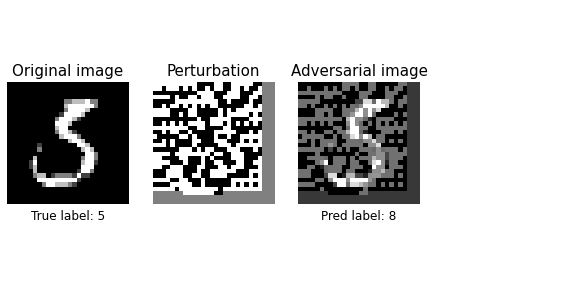

<Figure size 1440x144 with 0 Axes>

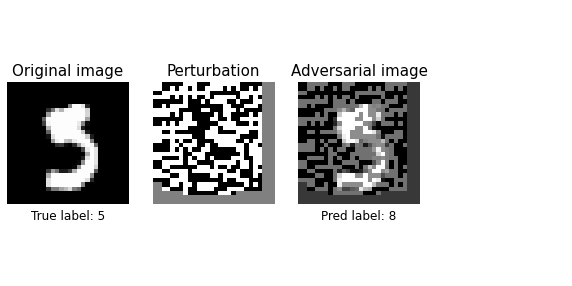

<Figure size 1440x144 with 0 Axes>

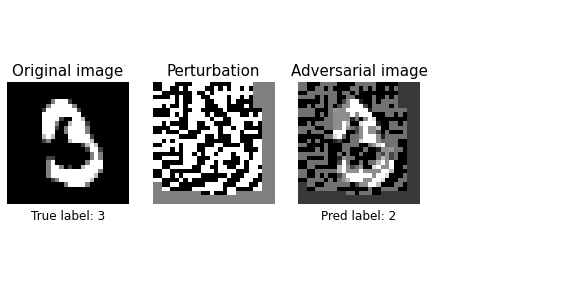

<Figure size 1440x144 with 0 Axes>

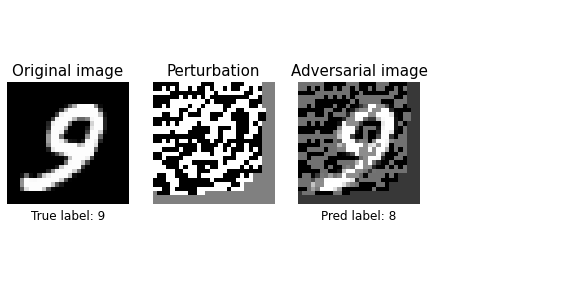

<Figure size 1440x144 with 0 Axes>

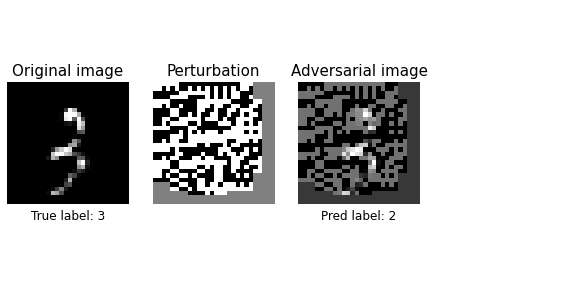

<Figure size 1440x144 with 0 Axes>

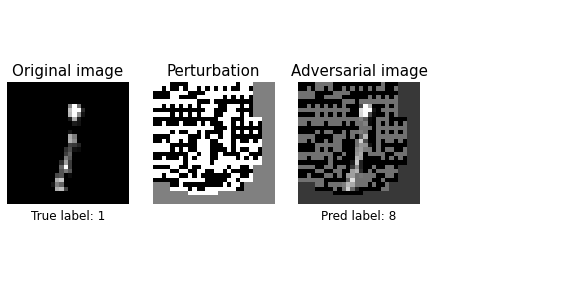

<Figure size 1440x144 with 0 Axes>

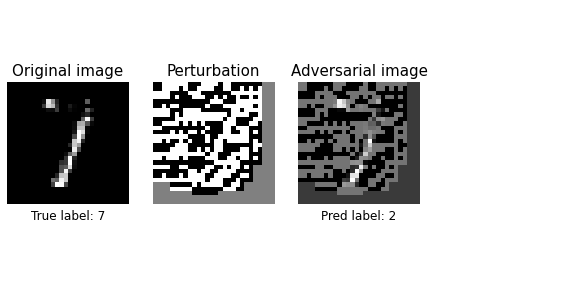

<Figure size 1440x144 with 0 Axes>

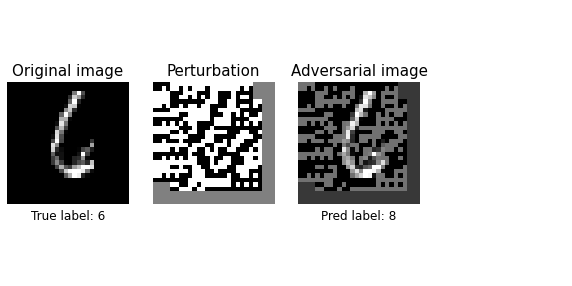

<Figure size 1440x144 with 0 Axes>

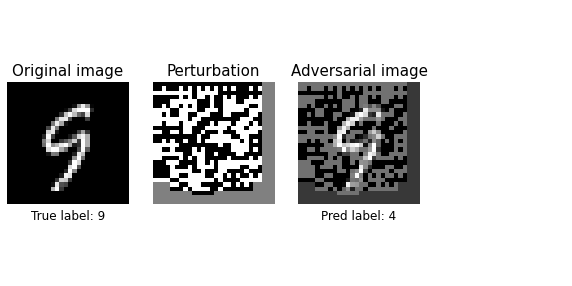

<Figure size 1440x144 with 0 Axes>

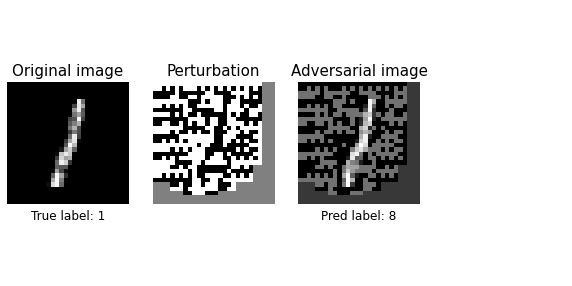

<Figure size 1440x144 with 0 Axes>

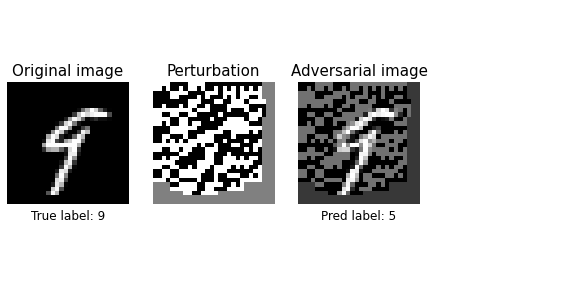

<Figure size 1440x144 with 0 Axes>

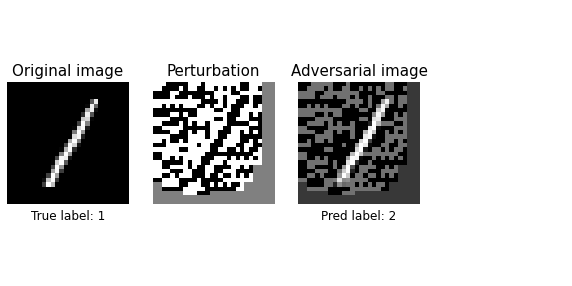

<Figure size 1440x144 with 0 Axes>

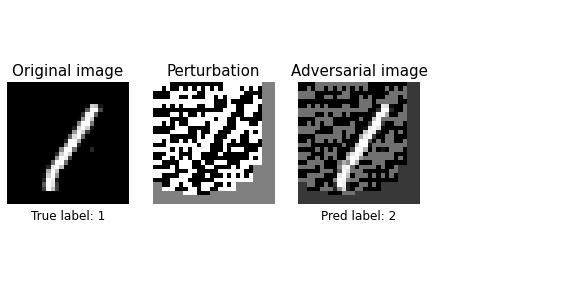

<Figure size 1440x144 with 0 Axes>

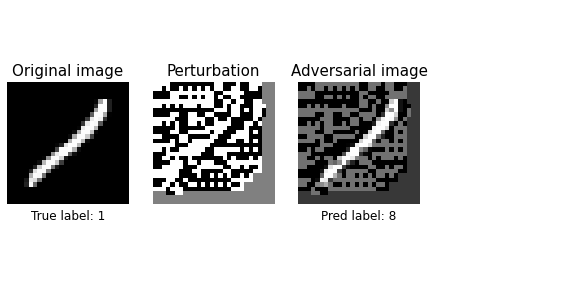

<Figure size 1440x144 with 0 Axes>

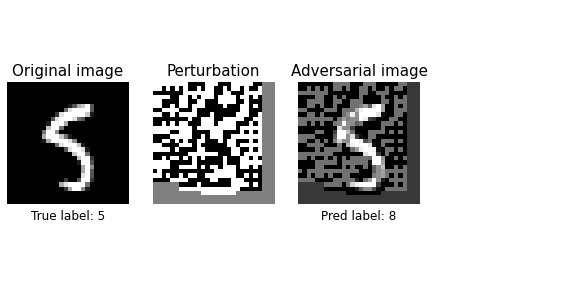

<Figure size 1440x144 with 0 Axes>

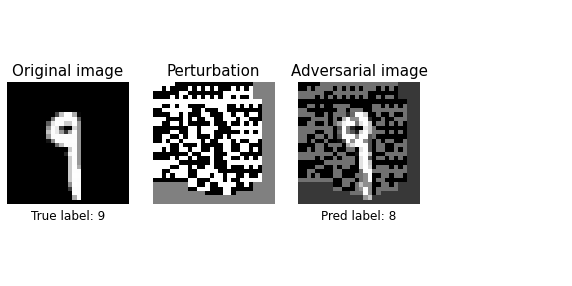

<Figure size 1440x144 with 0 Axes>

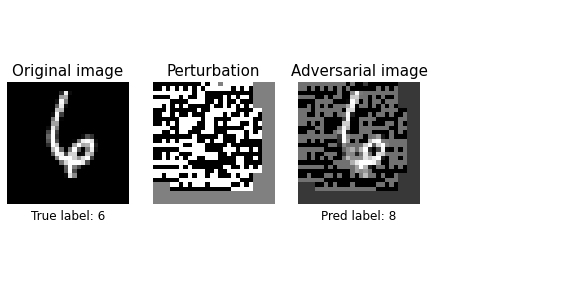

<Figure size 1440x144 with 0 Axes>

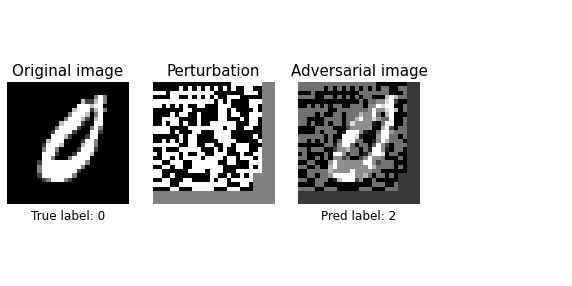

<Figure size 1440x144 with 0 Axes>

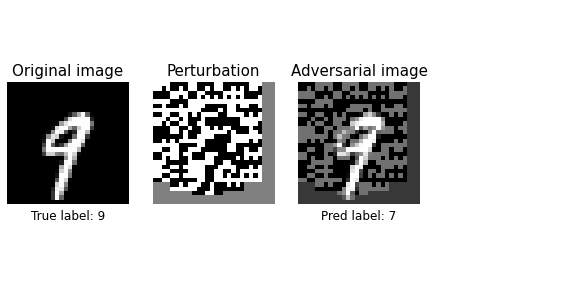

<Figure size 1440x144 with 0 Axes>

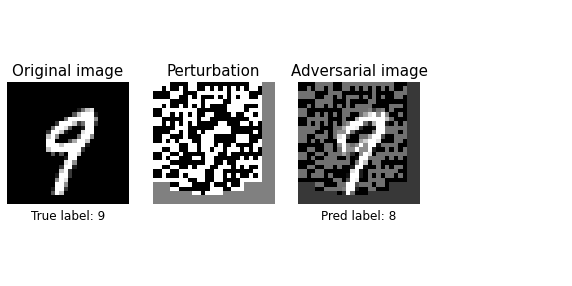

<Figure size 1440x144 with 0 Axes>

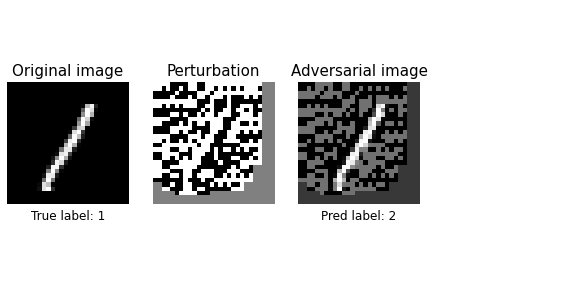

<Figure size 1440x144 with 0 Axes>

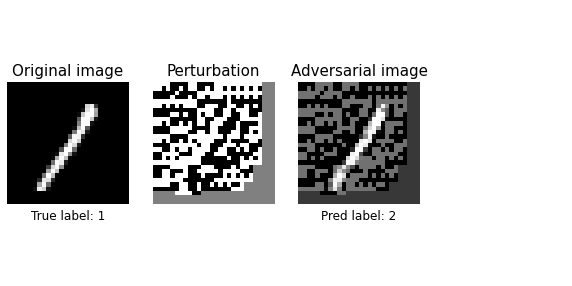

<Figure size 1440x144 with 0 Axes>

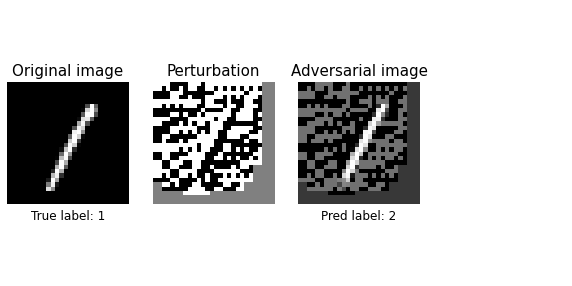

<Figure size 1440x144 with 0 Axes>

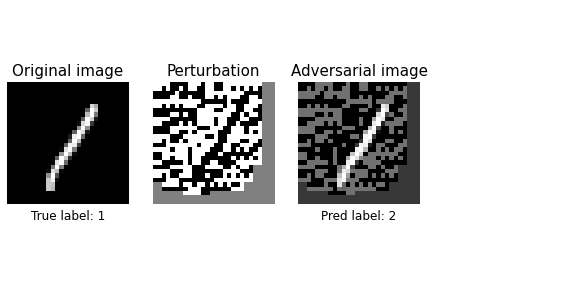

<Figure size 1440x144 with 0 Axes>

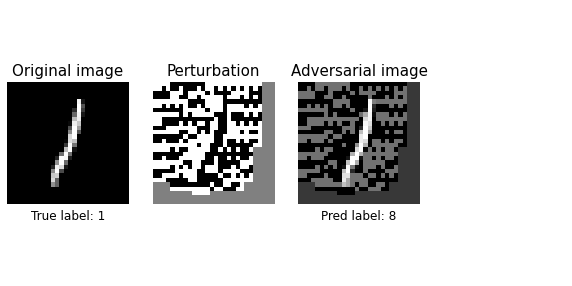

<Figure size 1440x144 with 0 Axes>

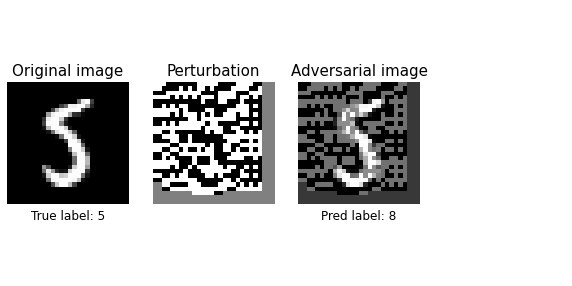

<Figure size 1440x144 with 0 Axes>

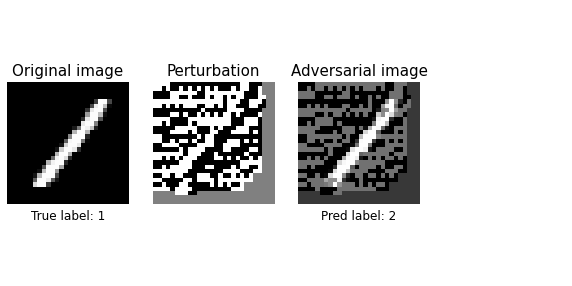

<Figure size 1440x144 with 0 Axes>

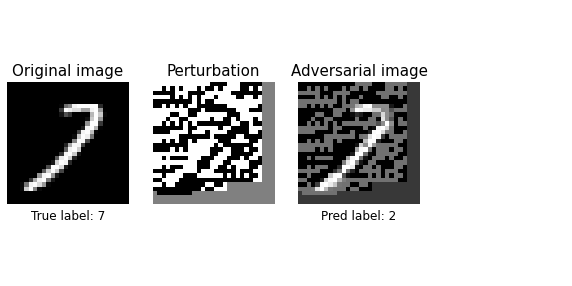

<Figure size 1440x144 with 0 Axes>

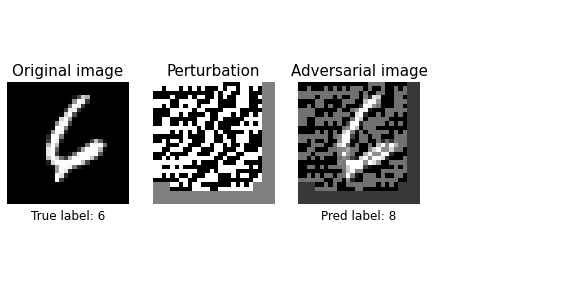

<Figure size 1440x144 with 0 Axes>

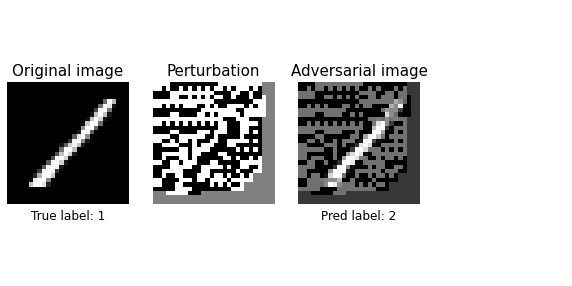

<Figure size 1440x144 with 0 Axes>

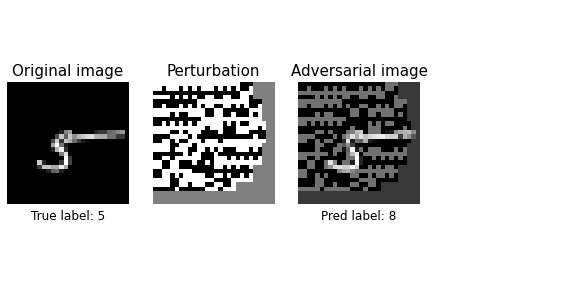

<Figure size 1440x144 with 0 Axes>

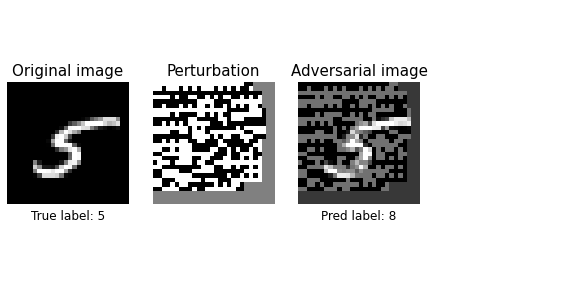

<Figure size 1440x144 with 0 Axes>

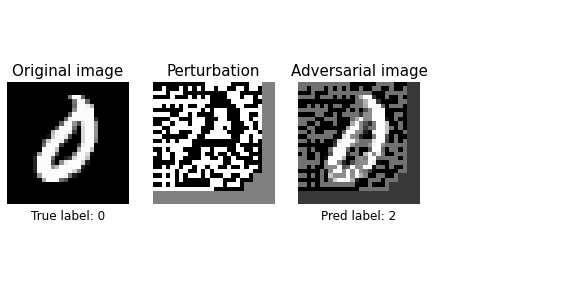

<Figure size 1440x144 with 0 Axes>

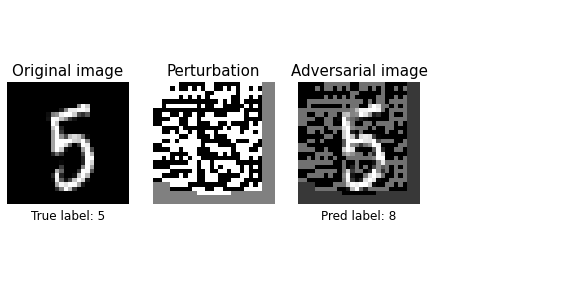

<Figure size 1440x144 with 0 Axes>

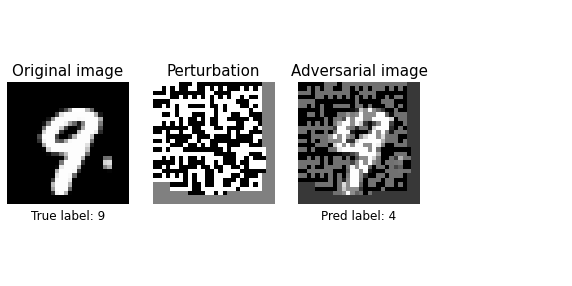

<Figure size 1440x144 with 0 Axes>

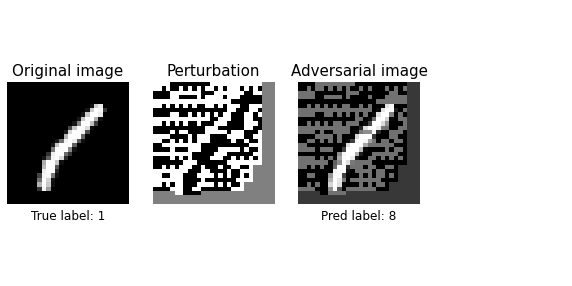

<Figure size 1440x144 with 0 Axes>

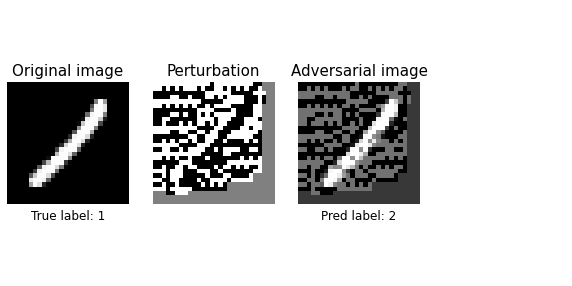

<Figure size 1440x144 with 0 Axes>

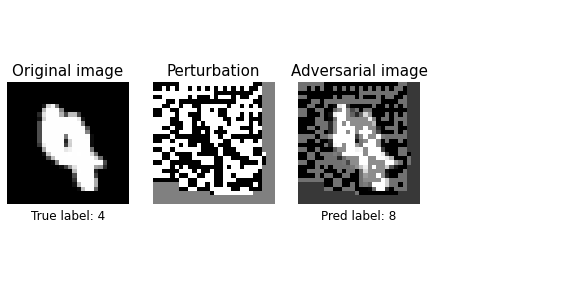

<Figure size 1440x144 with 0 Axes>

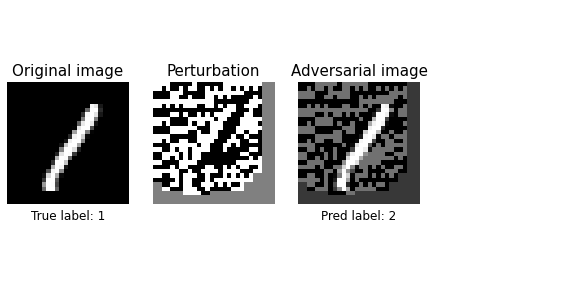

<Figure size 1440x144 with 0 Axes>

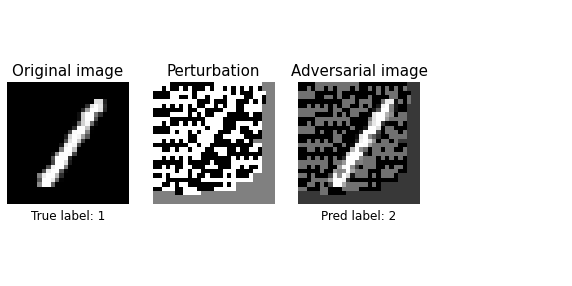

<Figure size 1440x144 with 0 Axes>

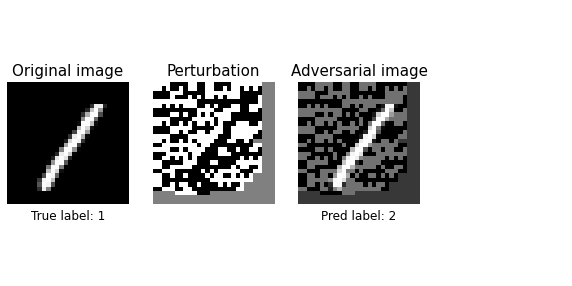

<Figure size 1440x144 with 0 Axes>

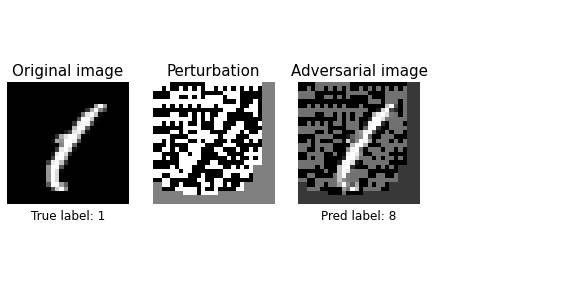

<Figure size 1440x144 with 0 Axes>

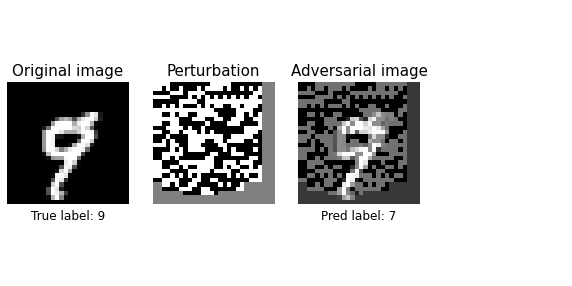

<Figure size 1440x144 with 0 Axes>

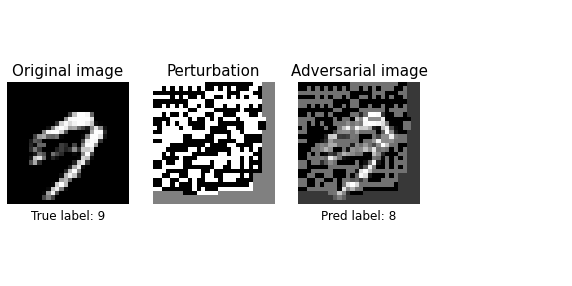

<Figure size 1440x144 with 0 Axes>

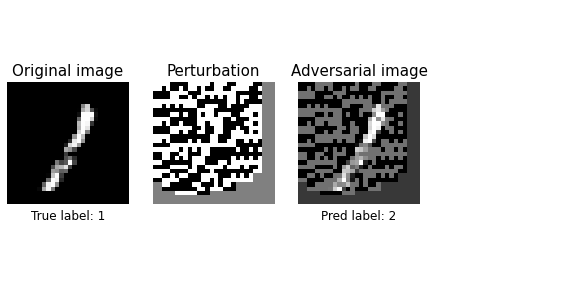

<Figure size 1440x144 with 0 Axes>

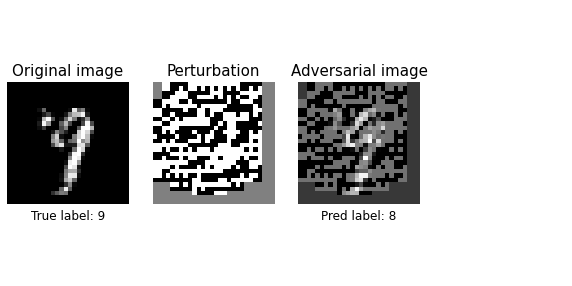

<Figure size 1440x144 with 0 Axes>

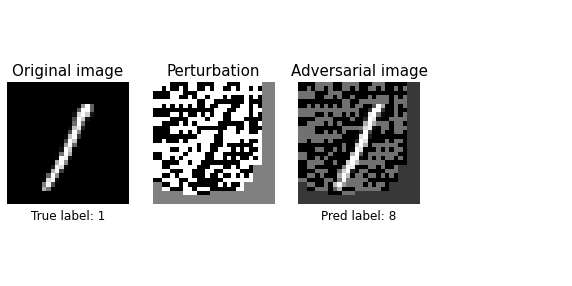

<Figure size 1440x144 with 0 Axes>

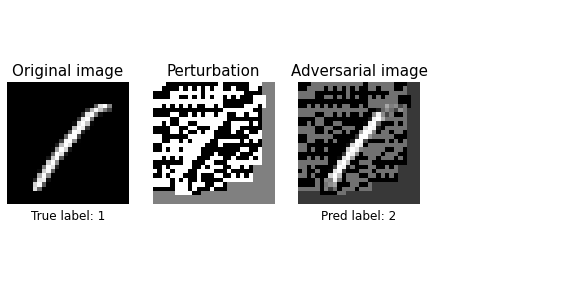

<Figure size 1440x144 with 0 Axes>

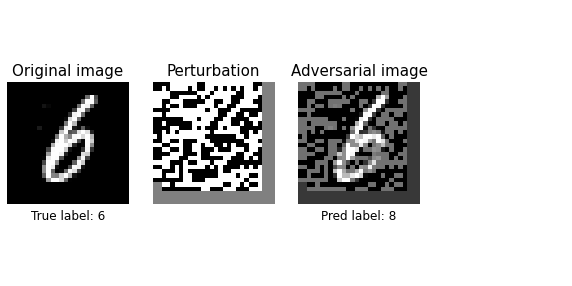

<Figure size 1440x144 with 0 Axes>

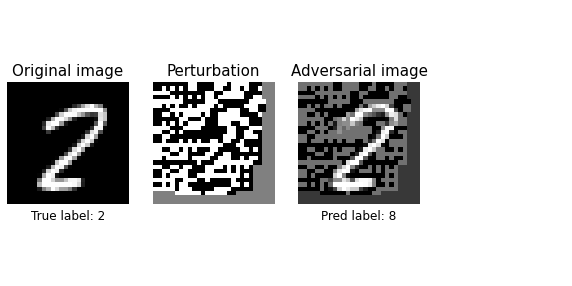

<Figure size 1440x144 with 0 Axes>

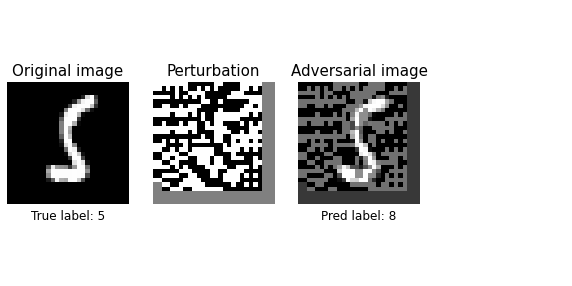

<Figure size 1440x144 with 0 Axes>

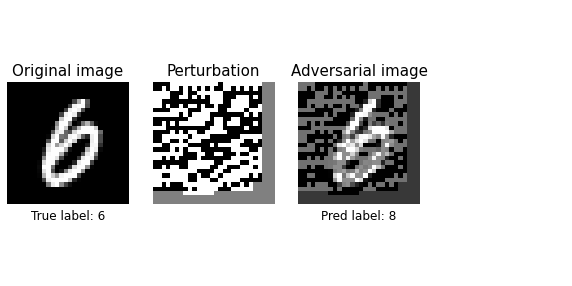

<Figure size 1440x144 with 0 Axes>

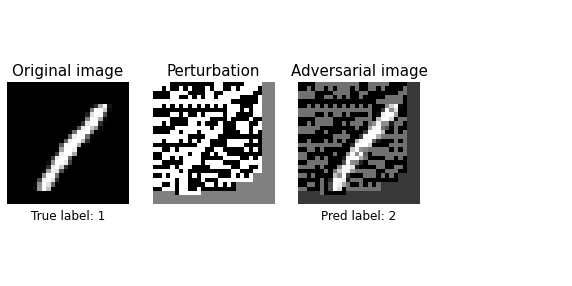

<Figure size 1440x144 with 0 Axes>

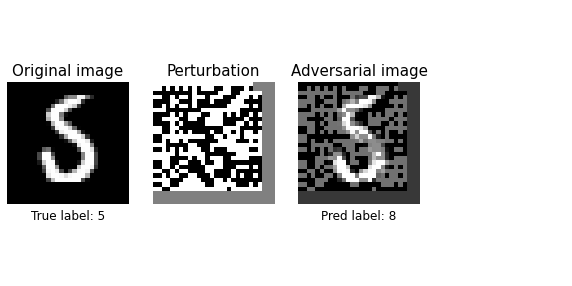

<Figure size 1440x144 with 0 Axes>

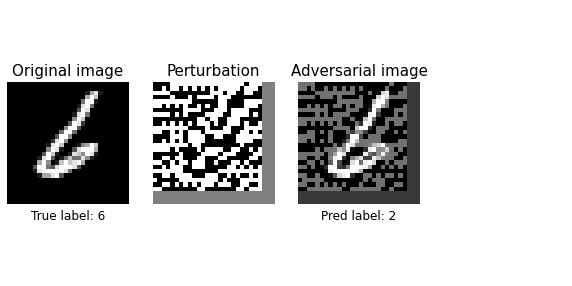

<Figure size 1440x144 with 0 Axes>

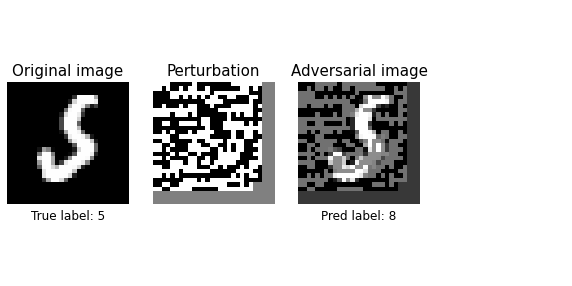

In [348]:
for idx in x_x_adv_imgs:
    display_one_pair(x_test[idx], x_test_bim_imgs[idx], x_test_bim_perts[idx], y_test[idx], test_bim_preds[idx])

ERROR! Session/line number was not unique in database. History logging moved to new session 546


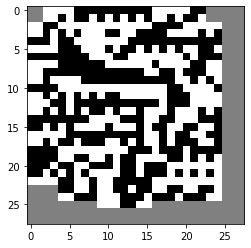

In [530]:
plt.imshow(x_test_bim_perts[0].reshape(28,28))

### OneStepLeastLikely attack 

In [201]:
def create_perturbation_oneStep(model_fn, input_img, eps):
    
    loss_func = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE или SparseCategoricalCrossentropy
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        #compute least likely predicted label for clean image
        y_ll = tf.math.argmin(prediction, 1)
        loss = loss_func(y_ll, prediction)
        
    #Get the gradients for the loss
    gradient = gt.gradient(loss, input_img)
    perturbation = eps*tf.sign(gradient)
    
    return perturbation

In [178]:
def OneStepLeastLikely(model_fn, dataset_name, epsilon):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]
        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
       
        perturbations[i] = create_perturbation_oneStep(model_fn, image, epsilon)
        
        adv_imgs[i] = image - perturbations[i]
    #return perturbations
    return perturbations, adv_imgs

In [404]:
name = 'test'
x_test_onest_perts, x_test_onest_imgs = OneStepLeastLikely(model, name, epsilon=0.1)


In [405]:
test_onest_preds = model.predict(x_test_onest_imgs)

In [406]:
onest_eval_defaut_model = model.evaluate(x_test_onest_imgs, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [407]:
print(f'Default model on onesteplesslikely_adv_images:\n loss: {onest_eval_defaut_model[0]} mae: {onest_eval_defaut_model[1]} accuracy: {onest_eval_defaut_model[2]}') 


Default model on onesteplesslikely_adv_images:
 loss: 0.2066778824582696 mae: 0.0200052447617054 accuracy: 0.9322999715805054


In [567]:
x_x_adv_imgs_onest = find_diff_classes(y_test, test_onest_preds, n=100)
x_x_adv_imgs_onest

[4, 8, 18, 20, 42, 59, 67, 92, 95]

<Figure size 1440x144 with 0 Axes>

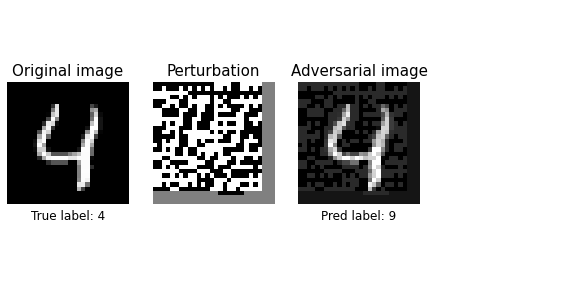

<Figure size 1440x144 with 0 Axes>

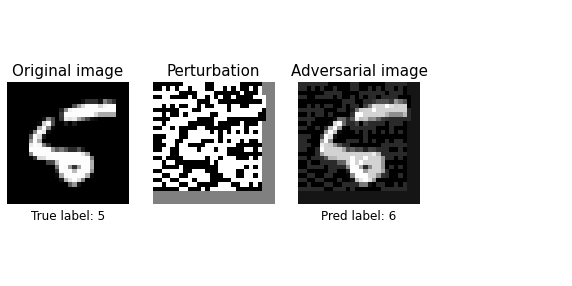

In [409]:
# оставить eps=0.3
for idx in x_x_adv_imgs_onest:
    display_one_pair(x_test[idx], x_test_onest_imgs[idx], x_test_onest_perts[idx], y_test[idx], test_onest_preds[idx])

### func for display a quad: Original+Perturbation+Adversarial+Cleaned image

In [306]:
#display one pair of images: original and adversarial with their labels
def display_quad(x, x_adv, perturbation, x_cleaned, y_true, y_pred_adv, y_pred_clean):
    
    plt.figure(figsize=(20,2))
    fig, ax =plt.subplots(1, 5, figsize=(10,5))
    
    ax[0].imshow(x)
    ax[0].axis('off')
    ax[0].set_title('Original', fontsize=15)
    ax[0].text(0.5, -0.13, f'True label: {np.argmax(y_true)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[1].imshow(perturbation)
    ax[1].axis('off')
    ax[1].set_title('Perturbation', fontsize=15)
    
    
    ax[2].imshow(x_adv)
    ax[2].axis('off')
    ax[2].set_title('Adversarial', fontsize=15)
    ax[2].text(2.9, -0.13, f'Pred label: {np.argmax(y_pred_adv)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[3].imshow(x_adv)
    ax[3].axis('off')
    ax[3].set_title('Cleaned', fontsize=15)
    ax[3].text(4.2, -0.13, f'Pred label: {np.argmax(y_pred_clean)}', size=12,ha='center', transform=ax[0].transAxes)
    
    ax[4].axis('off')
    plt.show()

### Dense AUTOENCODER

In [98]:
x_train[0].shape

(28, 28, 1)

In [313]:
(x_train_dense, y_train_dense), (x_test_dense, y_test_dense) = mnist.load_data(mnist_path)

In [314]:
x_train_dense.shape, y_train_dense.shape

((60000, 28, 28), (60000,))

In [315]:
#np.prod(x_train_dense.shape[1:])

In [316]:
x_train_dense = x_train_dense.astype('float32')/255.0
x_test_dense = x_test_dense.astype('float32')/255.0

x_train_dense = x_train_dense.reshape((len(x_train_dense), np.prod(x_train_dense.shape[1:])))
x_test_dense = x_test_dense.reshape((len(x_test_dense), np.prod(x_test_dense.shape[1:])))
x_train_dense.shape, y_train_dense.shape

((60000, 784), (60000,))

In [317]:
input_shape_dense=x_train_dense[0].shape

In [318]:
model_autoencoder_basic = Sequential([
    #encoder
    Dense(256, activation = 'relu', input_shape=input_shape_dense),
    #Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    
    #decoder
    Dense(128, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(28*28, activation = 'sigmoid')
])

In [588]:
model_autoencoder_basic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
__________________________________________________

In [534]:
tf.keras.utils.plot_model(model_autoencoder_basic, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [320]:
model_autoencoder_basic.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [321]:
model_autoencoder_basic.fit(x_train_dense, x_train_dense, 
                           epochs=n_epochs,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           validation_data=(x_test_dense,x_test_dense))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


60000/60000 [==============================] - 21s 344us/sample - loss: 0.0386 - mae: 0.0882 - val_loss: 0.0186 - val_mae: 0.0521
Epoch 2/30
60000/60000 [==============================] - 19s 324us/sample - loss: 0.0156 - mae: 0.0456 - val_loss: 0.0128 - val_mae: 0.0399
Epoch 3/30
60000/60000 [==============================] - 19s 325us/sample - loss: 0.0120 - mae: 0.0380 - val_loss: 0.0107 - val_mae: 0.0349
Epoch 4/30
60000/60000 [==============================] - 22s 359us/sample - loss: 0.0103 - mae: 0.0343 - val_loss: 0.0095 - val_mae: 0.0328
Epoch 5/30
60000/60000 [==============================] - 20s 327us/sample - loss: 0.0092 - mae: 0.0318 - val_loss: 0.0084 - val_mae: 0.0302
Epoch 6/30
60000/60000 [==============================] - 20s 339us/sample - loss: 0.0083 - mae: 0.0299 - val_loss: 0.0077 - val_mae: 0.0286
Epoch 7/30
60000/60000 [==============================] - 19s 320us/sample - loss: 0.0077 - mae: 0.0285 - val_loss: 0.0072 - val_mae: 0.0273
Epoch 8/30
60000/60000 [

In [322]:
if save_model==True:
    model_autoencoder_basic.save(os.path.join(save_path, 'dense_autoencoder_256-128-64'))
    model_autoencoder_basic.save_weights(os.path.join('weights',"dense_autoencoder_256-128-64.ckpt"))
    model_autoencoder_basic.save(os.path.join(save_path,'dense_autoencoder_256-128-64.h5'))

INFO:tensorflow:Assets written to: saved_models/dense_autoencoder_256-128-64/assets


INFO:tensorflow:Assets written to: saved_models/dense_autoencoder_256-128-64/assets


In [119]:
#load model
model_autoencoder_basic_l = tf.keras.models.load_model(os.path.join(save_path,'dense_autoencoder_256-128-64.h5'))
model_autoencoder_basic_l.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_40 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_41 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_42 (Dense)             (None, 784)               201488    
Total params: 526,032
Trainable params: 526,032
Non-trainable params: 0
________________________________________________

In [323]:
#dense_pred_imgs = model_autoencoder_basic.predict(x_test_dense)
dense_pred_imgs = model_autoencoder_basic_l.predict(x_test_dense)

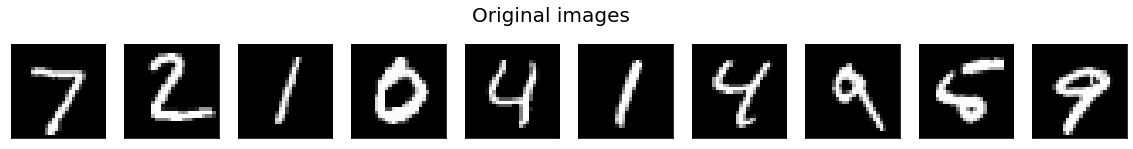

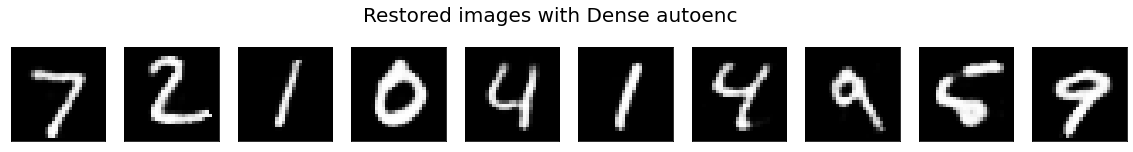

In [486]:
display_pair2(x_test_dense, dense_pred_imgs, 'Dense')

In [327]:
autoenc_eval = model_autoencoder_basic_l.evaluate(x_test_dense,x_test_dense)
autoenc_eval

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.004185142957046628, 0.019898655]

In [328]:
x_test_dense.shape, x_test_fgsm_imgs.shape

((10000, 784), (10000, 28, 28, 1))

In [349]:
x_test_fgsm_imgs_reshape = x_test_fgsm_imgs.reshape(len(x_test_fgsm_imgs), np.prod(x_train_dense.shape[1:]))
x_test_fgsm_imgs_reshape.shape

(10000, 784)

In [350]:
#try to clean images after fgsm perturbation
clean_fgsm_img_dense_autoenc = model_autoencoder_basic_l.predict(x_test_fgsm_imgs_reshape)

In [351]:
clean_fgsm_img_dense_autoenc[0].shape

(784,)

In [410]:
#onesteplesslikely
x_test_onest_imgs_reshape = x_test_onest_imgs.reshape(len(x_test_onest_imgs), np.prod(x_train_dense.shape[1:]))
print(x_test_onest_imgs_reshape.shape)
clean_onest_img_dense_autoenc = model_autoencoder_basic_l.predict(x_test_onest_imgs_reshape)
clean_onest_img_dense_autoenc[0].shape


(10000, 784)


(784,)

In [353]:
# bim
x_test_bim_imgs_reshape = x_test_bim_imgs.reshape(len(x_test_bim_imgs), np.prod(x_train_dense.shape[1:]))
print(x_test_bim_imgs_reshape.shape)
clean_bim_img_dense_autoenc = model_autoencoder_basic_l.predict(x_test_bim_imgs_reshape)
clean_bim_img_dense_autoenc[0].shape

(10000, 784)


(784,)

### CONV AUTOENCODER

In [38]:
#AUTOENCODER

input_img = Input(shape=x_train[0].shape)

#Encoder
x=Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_img)
x=MaxPooling2D(pool_size=(2,2), padding='same')(x)
x=Conv2D(16, (3,3), activation='relu', padding='same')(x)

encoded=MaxPooling2D((2,2), padding='same')(x)

#Decoder
x=Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x=UpSampling2D((2,2))(x)
x=Conv2D(16, (3,3), activation='relu', padding='same')(x)
x=UpSampling2D((2,2))(x)

decoded=Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

ERROR! Session/line number was not unique in database. History logging moved to new session 488


In [39]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optmizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0     

In [40]:
autoencoder.fit(x_train, x_train, 
               epochs=n_epochs,
               batch_size=BATCH_SIZE,
               shuffle=True,
               validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


60000/60000 [==============================] - 75s 1ms/sample - loss: 0.1469 - val_loss: 0.0985
Epoch 2/30
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0931 - val_loss: 0.0887
Epoch 3/30
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0848 - val_loss: 0.0815
Epoch 4/30
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0810 - val_loss: 0.0784
Epoch 5/30
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0787 - val_loss: 0.0767
Epoch 6/30
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0771 - val_loss: 0.0754
Epoch 7/30
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0760 - val_loss: 0.0761
Epoch 8/30
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0751 - val_loss: 0.0737
Epoch 9/30
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0743 - val_loss: 0.0728
Epoch 10/30
60000/60000 [=======================

In [41]:
if save_model==True:
    autoencoder.save(os.path.join(save_path, 'autoenc_clean_clean'))
    autoencoder.save(os.path.join(save_path, 'autoenc_clean_clean.h5'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models/autoenc_clean_clean/assets


INFO:tensorflow:Assets written to: saved_models/autoenc_clean_clean/assets


In [584]:
autoencoder_load = tf.keras.models.load_model(os.path.join(save_path, 'autoenc_clean_clean.h5'))
autoencoder_load.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0     

In [43]:
autoenc_preds = autoencoder.predict(x_test)

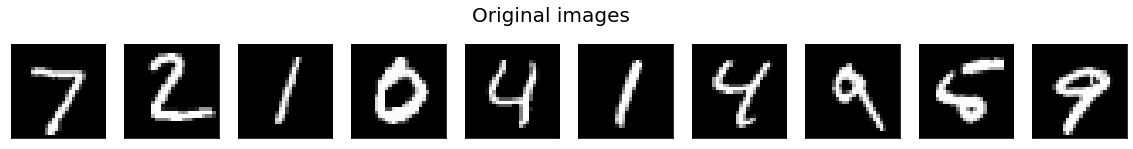

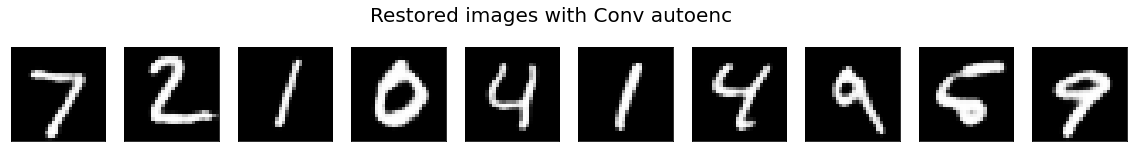

In [583]:
#CLEAN images through a conv autoenc, just to evaluate the quality of autoenc work on clean images
display_pair2(x_test, autoenc_preds, 'Conv')

## EVALUATE DEFAULT MODEL BEFORE AND AFTER NOISING/ATTACK

In [189]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#classification_report(y_pred, y_true)
#confusion_matrix(y_pred, y_true)

### WITHOUT AUTOENCODER

In [38]:
#test loading the model
loaded_model_mnist = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model.h5'))
default_score = loaded_model_mnist.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [41]:
loaded_model_mnist.summary()

Model: "mnist_default_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)  

In [40]:
print(f'Default model: loss: {default_score[0]} mae: {default_score[1]} accuracy: {default_score[2]}')

Default model: loss: 0.02046797925942046 mae: 0.0016699060797691345 accuracy: 0.9933000206947327


### WITH AUTOENCODER

## Dense autoencoder

#### FGSM

In [389]:
clean_fgsm_img_dense_autoenc_reshape = clean_fgsm_img_dense_autoenc.reshape((len(x_test_dense),28,28,1))
clean_fgsm_img_dense_autoenc_reshape.shape
                                                                            

(10000, 28, 28, 1)

In [390]:
after_dense_autoenc_predicts = model.predict(clean_fgsm_img_dense_autoenc_reshape)

In [391]:
after_dense_autoenc_predicts[0], np.argmax(after_dense_autoenc_predicts[0])

(array([1.55806923e-10, 1.10169225e-07, 4.62891547e-09, 9.28675732e-08,
        1.98580530e-09, 2.34256525e-09, 3.36618702e-16, 9.99997735e-01,
        3.31002892e-10, 2.05249762e-06], dtype=float32),
 7)

In [392]:
x_test_fgsm_imgs.shape, y_test.shape

((10000, 28, 28, 1), TensorShape([10000, 10]))

In [393]:
clean_fgsm_img_dense_autoenc_reshape.shape, y_test_dense.shape

((10000, 28, 28, 1), (10000,))

In [394]:
y_test_dense_preprocessed = preprocess_labels(y_test_dense)
y_test_dense_preprocessed.shape

TensorShape([10000, 10])

In [395]:
after_dense_score = model.evaluate(clean_fgsm_img_dense_autoenc_reshape, y_test_dense_preprocessed)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [396]:
print('Default Model after cleaning FGSM perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score[0]} mae: {after_dense_score[1]} accuracy: {after_dense_score[2]}')

Default Model after cleaning FGSM perturbed images with Dense Autoencoder:
loss: 0.10039879664070904 mae: 0.007164399139583111 accuracy: 0.9714999794960022


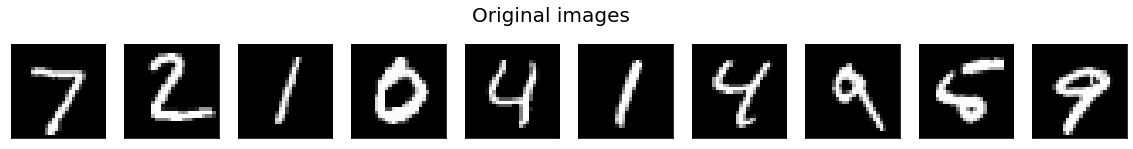

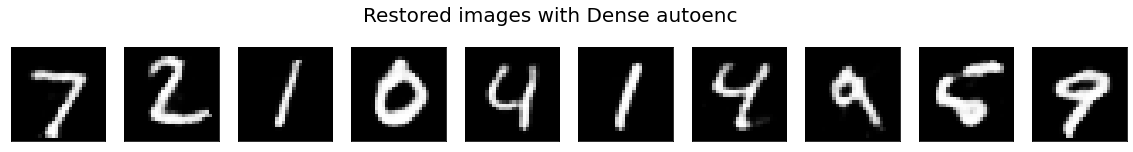

In [617]:
# не убирать, сохранить!
display_pair2(x_test,clean_fgsm_img_dense_autoenc_reshape, 'Dense')

In [609]:
diff_idx = find_diff_classes(y_test, test_fgsm_preds, n=1000)
diff_idx 

[4,
 8,
 18,
 20,
 24,
 42,
 59,
 62,
 67,
 92,
 95,
 104,
 107,
 115,
 121,
 124,
 139,
 149,
 158,
 172,
 175,
 184,
 193,
 195,
 247,
 259,
 264,
 266,
 275,
 290,
 320,
 321,
 326,
 333,
 336,
 340,
 355,
 358,
 359,
 366,
 381,
 400,
 412,
 420,
 435,
 445,
 447,
 448,
 449,
 450,
 460,
 462,
 464,
 490,
 492,
 495,
 497,
 511,
 532,
 541,
 542,
 551,
 571,
 578,
 582,
 583,
 591,
 593,
 603,
 618,
 625,
 646,
 655,
 659,
 674,
 684,
 685,
 689,
 691,
 698,
 708,
 716,
 717,
 720,
 723,
 726,
 740,
 760,
 761,
 762,
 774,
 780,
 791,
 800,
 813,
 829,
 834,
 839,
 844,
 846,
 872,
 877,
 881,
 882,
 883,
 890,
 896,
 902,
 916,
 924,
 926,
 936,
 938,
 939,
 947,
 951,
 956,
 958,
 965,
 966,
 969,
 995]

<Figure size 1440x144 with 0 Axes>

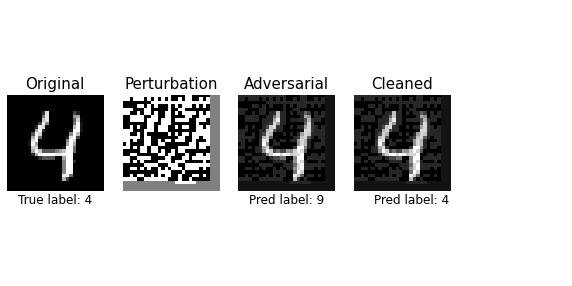

<Figure size 1440x144 with 0 Axes>

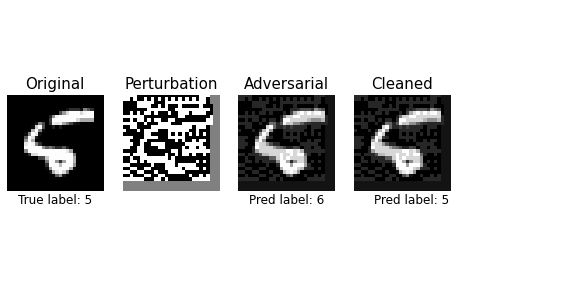

<Figure size 1440x144 with 0 Axes>

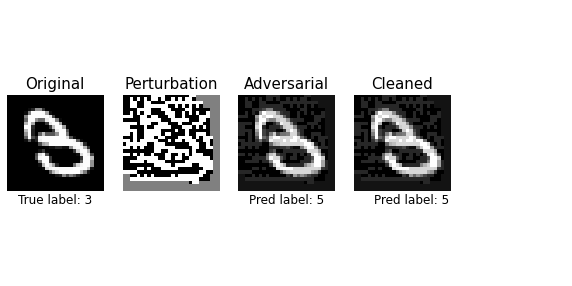

<Figure size 1440x144 with 0 Axes>

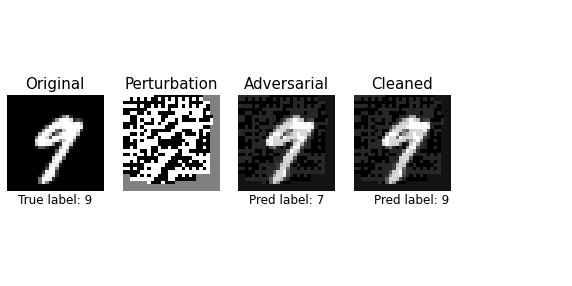

<Figure size 1440x144 with 0 Axes>

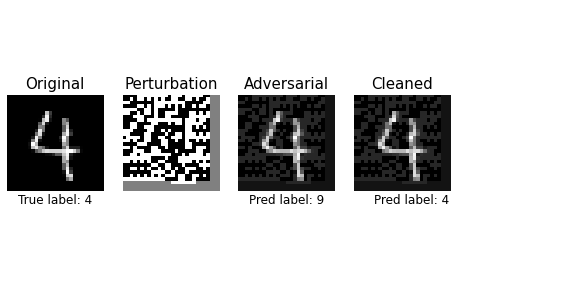

<Figure size 1440x144 with 0 Axes>

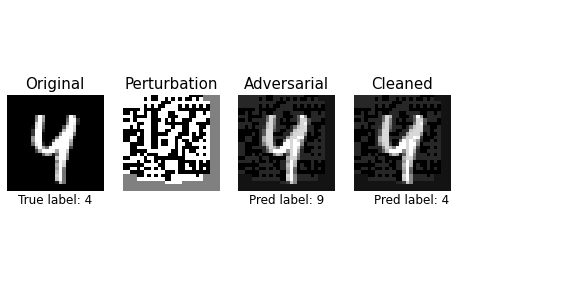

<Figure size 1440x144 with 0 Axes>

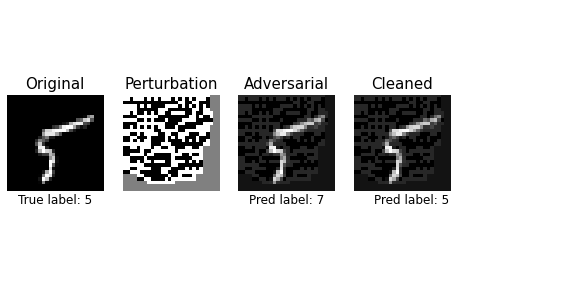

<Figure size 1440x144 with 0 Axes>

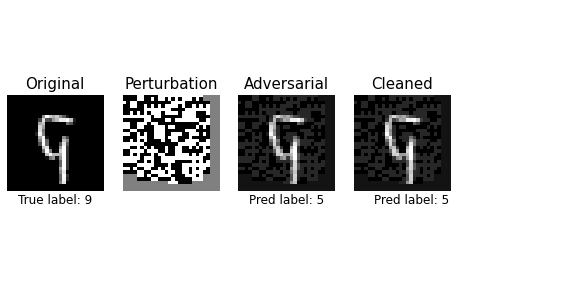

<Figure size 1440x144 with 0 Axes>

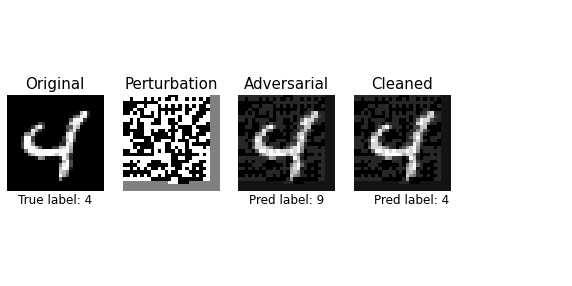

<Figure size 1440x144 with 0 Axes>

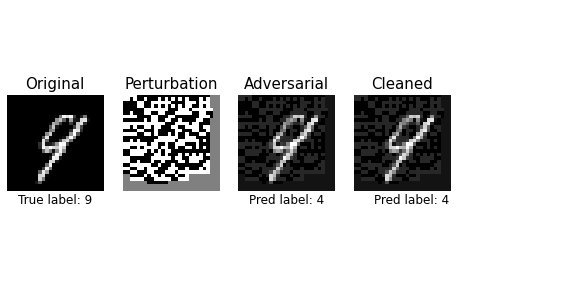

<Figure size 1440x144 with 0 Axes>

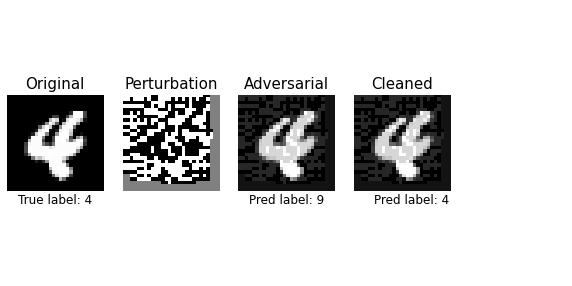

<Figure size 1440x144 with 0 Axes>

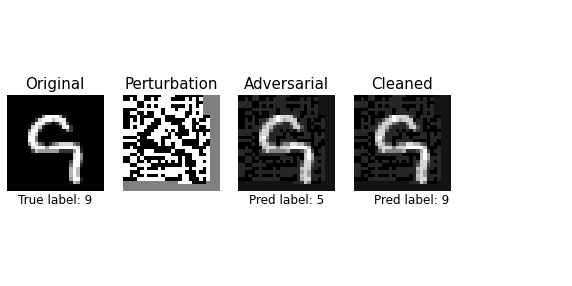

<Figure size 1440x144 with 0 Axes>

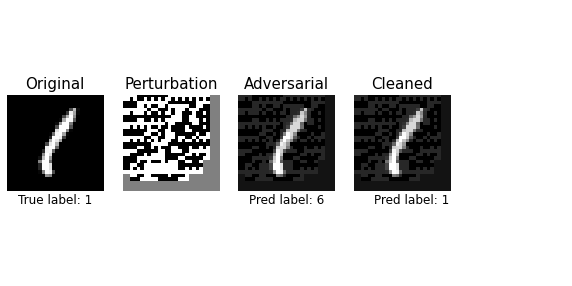

<Figure size 1440x144 with 0 Axes>

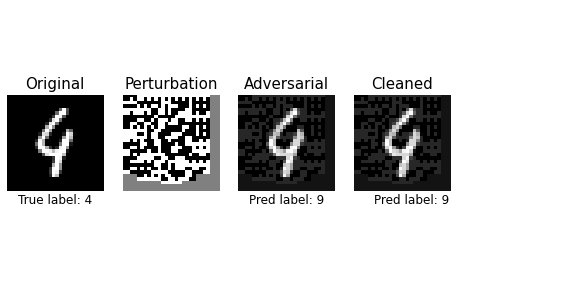

<Figure size 1440x144 with 0 Axes>

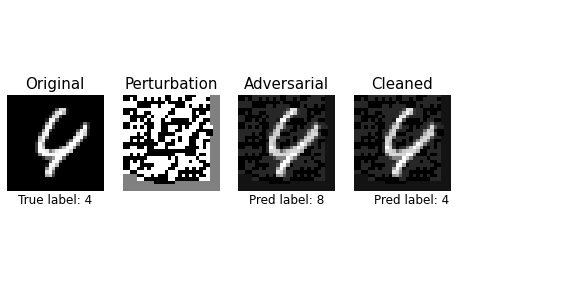

<Figure size 1440x144 with 0 Axes>

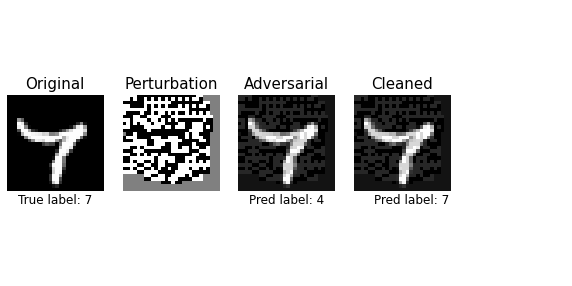

<Figure size 1440x144 with 0 Axes>

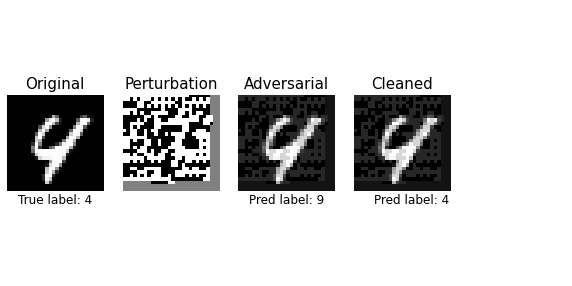

<Figure size 1440x144 with 0 Axes>

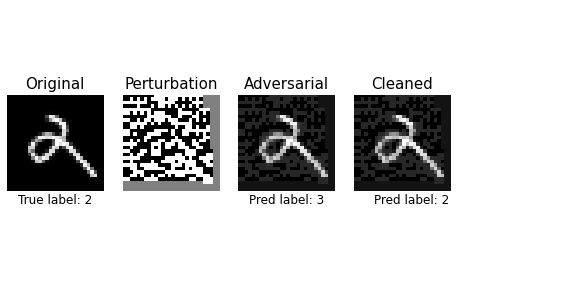

<Figure size 1440x144 with 0 Axes>

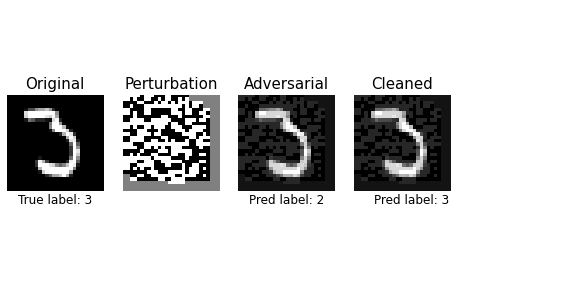

<Figure size 1440x144 with 0 Axes>

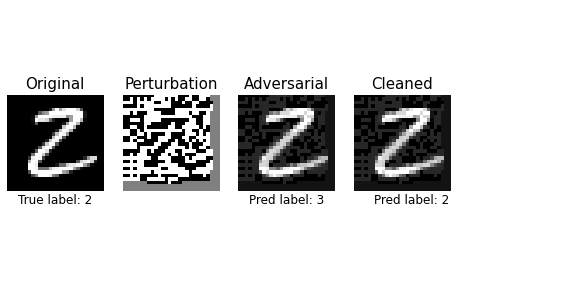

<Figure size 1440x144 with 0 Axes>

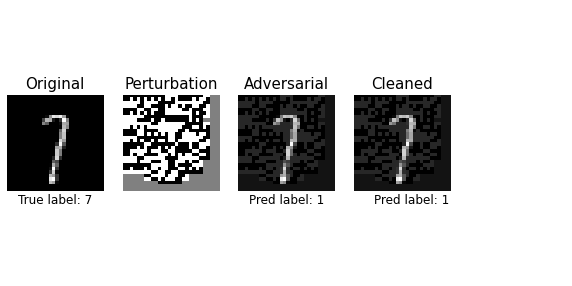

<Figure size 1440x144 with 0 Axes>

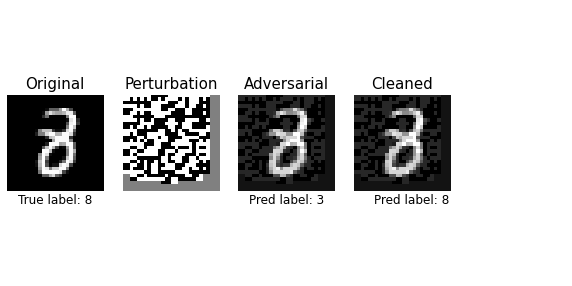

<Figure size 1440x144 with 0 Axes>

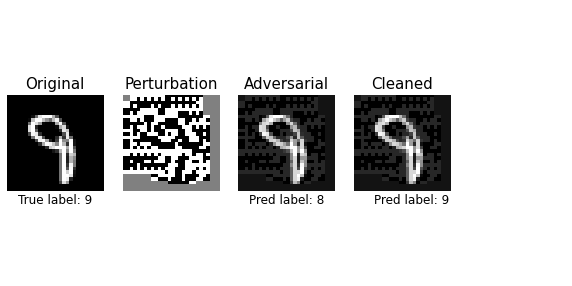

<Figure size 1440x144 with 0 Axes>

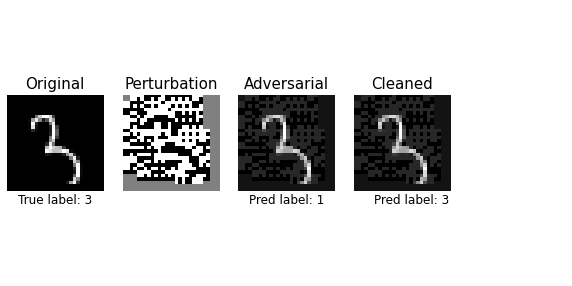

<Figure size 1440x144 with 0 Axes>

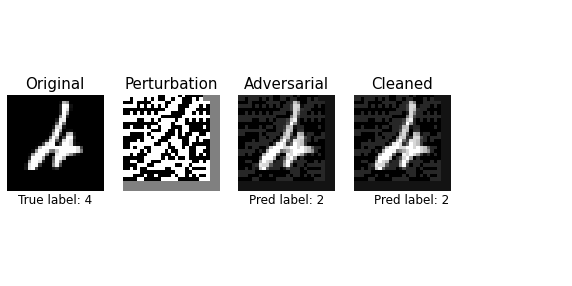

<Figure size 1440x144 with 0 Axes>

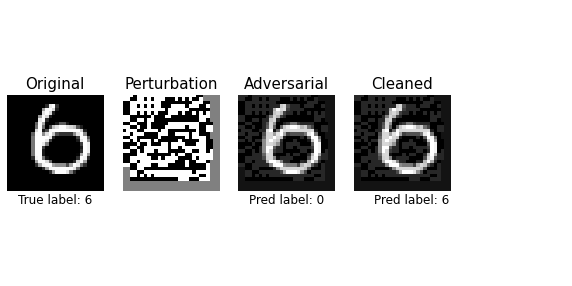

<Figure size 1440x144 with 0 Axes>

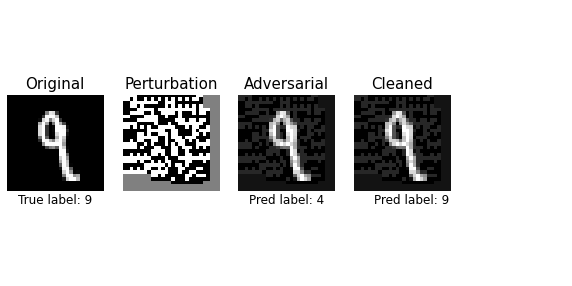

<Figure size 1440x144 with 0 Axes>

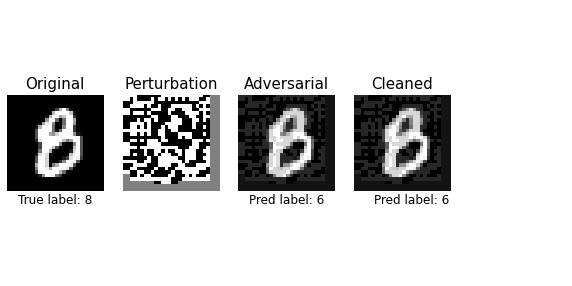

<Figure size 1440x144 with 0 Axes>

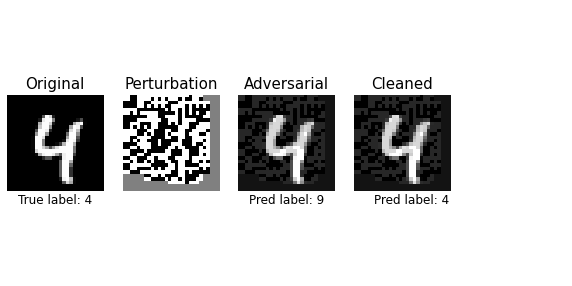

<Figure size 1440x144 with 0 Axes>

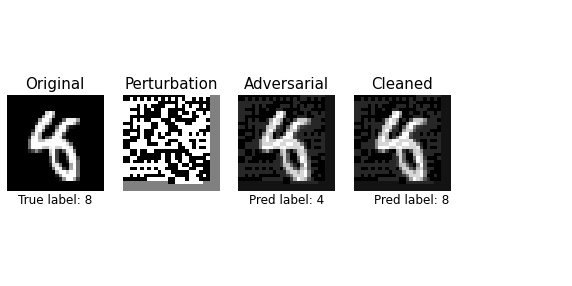

<Figure size 1440x144 with 0 Axes>

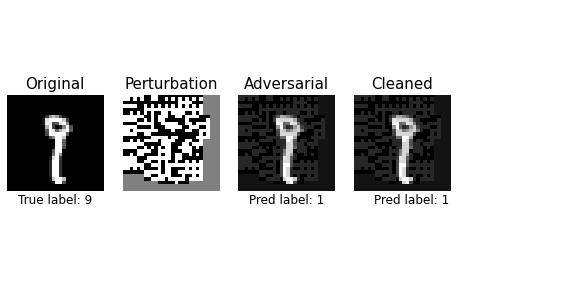

<Figure size 1440x144 with 0 Axes>

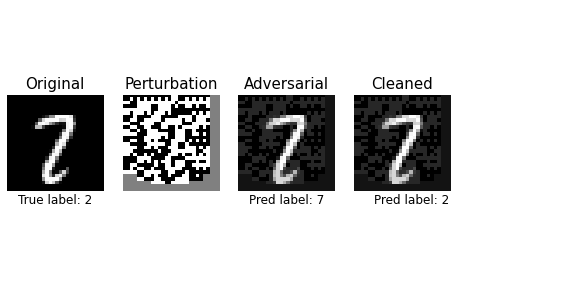

<Figure size 1440x144 with 0 Axes>

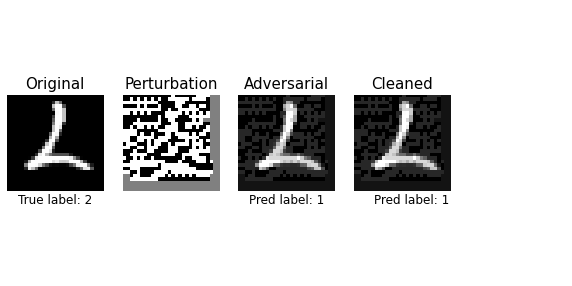

<Figure size 1440x144 with 0 Axes>

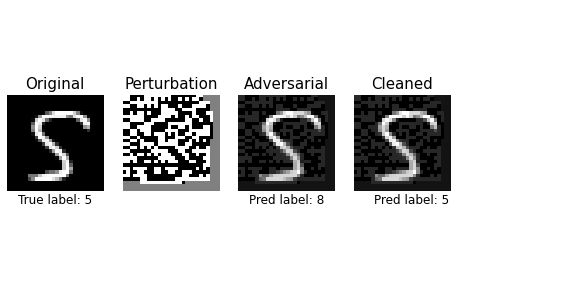

<Figure size 1440x144 with 0 Axes>

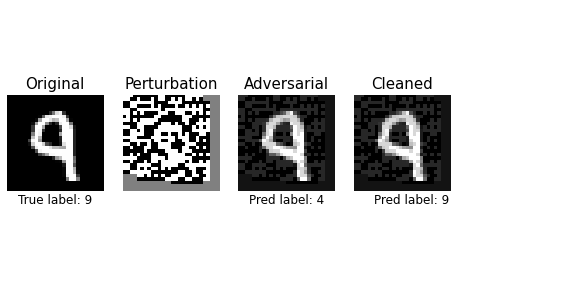

<Figure size 1440x144 with 0 Axes>

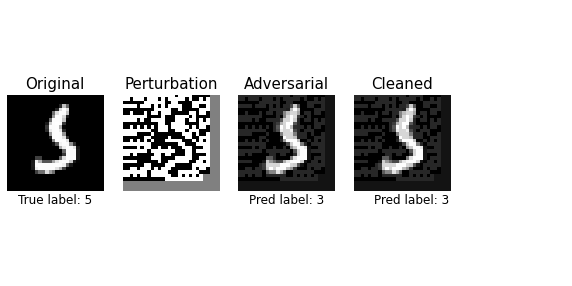

<Figure size 1440x144 with 0 Axes>

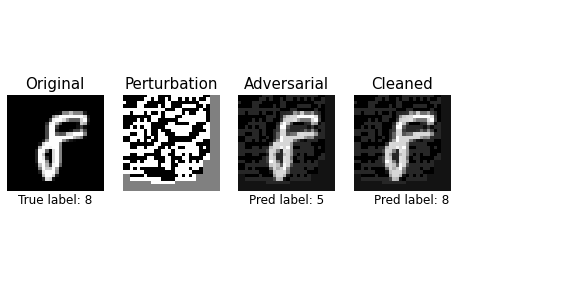

<Figure size 1440x144 with 0 Axes>

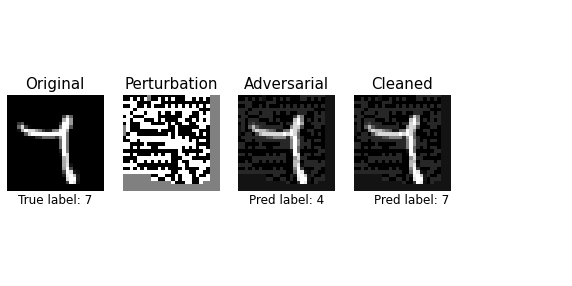

<Figure size 1440x144 with 0 Axes>

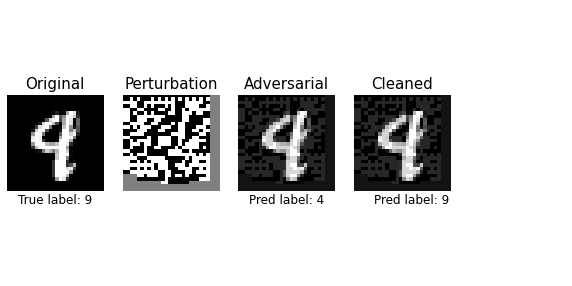

<Figure size 1440x144 with 0 Axes>

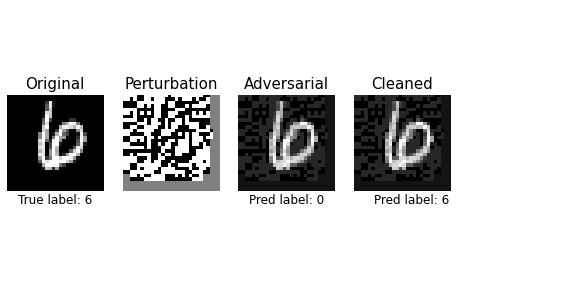

<Figure size 1440x144 with 0 Axes>

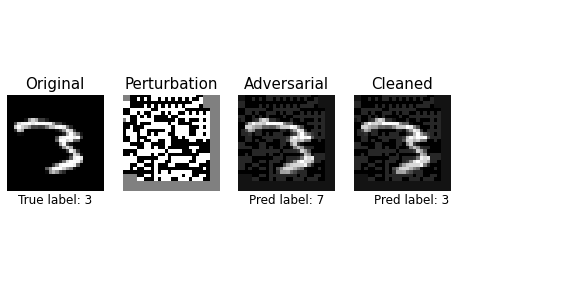

<Figure size 1440x144 with 0 Axes>

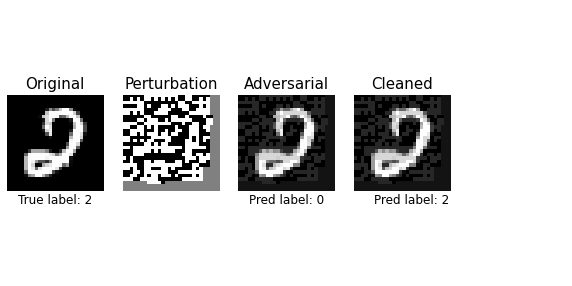

<Figure size 1440x144 with 0 Axes>

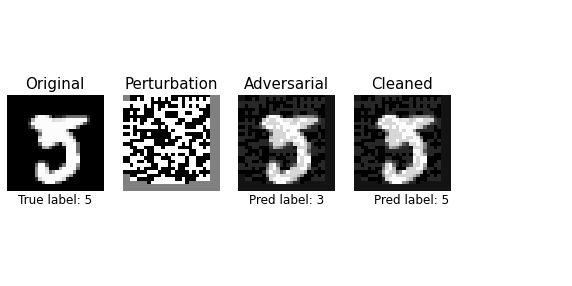

<Figure size 1440x144 with 0 Axes>

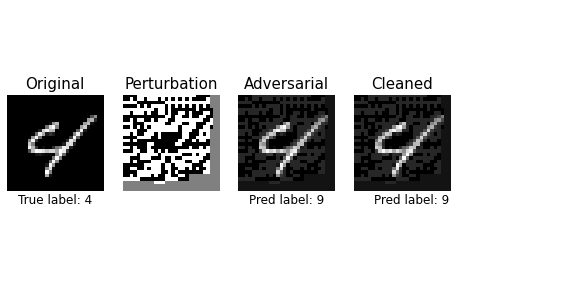

<Figure size 1440x144 with 0 Axes>

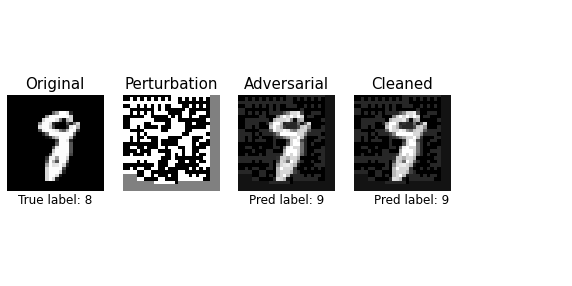

<Figure size 1440x144 with 0 Axes>

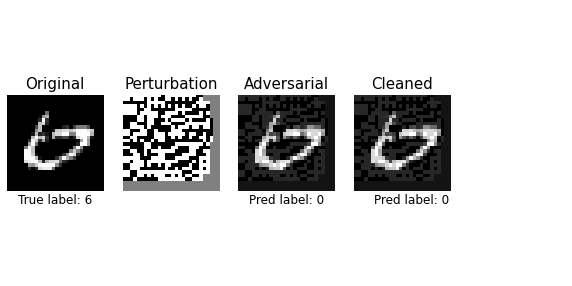

<Figure size 1440x144 with 0 Axes>

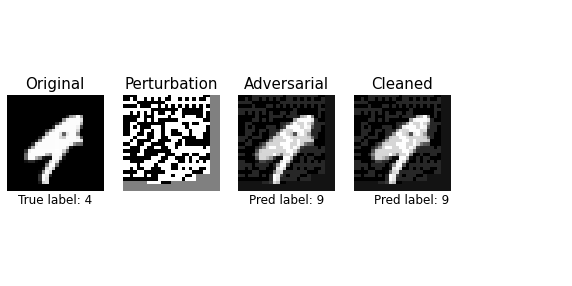

<Figure size 1440x144 with 0 Axes>

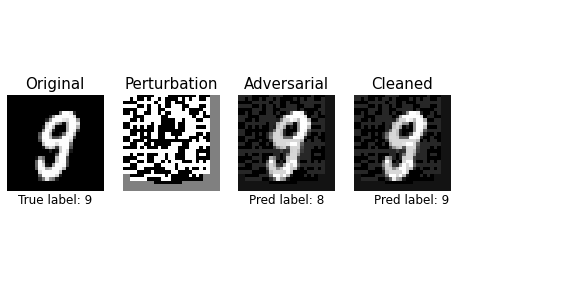

<Figure size 1440x144 with 0 Axes>

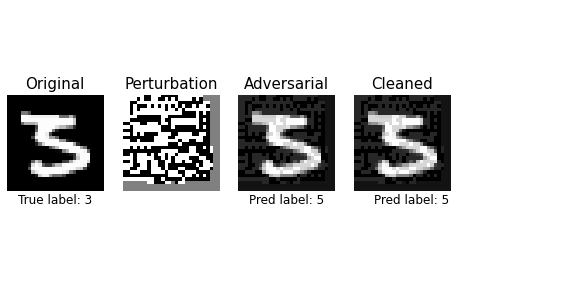

<Figure size 1440x144 with 0 Axes>

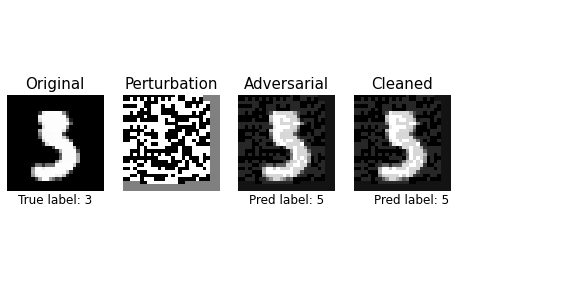

<Figure size 1440x144 with 0 Axes>

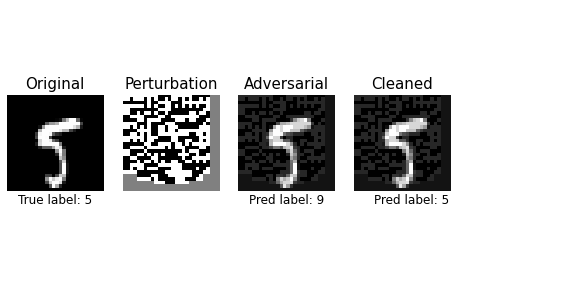

<Figure size 1440x144 with 0 Axes>

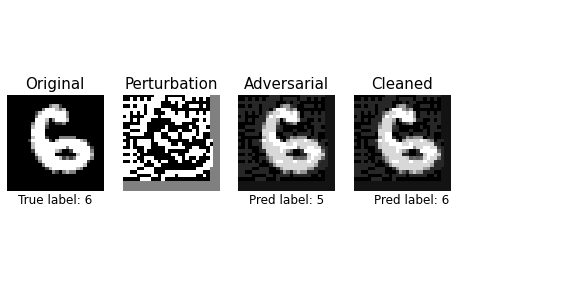

<Figure size 1440x144 with 0 Axes>

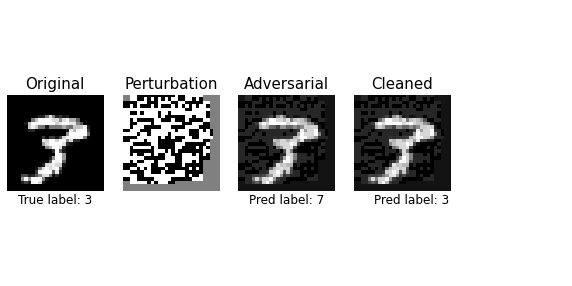

<Figure size 1440x144 with 0 Axes>

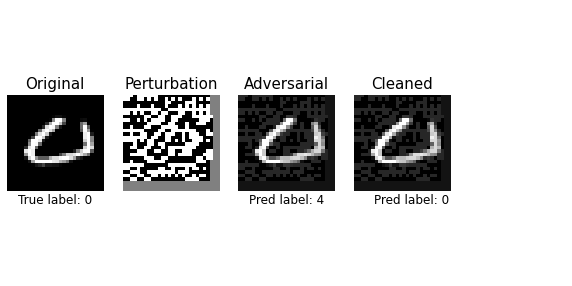

<Figure size 1440x144 with 0 Axes>

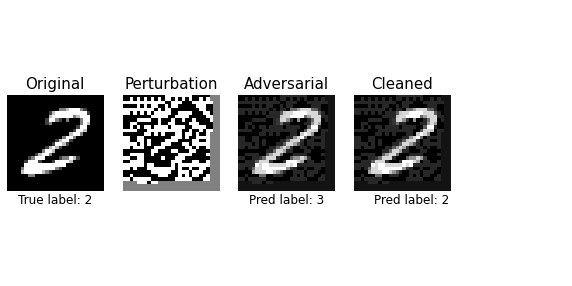

<Figure size 1440x144 with 0 Axes>

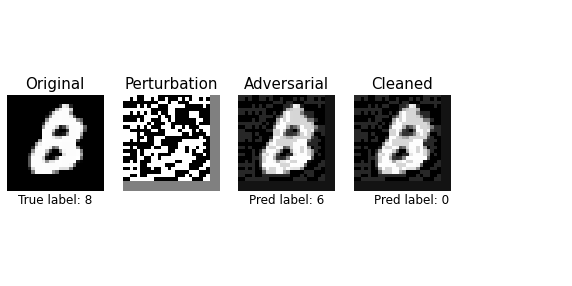

<Figure size 1440x144 with 0 Axes>

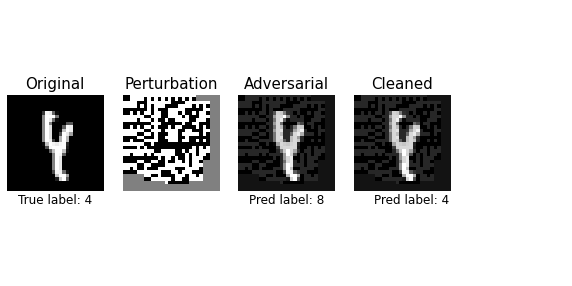

<Figure size 1440x144 with 0 Axes>

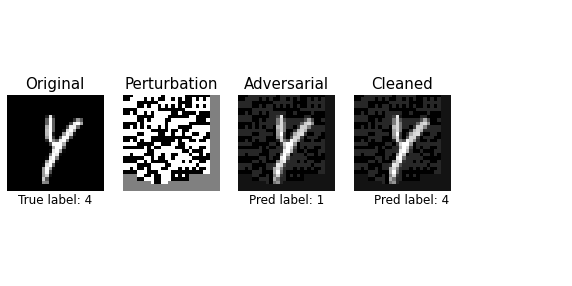

<Figure size 1440x144 with 0 Axes>

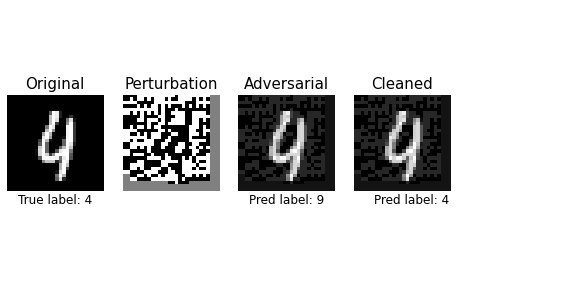

<Figure size 1440x144 with 0 Axes>

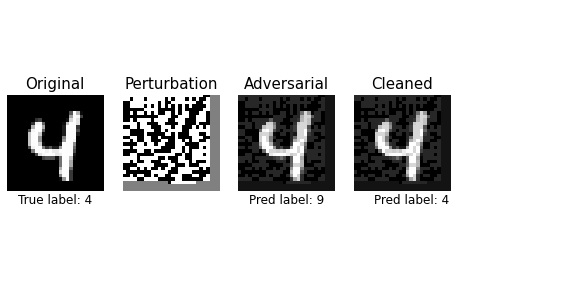

<Figure size 1440x144 with 0 Axes>

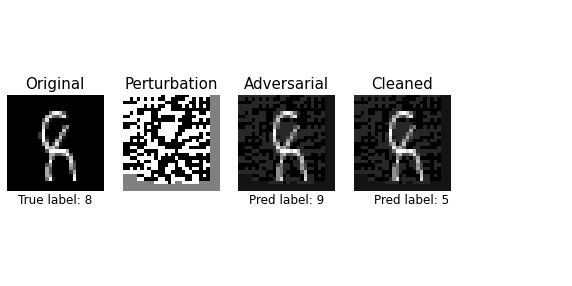

<Figure size 1440x144 with 0 Axes>

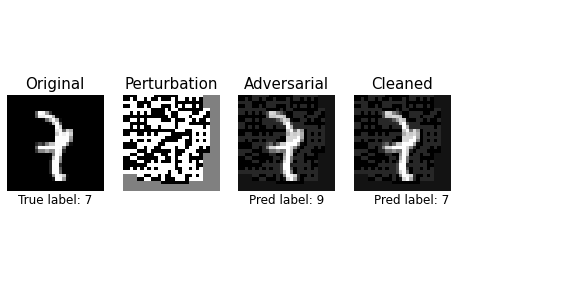

<Figure size 1440x144 with 0 Axes>

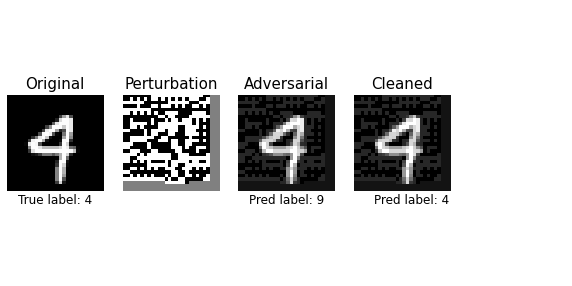

<Figure size 1440x144 with 0 Axes>

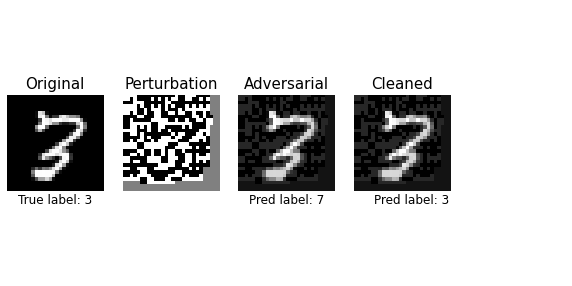

<Figure size 1440x144 with 0 Axes>

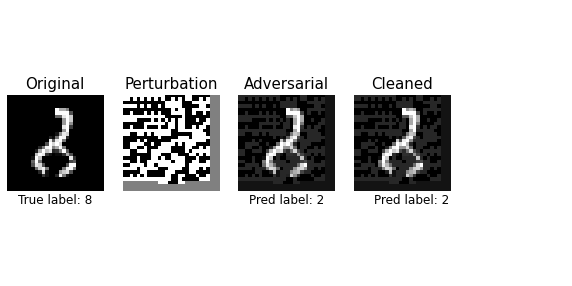

<Figure size 1440x144 with 0 Axes>

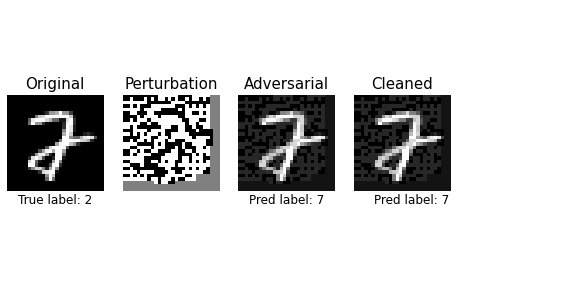

<Figure size 1440x144 with 0 Axes>

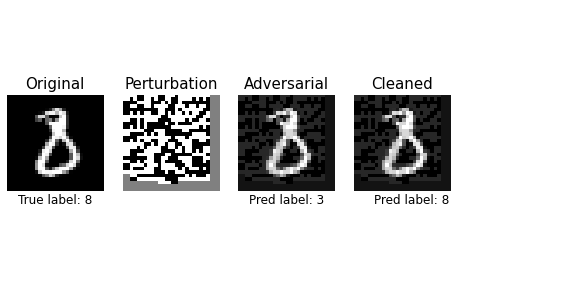

<Figure size 1440x144 with 0 Axes>

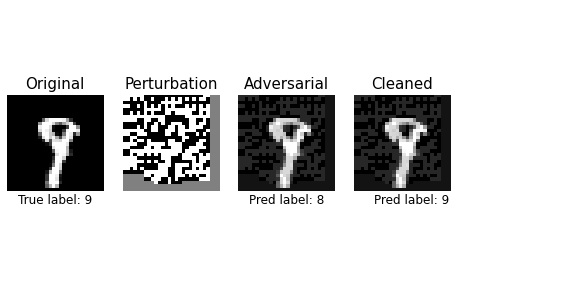

<Figure size 1440x144 with 0 Axes>

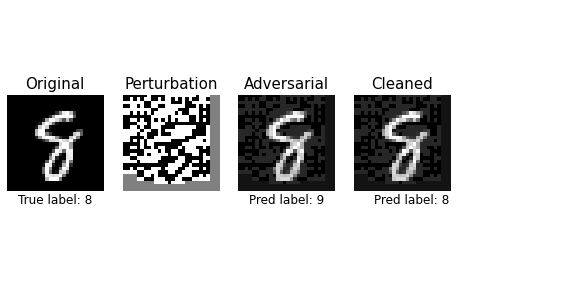

<Figure size 1440x144 with 0 Axes>

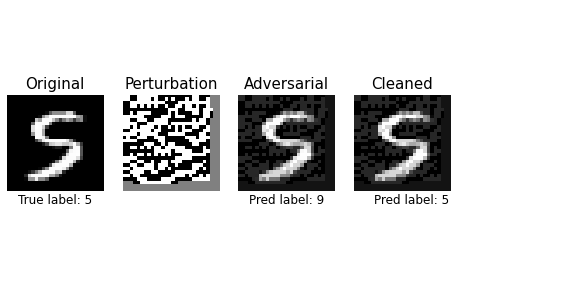

<Figure size 1440x144 with 0 Axes>

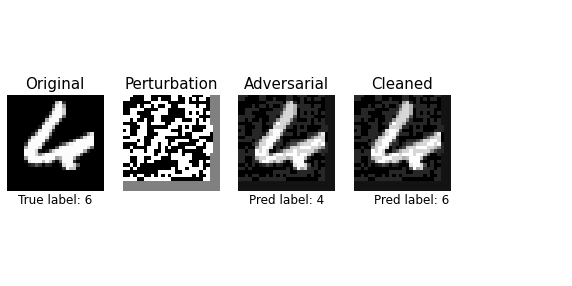

<Figure size 1440x144 with 0 Axes>

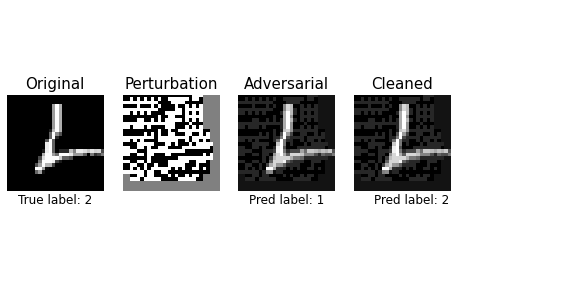

<Figure size 1440x144 with 0 Axes>

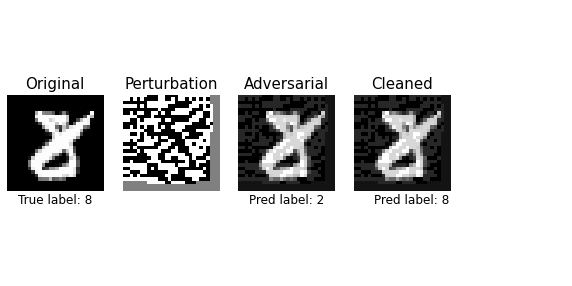

<Figure size 1440x144 with 0 Axes>

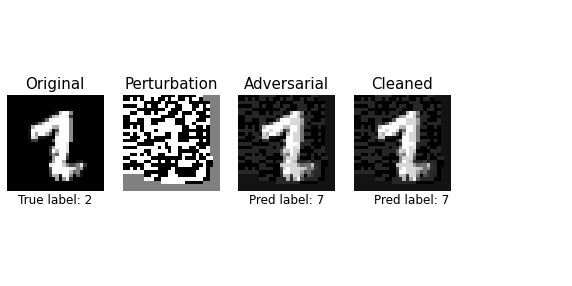

<Figure size 1440x144 with 0 Axes>

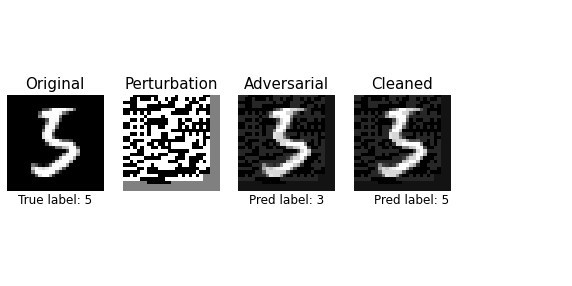

<Figure size 1440x144 with 0 Axes>

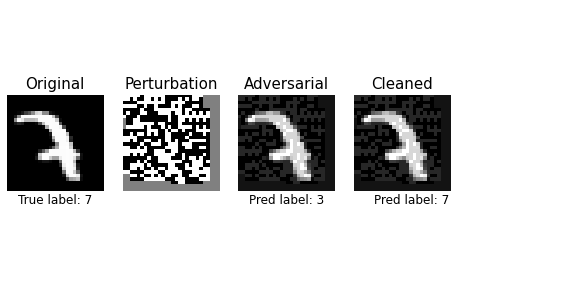

<Figure size 1440x144 with 0 Axes>

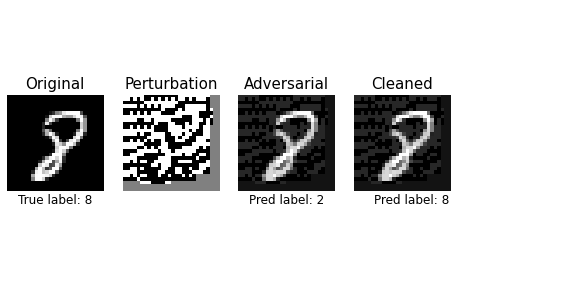

<Figure size 1440x144 with 0 Axes>

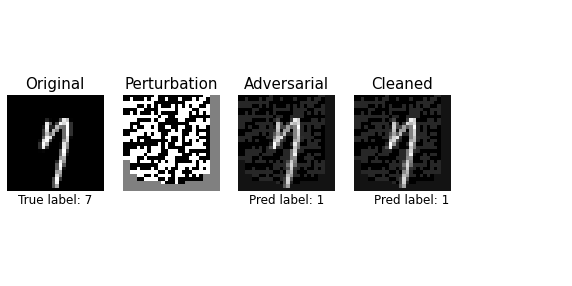

<Figure size 1440x144 with 0 Axes>

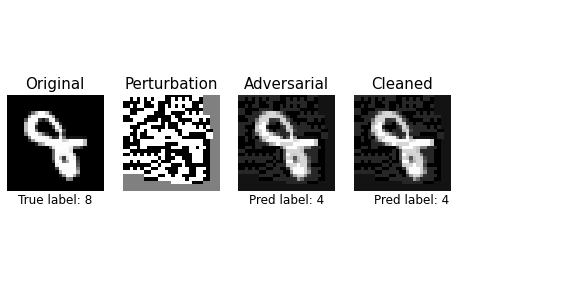

<Figure size 1440x144 with 0 Axes>

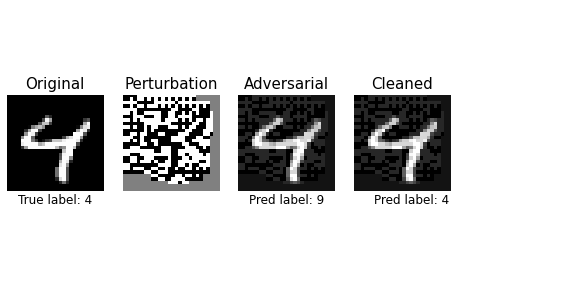

<Figure size 1440x144 with 0 Axes>

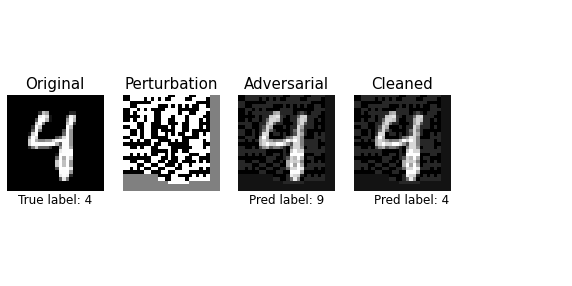

<Figure size 1440x144 with 0 Axes>

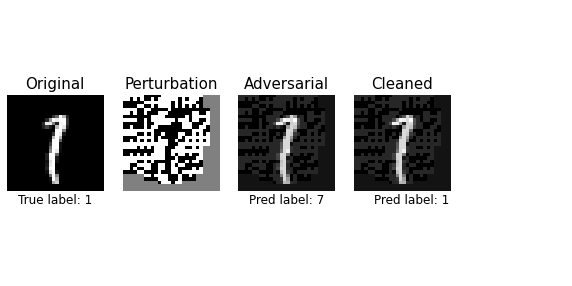

<Figure size 1440x144 with 0 Axes>

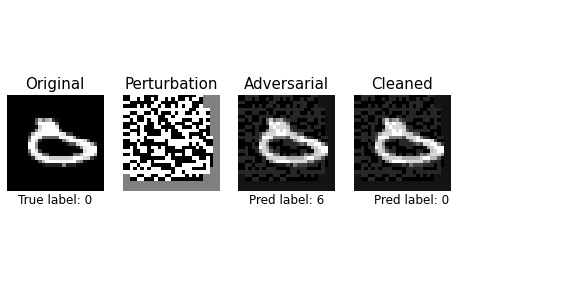

<Figure size 1440x144 with 0 Axes>

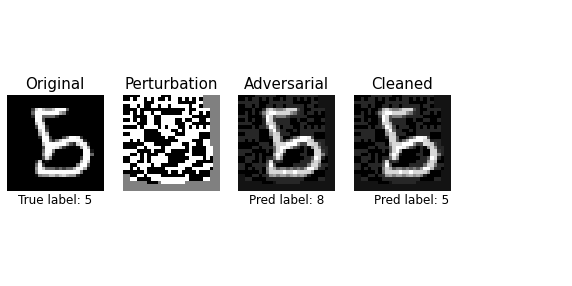

<Figure size 1440x144 with 0 Axes>

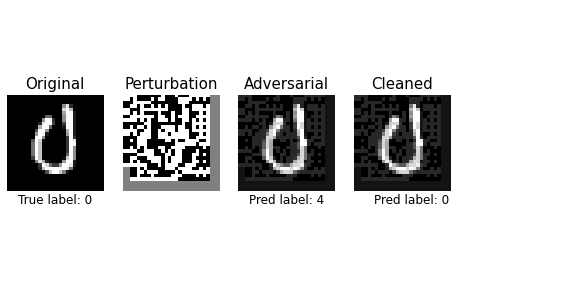

<Figure size 1440x144 with 0 Axes>

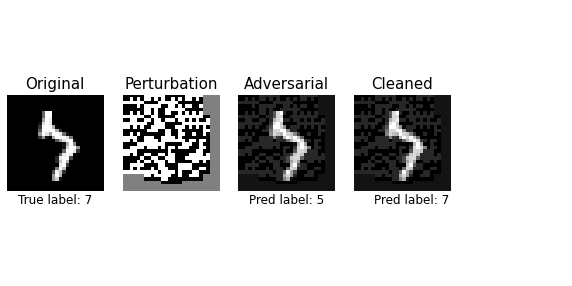

<Figure size 1440x144 with 0 Axes>

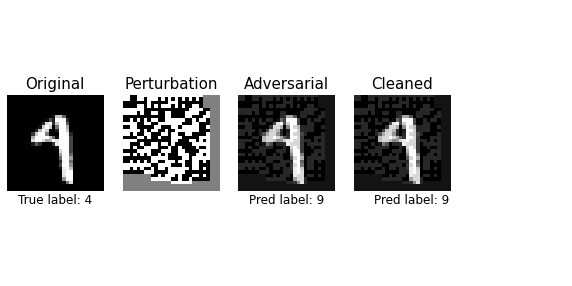

<Figure size 1440x144 with 0 Axes>

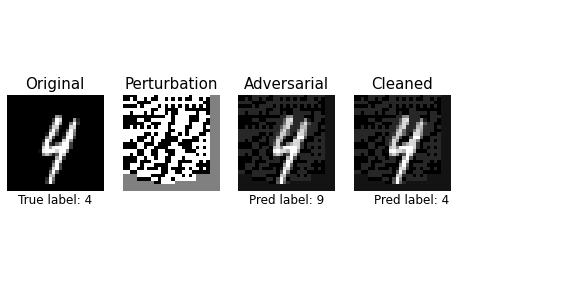

<Figure size 1440x144 with 0 Axes>

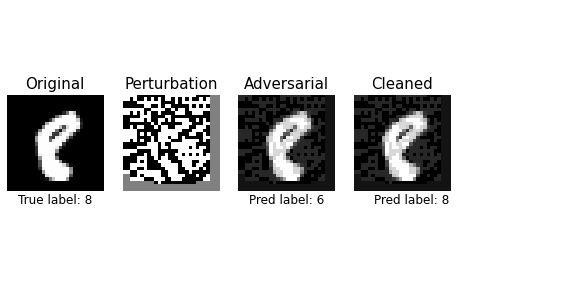

<Figure size 1440x144 with 0 Axes>

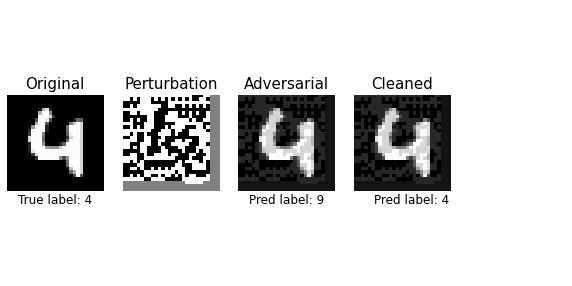

<Figure size 1440x144 with 0 Axes>

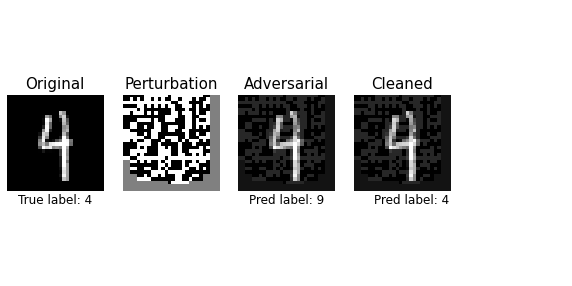

<Figure size 1440x144 with 0 Axes>

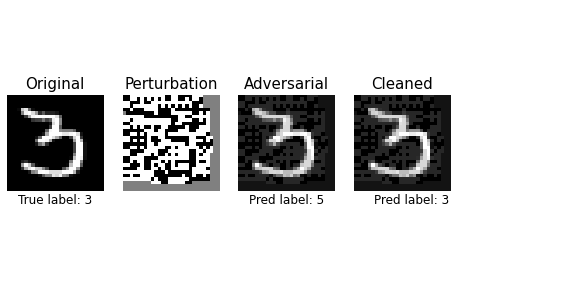

<Figure size 1440x144 with 0 Axes>

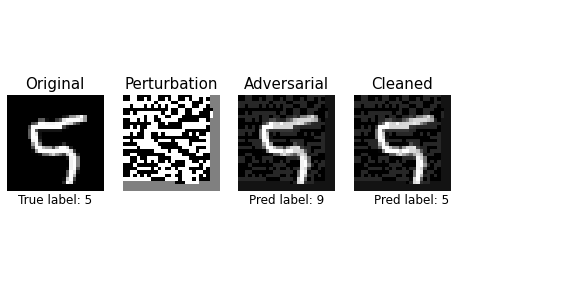

<Figure size 1440x144 with 0 Axes>

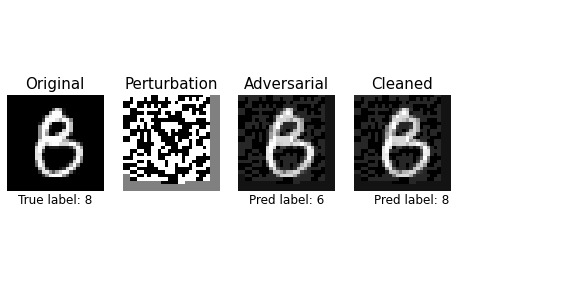

<Figure size 1440x144 with 0 Axes>

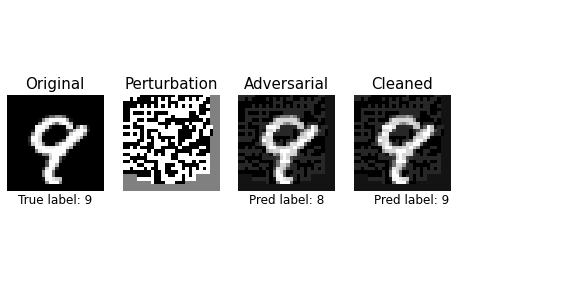

<Figure size 1440x144 with 0 Axes>

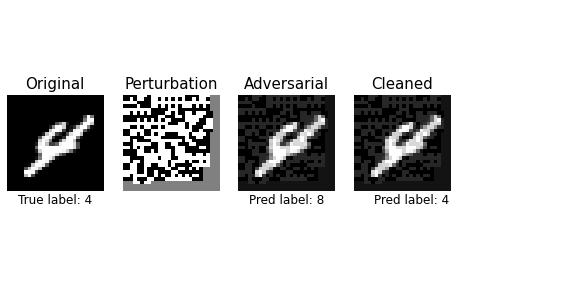

<Figure size 1440x144 with 0 Axes>

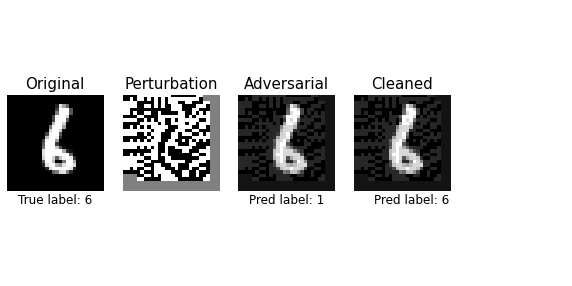

<Figure size 1440x144 with 0 Axes>

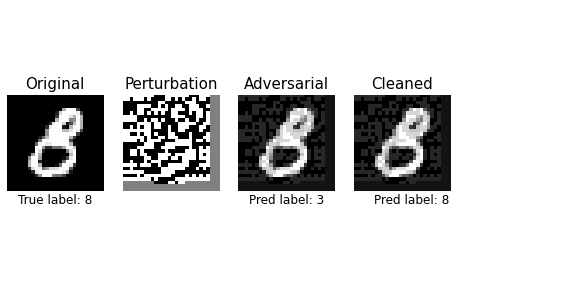

<Figure size 1440x144 with 0 Axes>

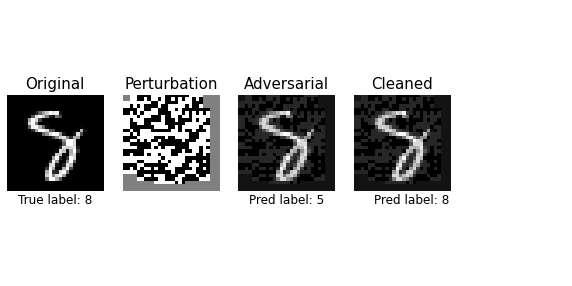

<Figure size 1440x144 with 0 Axes>

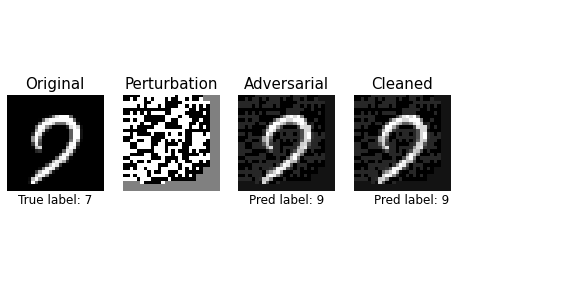

<Figure size 1440x144 with 0 Axes>

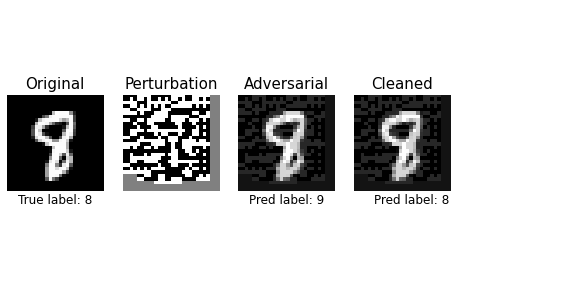

<Figure size 1440x144 with 0 Axes>

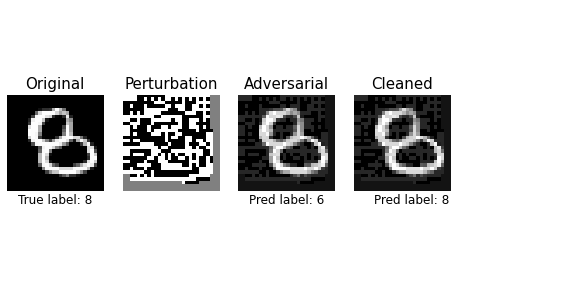

<Figure size 1440x144 with 0 Axes>

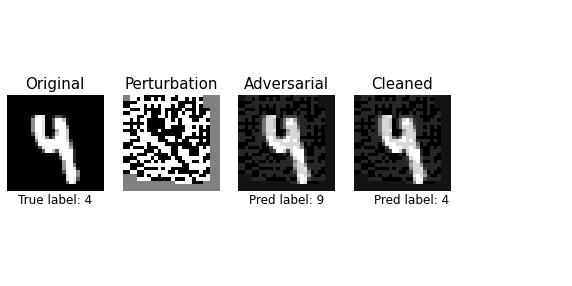

<Figure size 1440x144 with 0 Axes>

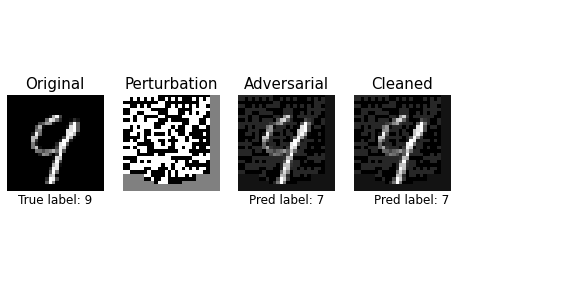

<Figure size 1440x144 with 0 Axes>

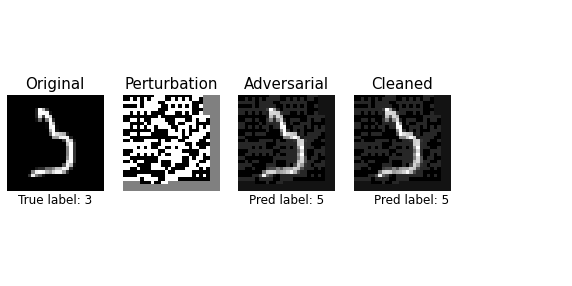

<Figure size 1440x144 with 0 Axes>

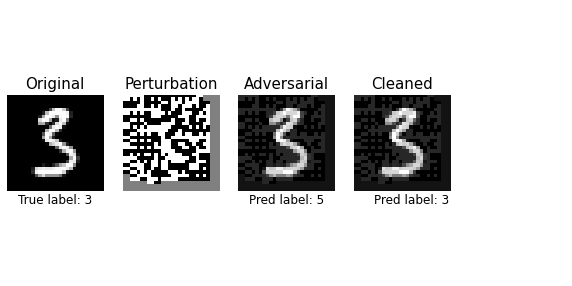

<Figure size 1440x144 with 0 Axes>

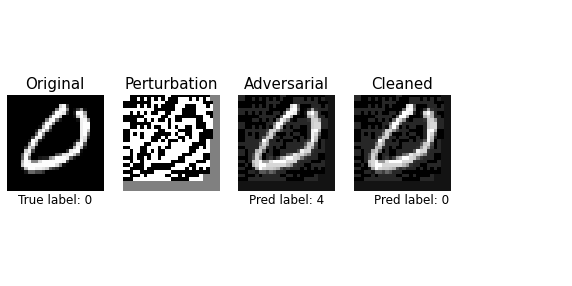

<Figure size 1440x144 with 0 Axes>

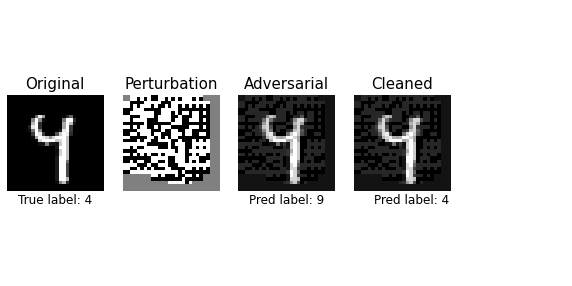

<Figure size 1440x144 with 0 Axes>

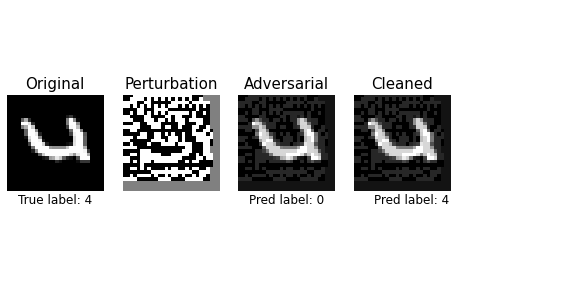

<Figure size 1440x144 with 0 Axes>

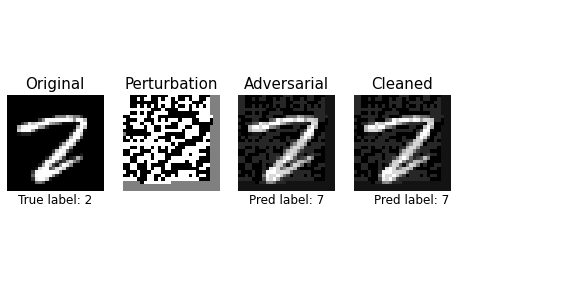

<Figure size 1440x144 with 0 Axes>

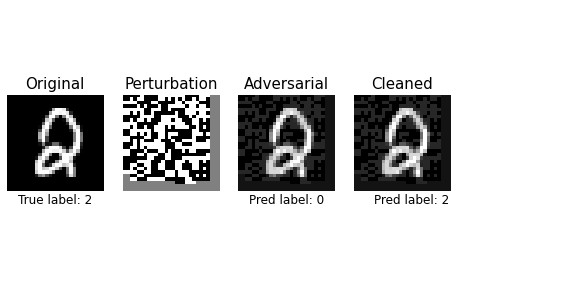

<Figure size 1440x144 with 0 Axes>

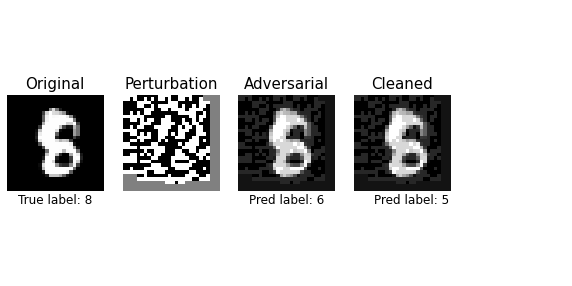

<Figure size 1440x144 with 0 Axes>

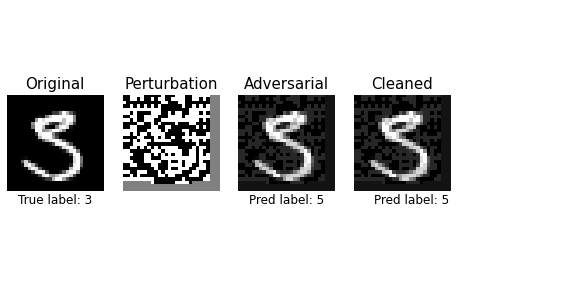

<Figure size 1440x144 with 0 Axes>

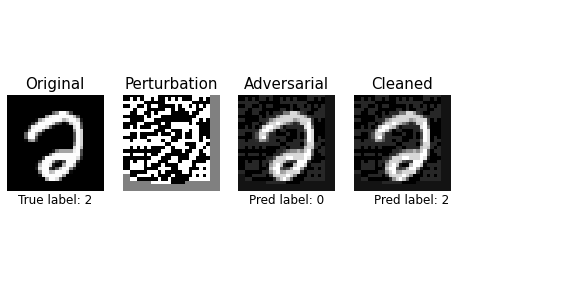

<Figure size 1440x144 with 0 Axes>

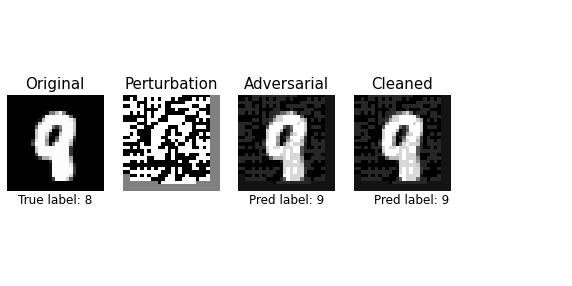

<Figure size 1440x144 with 0 Axes>

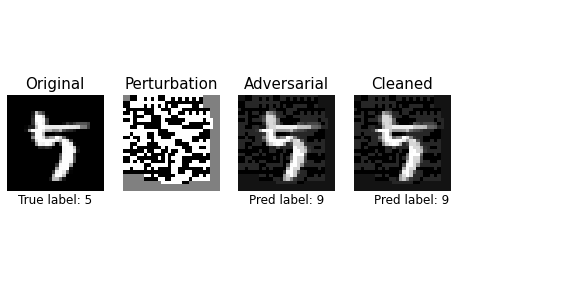

<Figure size 1440x144 with 0 Axes>

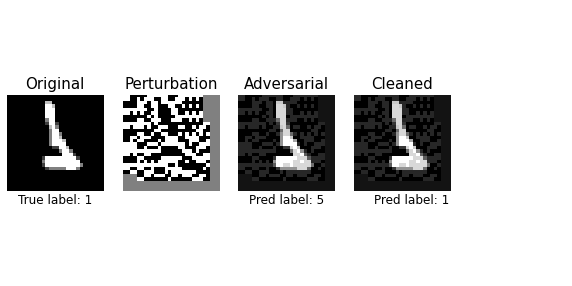

<Figure size 1440x144 with 0 Axes>

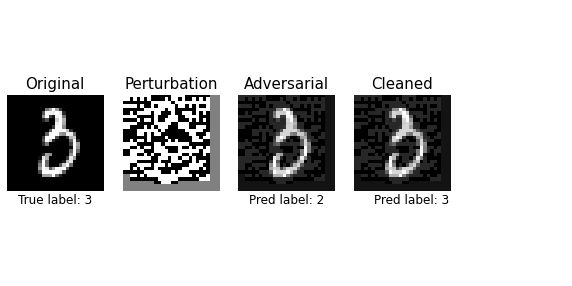

<Figure size 1440x144 with 0 Axes>

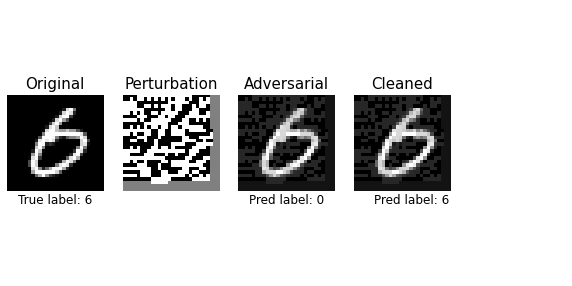

<Figure size 1440x144 with 0 Axes>

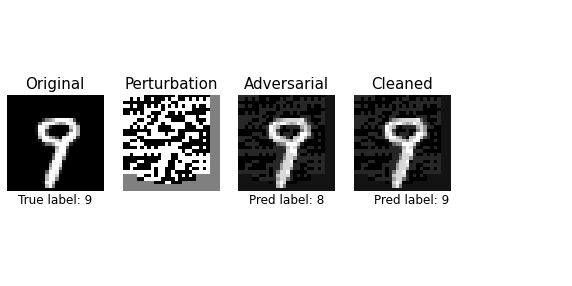

<Figure size 1440x144 with 0 Axes>

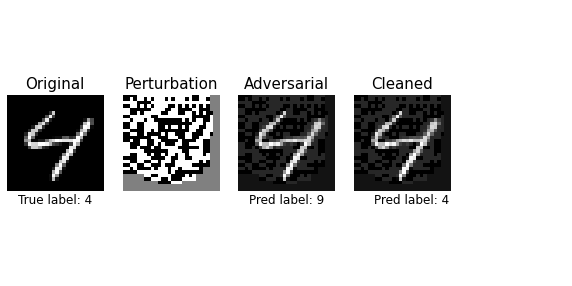

<Figure size 1440x144 with 0 Axes>

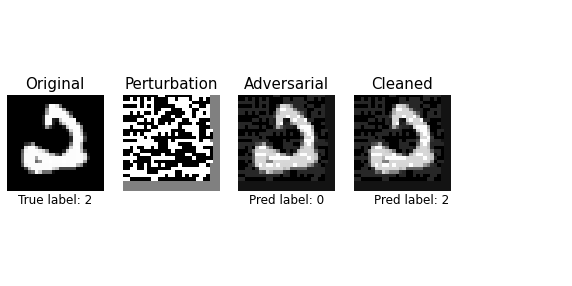

In [610]:
for idx in diff_idx:
    display_quad(x_test[idx], x_test_fgsm_imgs[idx], x_test_fgsm_perts[idx],clean_fgsm_img_dense_autoenc_reshape, y_test[idx], test_fgsm_preds[idx], after_dense_autoenc_predicts[idx])

### OneStepLessLikely

In [411]:
clean_onest_img_dense_autoenc_reshape = clean_onest_img_dense_autoenc.reshape((len(x_test_dense),28,28,1))
clean_onest_img_dense_autoenc_reshape.shape

(10000, 28, 28, 1)

In [412]:
after_dense_autoenc_predicts_onest = model.predict(clean_onest_img_dense_autoenc_reshape)

In [413]:
y_test_dense_preprocessed = preprocess_labels(y_test_dense)
y_test_dense_preprocessed.shape

TensorShape([10000, 10])

In [414]:
after_dense_score_onest = model.evaluate(clean_onest_img_dense_autoenc_reshape, y_test_dense_preprocessed)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [415]:
print('Default Model after cleaning OneStepLessLikely perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score_onest[0]} mae: {after_dense_score_onest[1]} accuracy: {after_dense_score_onest[2]}')

Default Model after cleaning OneStepLessLikely perturbed images with Dense Autoencoder:
loss: 0.06609210041973274 mae: 0.006038964726030827 accuracy: 0.9764000177383423


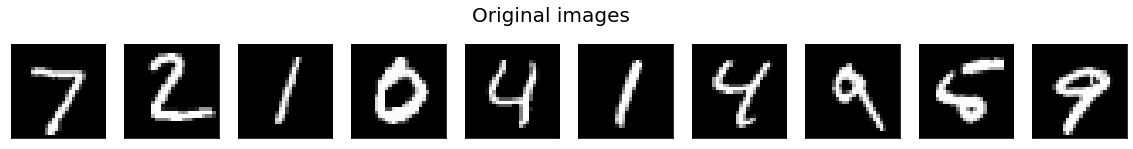

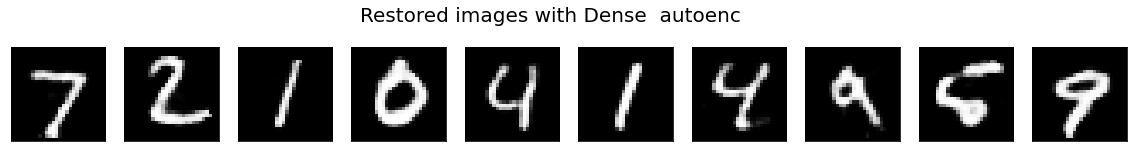

In [618]:
#оставить eps=0.3
display_pair2(x_test,clean_onest_img_dense_autoenc_reshape, 'Dense ')

In [615]:
diff_idx = find_diff_classes(y_test, test_onest_preds, n=200)

diff_idx

[4, 8, 18, 20, 42, 59, 67, 92, 95, 104, 107, 115, 121, 124, 139, 158, 172, 184]

<Figure size 1440x144 with 0 Axes>

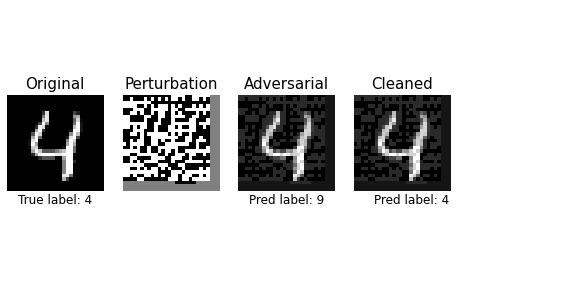

<Figure size 1440x144 with 0 Axes>

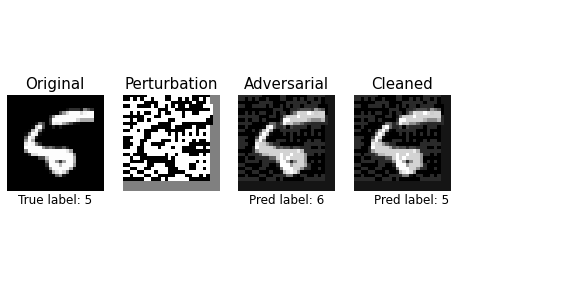

<Figure size 1440x144 with 0 Axes>

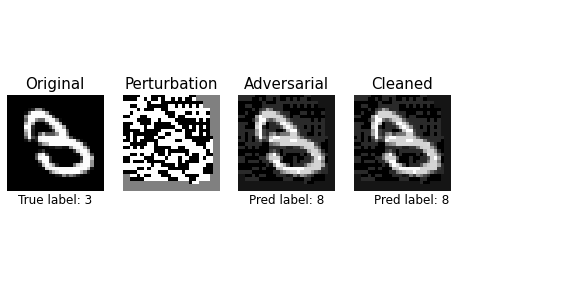

<Figure size 1440x144 with 0 Axes>

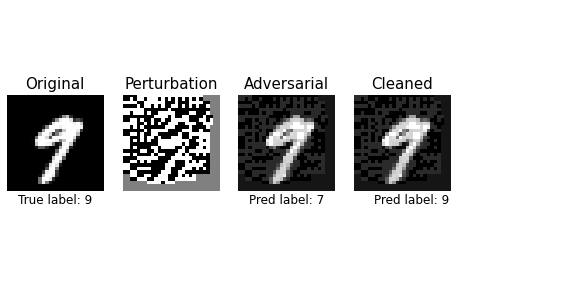

<Figure size 1440x144 with 0 Axes>

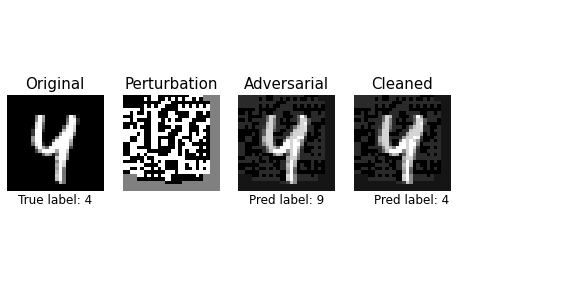

<Figure size 1440x144 with 0 Axes>

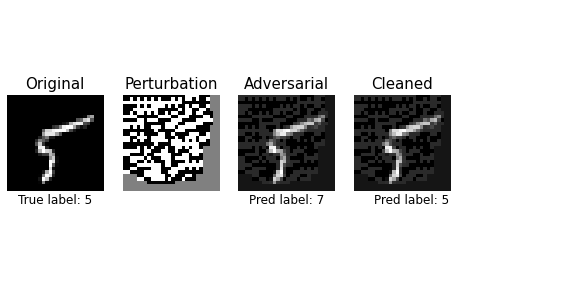

<Figure size 1440x144 with 0 Axes>

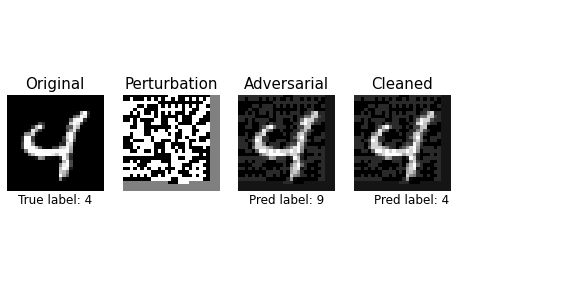

<Figure size 1440x144 with 0 Axes>

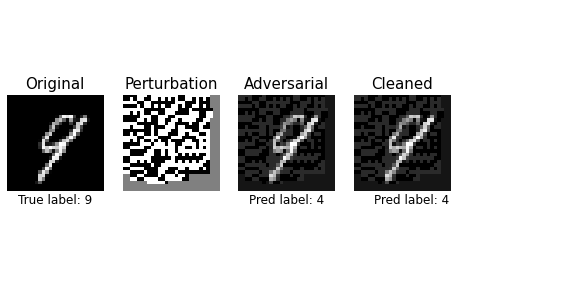

<Figure size 1440x144 with 0 Axes>

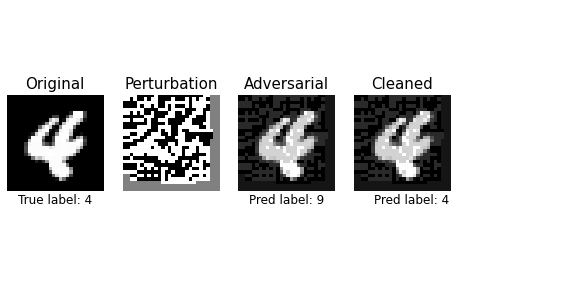

<Figure size 1440x144 with 0 Axes>

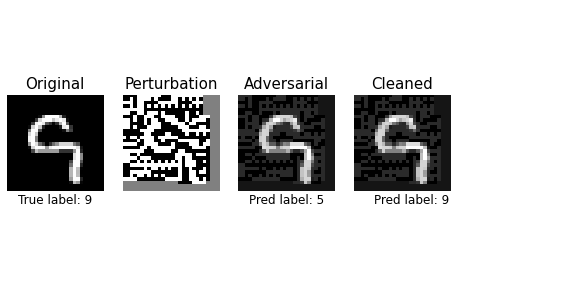

<Figure size 1440x144 with 0 Axes>

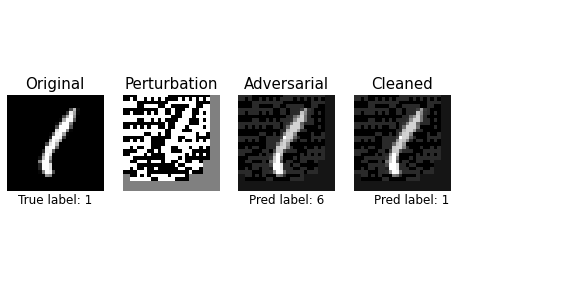

<Figure size 1440x144 with 0 Axes>

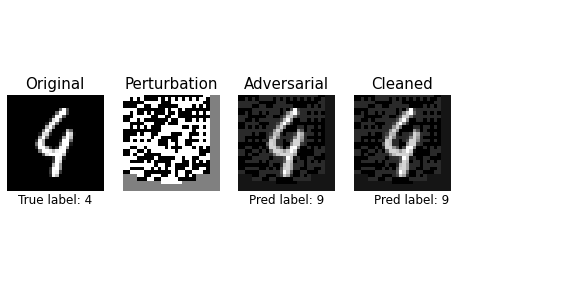

<Figure size 1440x144 with 0 Axes>

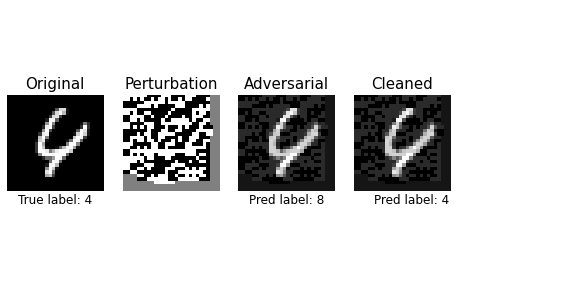

<Figure size 1440x144 with 0 Axes>

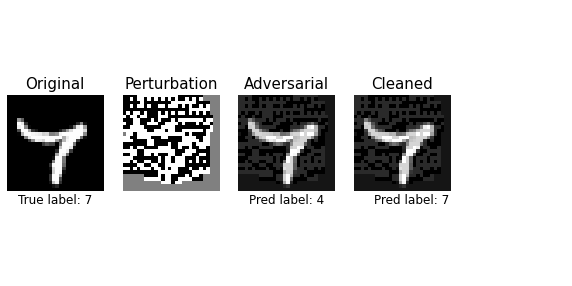

<Figure size 1440x144 with 0 Axes>

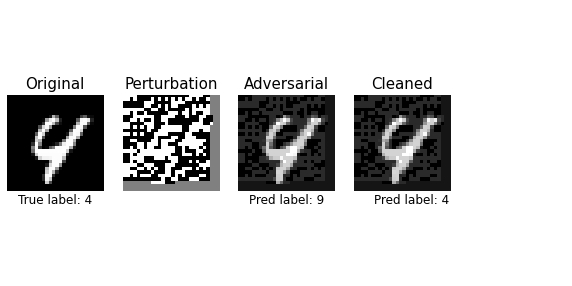

<Figure size 1440x144 with 0 Axes>

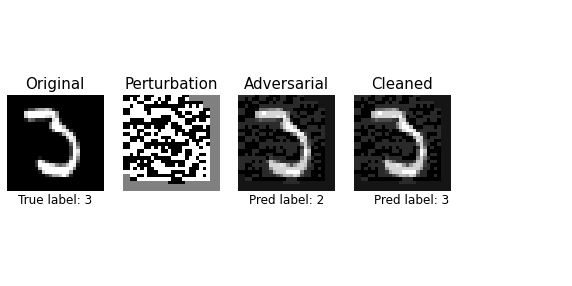

<Figure size 1440x144 with 0 Axes>

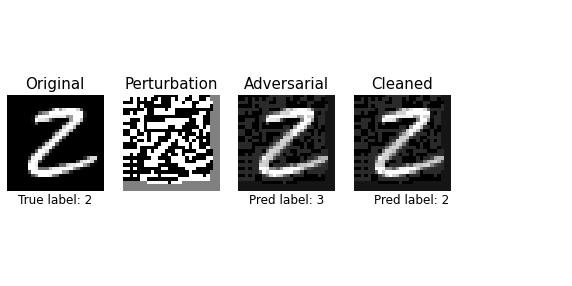

<Figure size 1440x144 with 0 Axes>

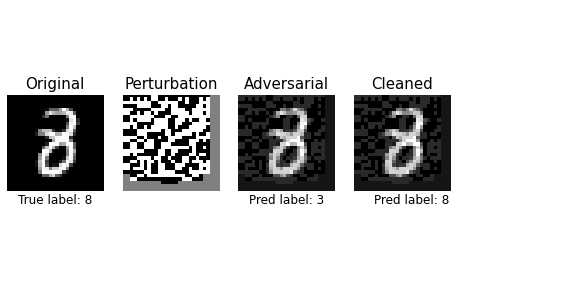

In [616]:
for idx in diff_idx:
    display_quad(x_test[idx], x_test_onest_imgs[idx], x_test_onest_perts[idx],clean_onest_img_dense_autoenc_reshape, y_test[idx], test_onest_preds[idx], after_dense_autoenc_predicts_onest[idx])

### BIM 

In [370]:
#x_test_bim_perts, x_test_bim_imgs test_bim_preds
clean_bim_img_dense_autoenc_reshape = clean_bim_img_dense_autoenc.reshape((len(x_test_dense),28,28,1))
clean_bim_img_dense_autoenc_reshape.shape

(10000, 28, 28, 1)

In [371]:
after_dense_autoenc_predicts_bim = model.predict(clean_bim_img_dense_autoenc_reshape)

In [372]:
y_test_dense_preprocessed = preprocess_labels(y_test_dense)
y_test_dense_preprocessed.shape

TensorShape([10000, 10])

In [373]:
after_dense_score_bim = model.evaluate(clean_bim_img_dense_autoenc_reshape, y_test_dense_preprocessed)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [374]:
print('Default Model after cleaning BIM perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score_bim[0]} mae: {after_dense_score_bim[1]} accuracy: {after_dense_score_bim[2]}')

Default Model after cleaning BIM perturbed images with Dense Autoencoder:
loss: 0.06805154883447831 mae: 0.004939147271215916 accuracy: 0.9811000227928162


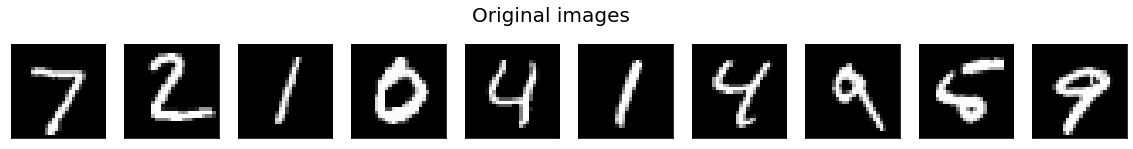

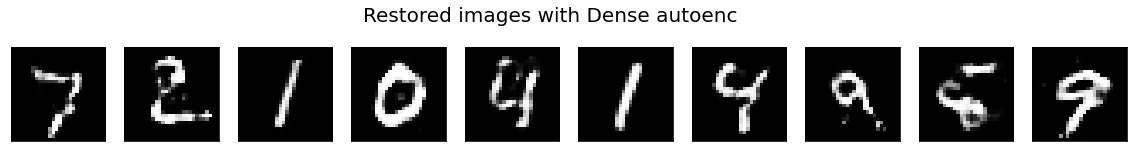

In [620]:
display_pair2(x_test,clean_bim_img_dense_autoenc_reshape, 'Dense')

In [613]:
diff_idx = find_diff_classes(y_test, test_bim_preds, n=200)

diff_idx

[]

In [614]:
for idx in diff_idx:
    display_quad(x_test[idx], x_test_bim_imgs[idx], x_test_bim_perts[idx],clean_bim_img_dense_autoenc_reshape, y_test[idx], test_bim_preds[idx], after_dense_autoenc_predicts_bim[idx])

## Conv autoencoder

In [ ]:
# usual autoencoder
#after_conv_pred = model.predict()

In [54]:
x_test_fgsm_imgs[0]

array([[[ 0.        ],
        [ 0.        ],
        [ 0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [-0.40000001],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [-0.40000001],
        [ 0.40000001],
        [

In [136]:
autoencoder = tf.keras.models.load_model(os.path.join(save_path,'autoenc_clean_clean'))

#### FGSM


In [308]:

after_conv_pred = autoencoder.predict(x_test_fgsm_imgs)

In [579]:
after_conv_pred[0].shape

(28, 28, 1)

In [590]:
after_conv_preds_fgsm = model.predict(after_conv_pred)

In [591]:
after_conv_preds_fgsm[0]

array([2.5500967e-08, 2.1695644e-06, 2.9299699e-06, 3.7867626e-06,
       1.6915409e-07, 3.5195459e-08, 3.7104656e-13, 9.9996674e-01,
       1.1047446e-08, 2.4109147e-05], dtype=float32)

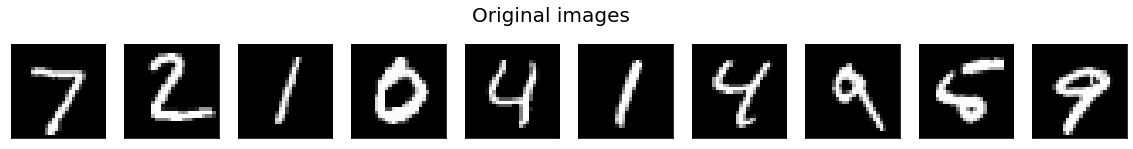

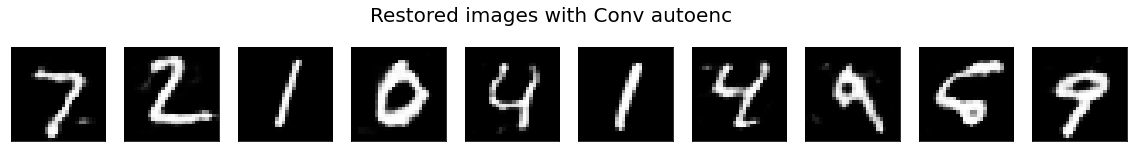

In [621]:
# оставить! eps = 0.1
display_pair2(x_test, after_conv_pred, 'Conv')

In [310]:
after_conv_score = model.evaluate(after_conv_pred, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [312]:
print('Default Model after cleaning FGSM perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score[0]} mae: {after_conv_score[1]} accuracy: {after_conv_score[2]}') 

Default Model after cleaning FGSM perturbed images with Conv Autoencoder:
loss: 0.1286849083545385 mae: 0.009321599267423153 accuracy: 0.9628999829292297


In [599]:
diff_idx2 = find_diff_classes(y_test, test_fgsm_preds, n=500)
print(diff_idx2)

[4, 8, 18, 20, 24, 42, 59, 62, 67, 92, 95, 104, 107, 115, 121, 124, 139, 149, 158, 172, 175, 184, 193, 195, 247, 259, 264, 266, 275, 290, 320, 321, 326, 333, 336, 340, 355, 358, 359, 366, 381, 400, 412, 420, 435, 445, 447, 448, 449, 450, 460, 462, 464, 490, 492, 495, 497]


<Figure size 1440x144 with 0 Axes>

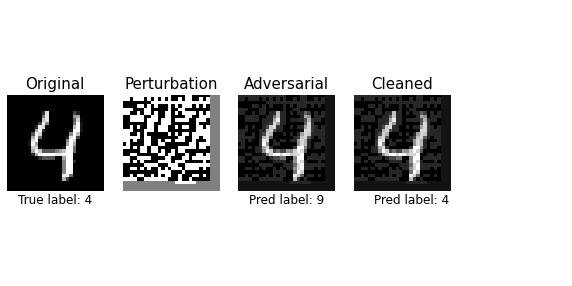

<Figure size 1440x144 with 0 Axes>

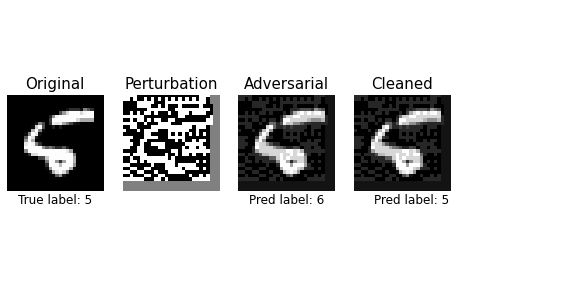

<Figure size 1440x144 with 0 Axes>

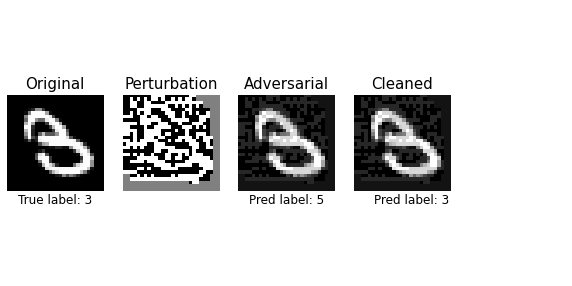

<Figure size 1440x144 with 0 Axes>

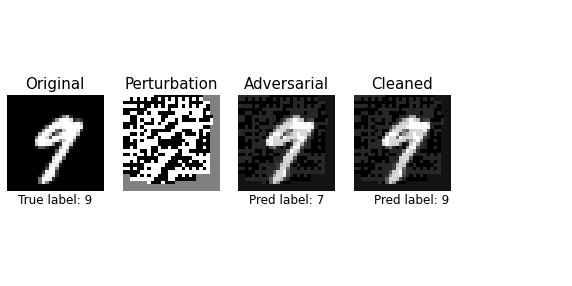

<Figure size 1440x144 with 0 Axes>

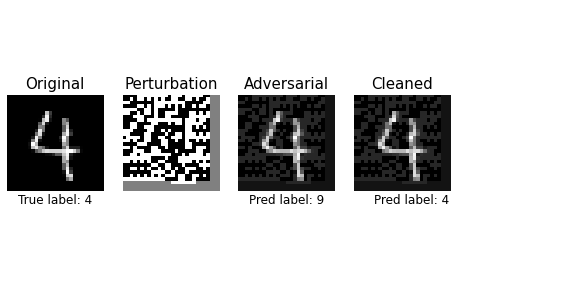

<Figure size 1440x144 with 0 Axes>

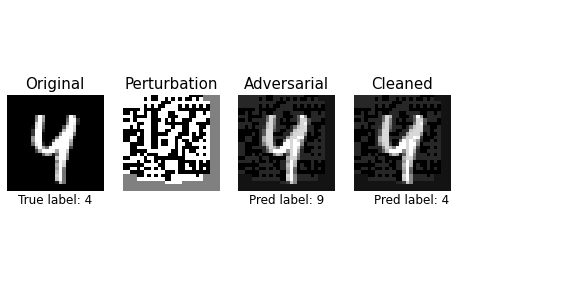

<Figure size 1440x144 with 0 Axes>

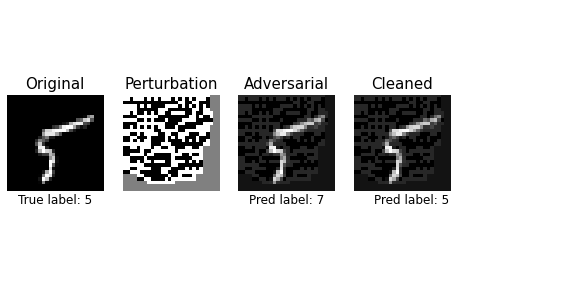

<Figure size 1440x144 with 0 Axes>

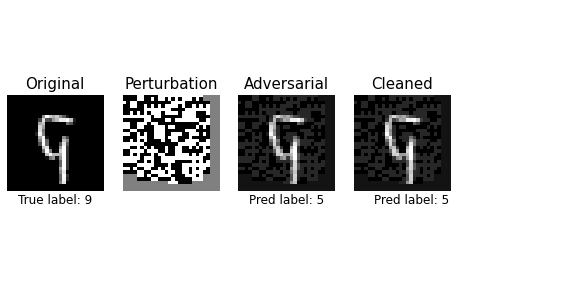

<Figure size 1440x144 with 0 Axes>

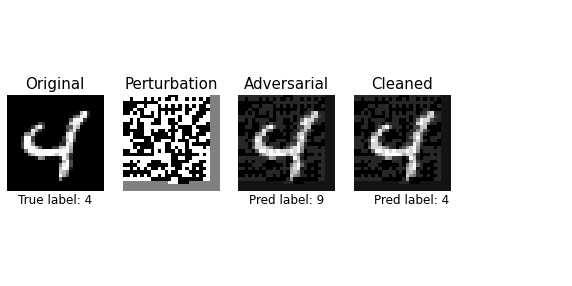

<Figure size 1440x144 with 0 Axes>

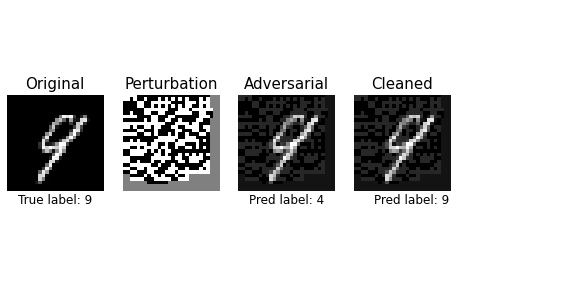

<Figure size 1440x144 with 0 Axes>

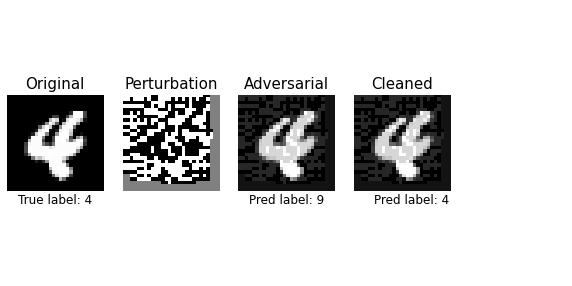

<Figure size 1440x144 with 0 Axes>

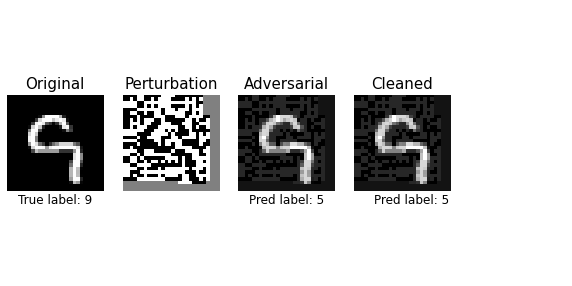

<Figure size 1440x144 with 0 Axes>

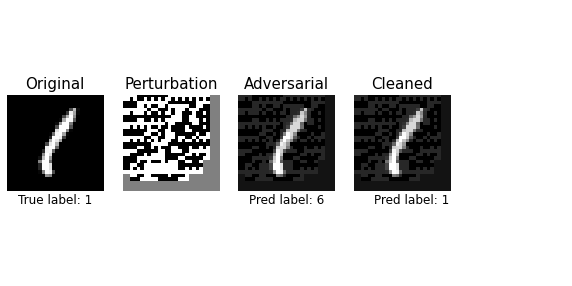

<Figure size 1440x144 with 0 Axes>

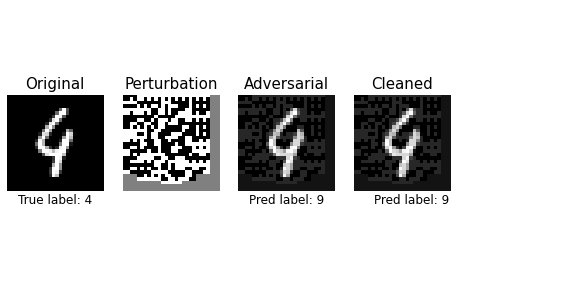

<Figure size 1440x144 with 0 Axes>

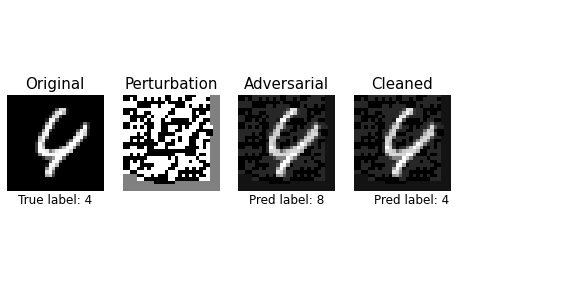

<Figure size 1440x144 with 0 Axes>

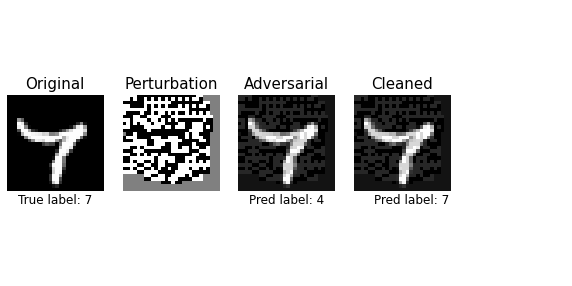

<Figure size 1440x144 with 0 Axes>

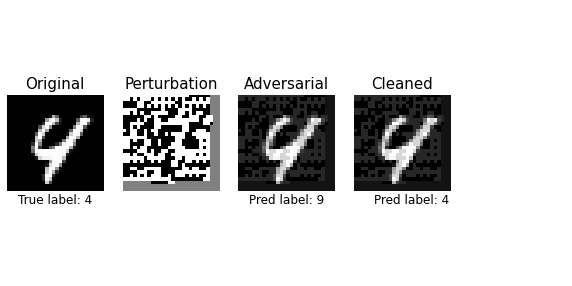

<Figure size 1440x144 with 0 Axes>

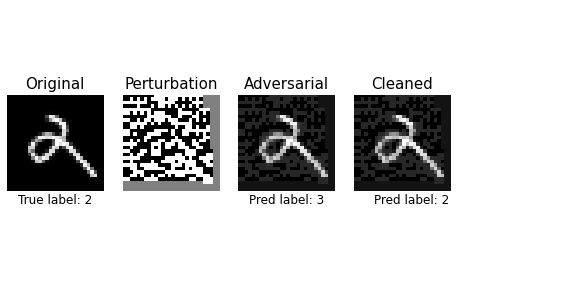

<Figure size 1440x144 with 0 Axes>

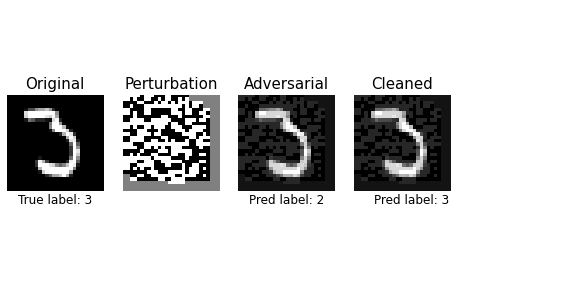

<Figure size 1440x144 with 0 Axes>

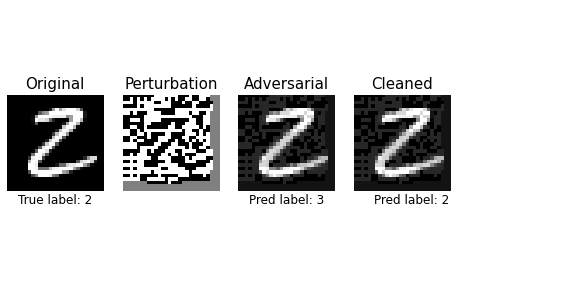

<Figure size 1440x144 with 0 Axes>

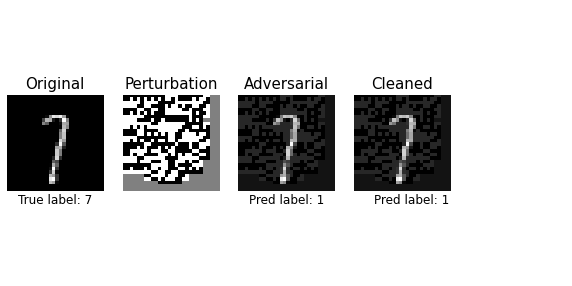

<Figure size 1440x144 with 0 Axes>

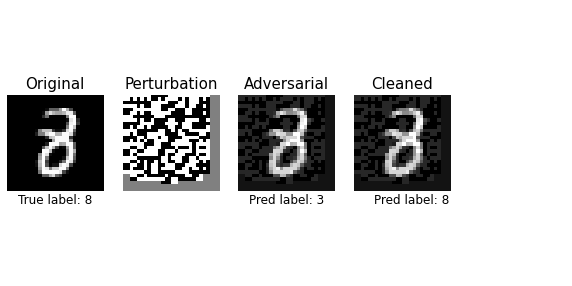

<Figure size 1440x144 with 0 Axes>

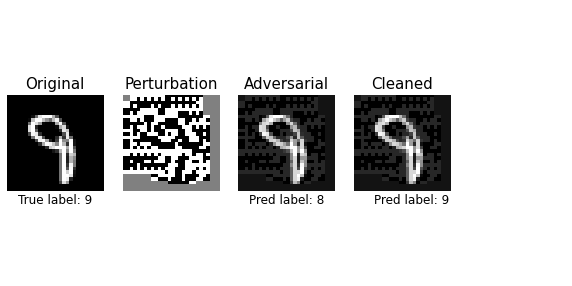

<Figure size 1440x144 with 0 Axes>

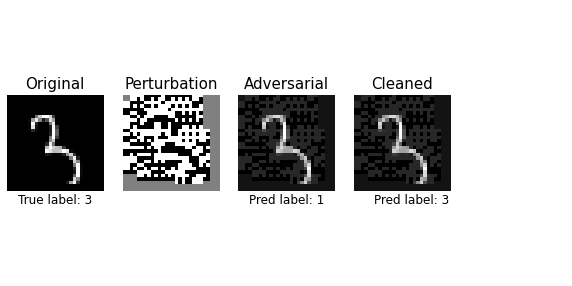

<Figure size 1440x144 with 0 Axes>

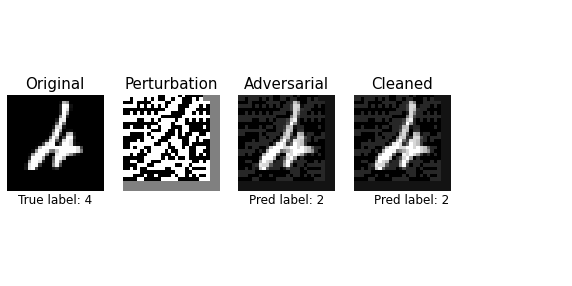

<Figure size 1440x144 with 0 Axes>

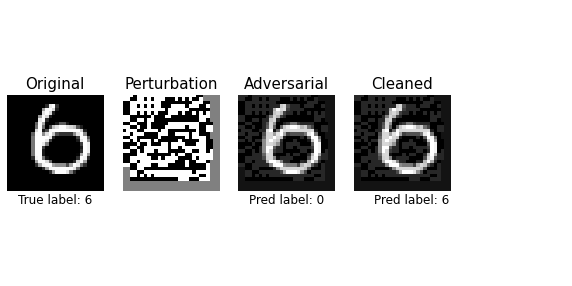

<Figure size 1440x144 with 0 Axes>

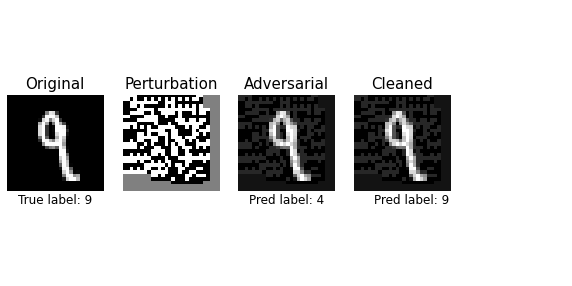

<Figure size 1440x144 with 0 Axes>

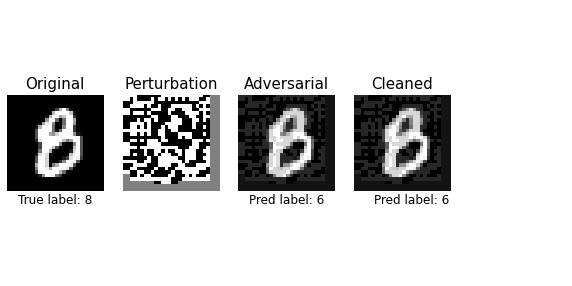

<Figure size 1440x144 with 0 Axes>

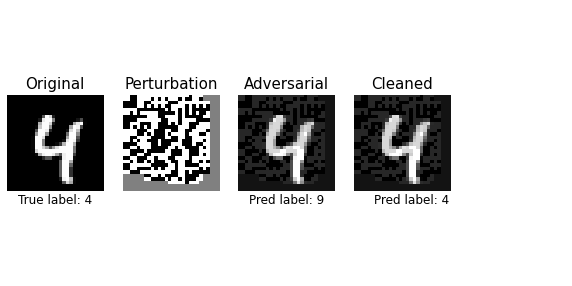

<Figure size 1440x144 with 0 Axes>

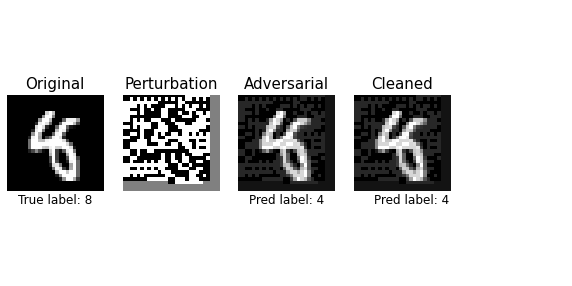

<Figure size 1440x144 with 0 Axes>

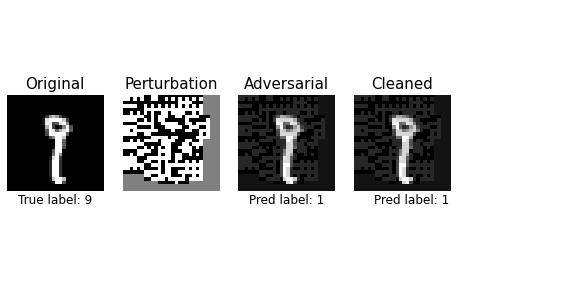

<Figure size 1440x144 with 0 Axes>

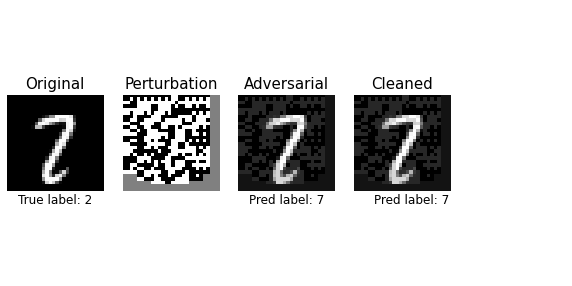

<Figure size 1440x144 with 0 Axes>

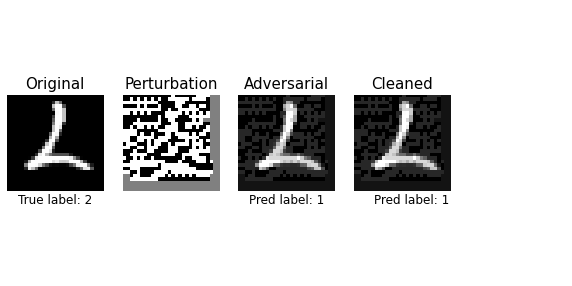

<Figure size 1440x144 with 0 Axes>

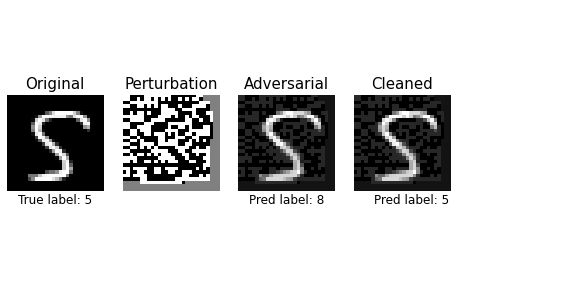

<Figure size 1440x144 with 0 Axes>

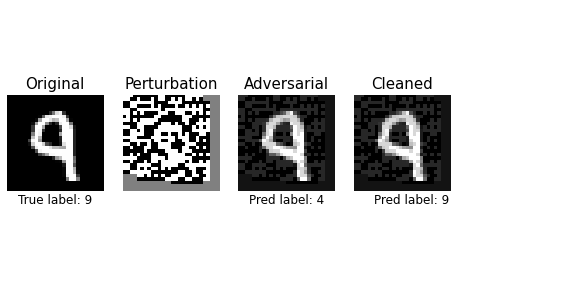

<Figure size 1440x144 with 0 Axes>

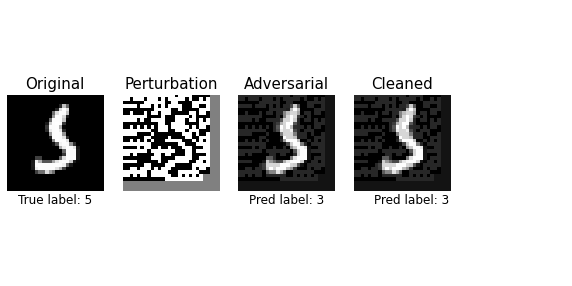

<Figure size 1440x144 with 0 Axes>

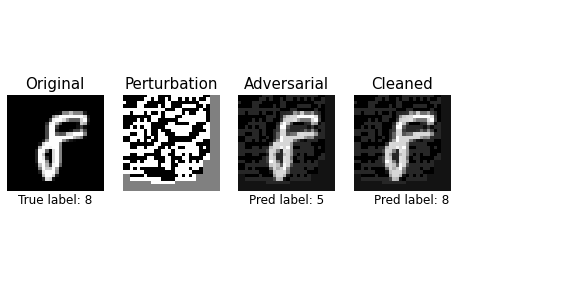

<Figure size 1440x144 with 0 Axes>

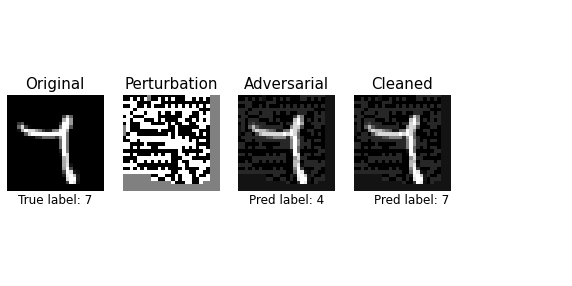

<Figure size 1440x144 with 0 Axes>

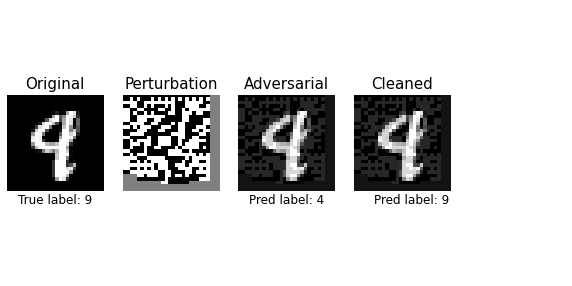

<Figure size 1440x144 with 0 Axes>

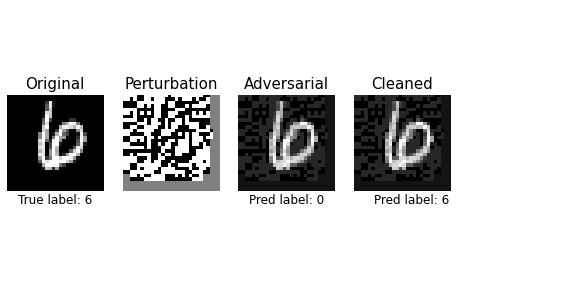

<Figure size 1440x144 with 0 Axes>

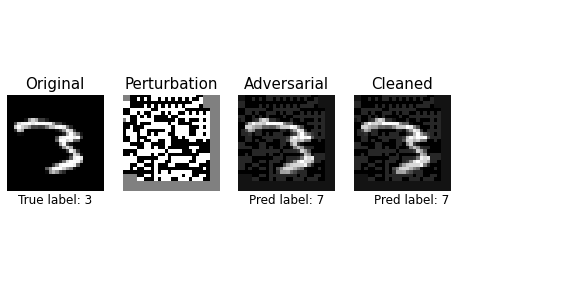

<Figure size 1440x144 with 0 Axes>

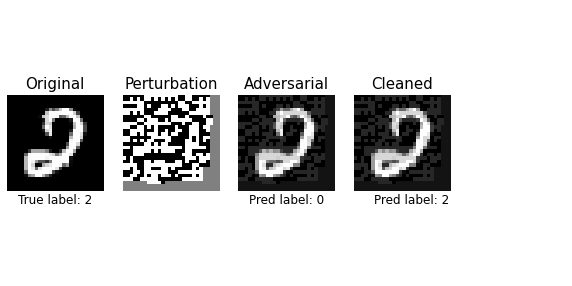

<Figure size 1440x144 with 0 Axes>

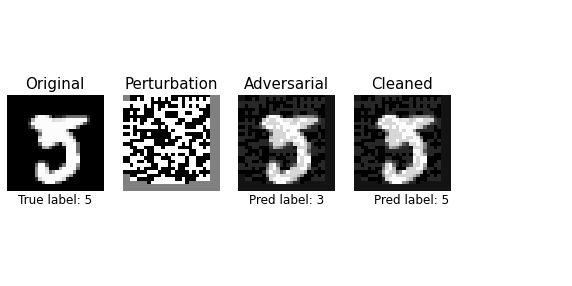

<Figure size 1440x144 with 0 Axes>

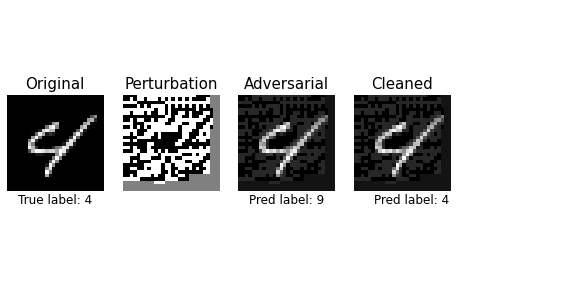

<Figure size 1440x144 with 0 Axes>

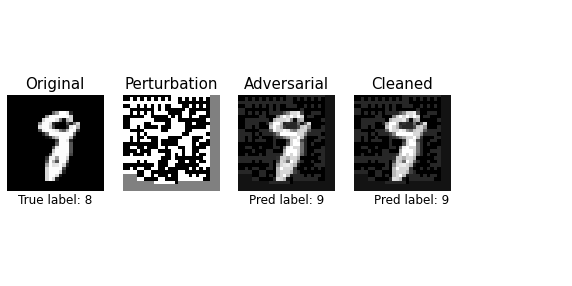

<Figure size 1440x144 with 0 Axes>

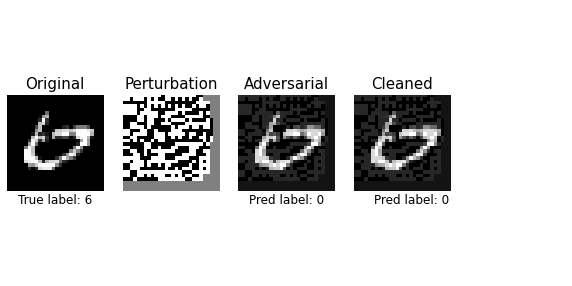

<Figure size 1440x144 with 0 Axes>

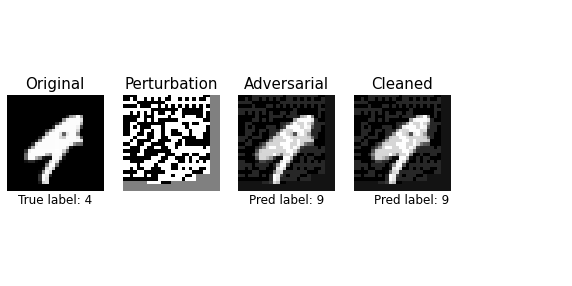

<Figure size 1440x144 with 0 Axes>

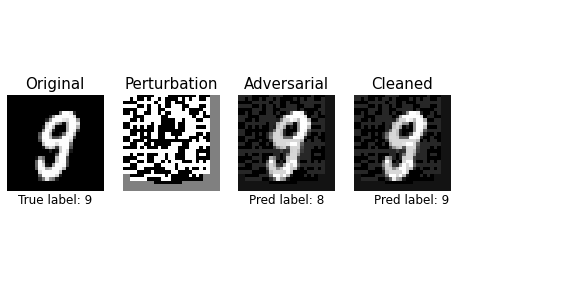

<Figure size 1440x144 with 0 Axes>

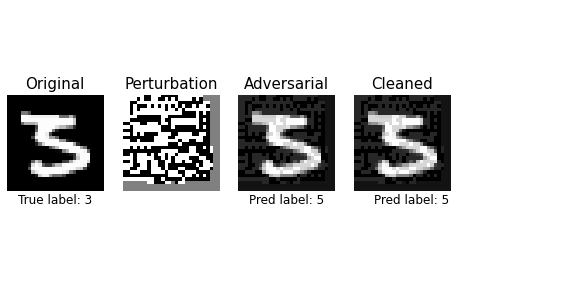

<Figure size 1440x144 with 0 Axes>

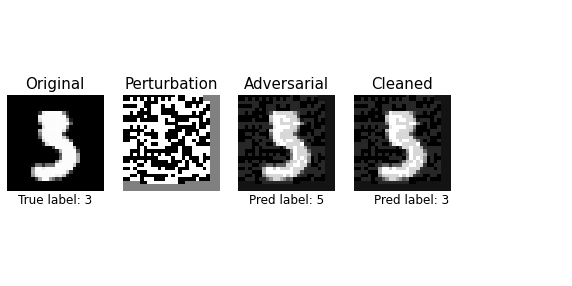

<Figure size 1440x144 with 0 Axes>

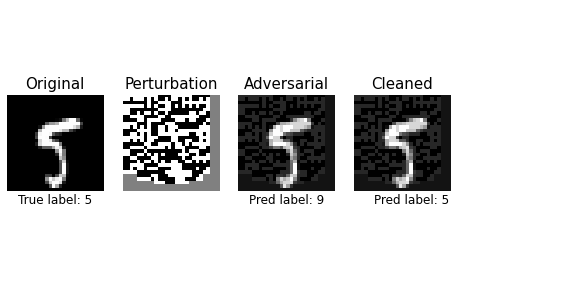

<Figure size 1440x144 with 0 Axes>

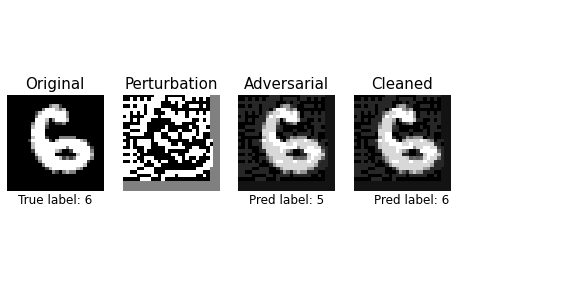

<Figure size 1440x144 with 0 Axes>

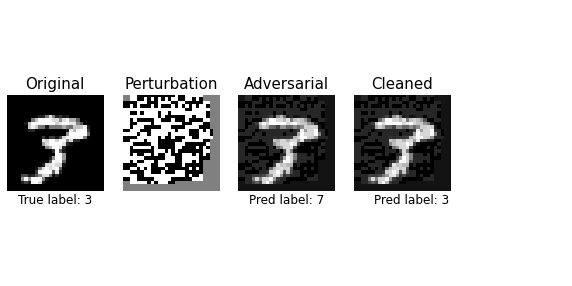

<Figure size 1440x144 with 0 Axes>

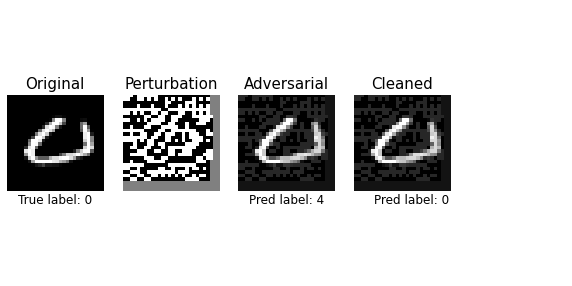

<Figure size 1440x144 with 0 Axes>

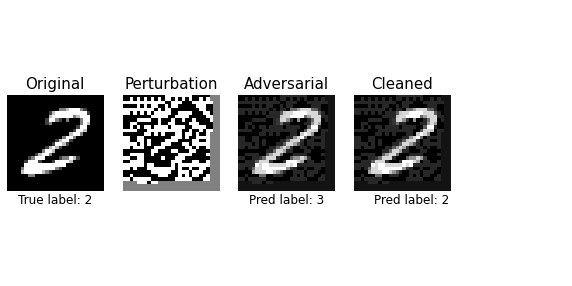

<Figure size 1440x144 with 0 Axes>

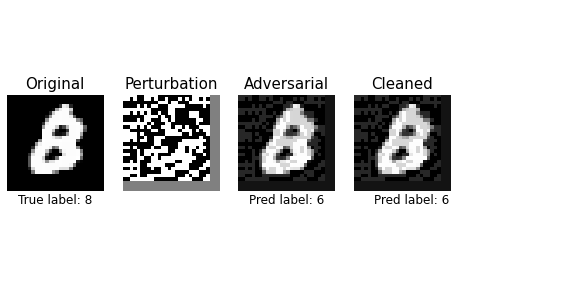

<Figure size 1440x144 with 0 Axes>

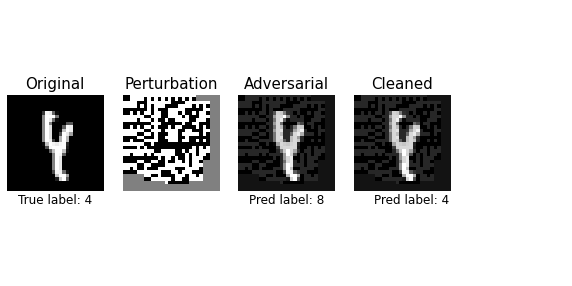

In [600]:
for i in diff_idx2:
    display_quad(x_test[i], x_test_fgsm_imgs[i], x_test_fgsm_perts[i], after_conv_pred[i], y_test[i], test_fgsm_preds[i], after_conv_preds_fgsm[i])

#### OneStepLessLikely

In [237]:
after_conv_pred_onest = autoencoder.predict(x_test_onest_imgs)

In [238]:
after_conv_score_onest = model.evaluate(after_conv_pred_onest, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [239]:
print('Default Model after cleaning OneStepLessLikely perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score_onest[0]} mae: {after_conv_score_onest[1]} accuracy: {after_conv_score_onest[2]}') 

Default Model after cleaning OneStepLessLikely perturbed images with Conv Autoencoder:
loss: 2.1577496183395386 mae: 0.08264876157045364 accuracy: 0.597100019454956


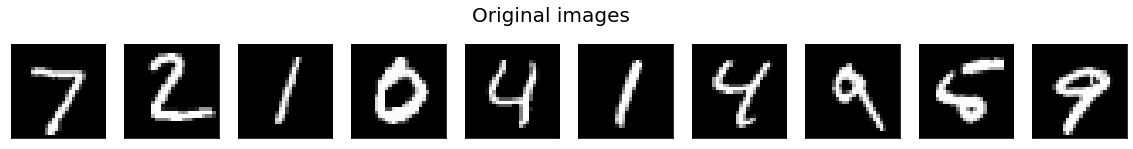

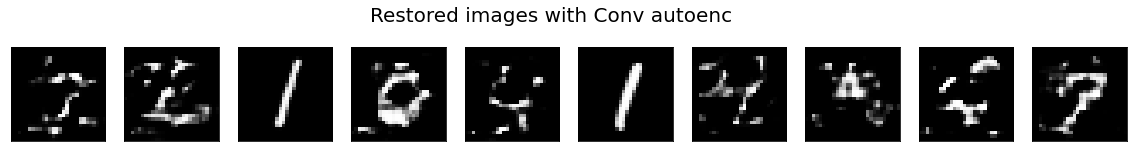

In [622]:
#оставить eps=0.3
display_pair2(x_test, after_conv_pred_onest, 'Conv')

#### BIM

In [281]:
after_conv_pred_bim = autoencoder.predict(x_test_bim_imgs)
after_conv_score_bim = model.evaluate(after_conv_pred_bim, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [282]:
print('Default Model after cleaning BIM perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score_bim[0]} mae: {after_conv_score_bim[1]} accuracy: {after_conv_score_bim[2]}') 

Default Model after cleaning BIM perturbed images with Conv Autoencoder:
loss: 4.0263157611846925 mae: 0.10311377048492432 accuracy: 0.4943999946117401


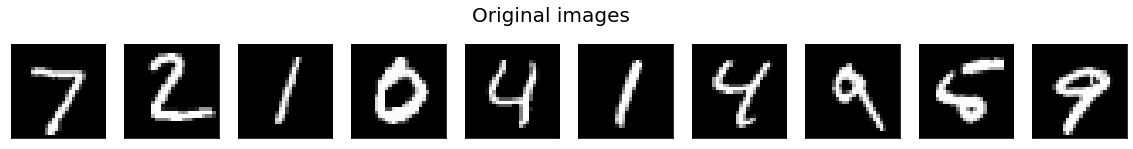

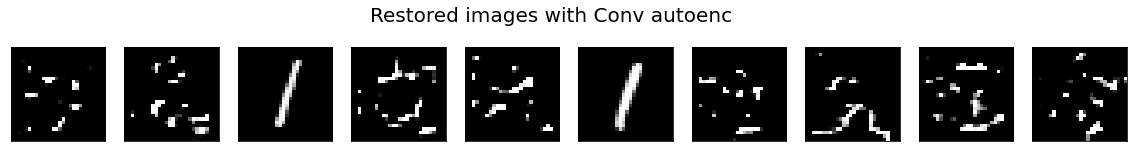

In [623]:
#eps = 1.0
display_pair2(x_test, after_conv_pred_bim, 'Conv')

In [601]:
after_conv_preds_bim = model.predict(after_conv_pred_bim)
after_conv_preds_bim[0]

array([6.0421775e-07, 4.9867039e-03, 2.8912412e-02, 9.2742674e-02,
       3.2875669e-04, 3.0840992e-04, 2.1892501e-07, 8.7269139e-01,
       3.2383204e-07, 2.8555329e-05], dtype=float32)

In [605]:
diff_idx2 = find_diff_classes(y_test, test_bim_preds, n=10000)
print(diff_idx2)

[1014, 2654, 9729]


<Figure size 1440x144 with 0 Axes>

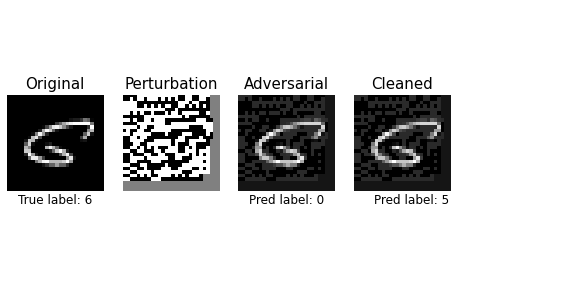

<Figure size 1440x144 with 0 Axes>

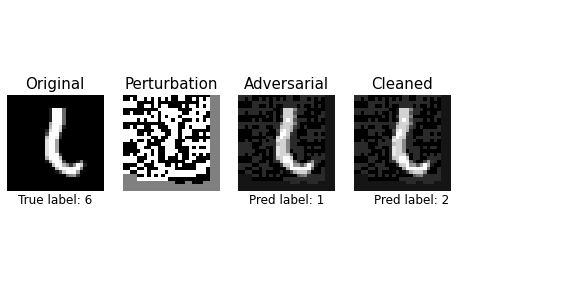

<Figure size 1440x144 with 0 Axes>

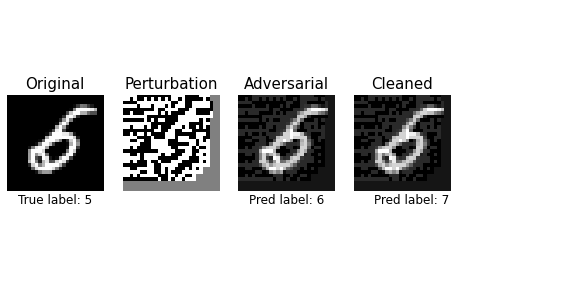

In [606]:
for i in diff_idx2:
    display_quad(x_test[i], x_test_bim_imgs[i], x_test_bim_perts[i], after_conv_pred_bim[i], y_test[i], test_bim_preds[i], after_conv_preds_bim[i])